Units used: GeV for masses, s for time, cm for distances

In [1]:
import os
import glob
import importlib

import matplotlib as mlib
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{slashed}"

import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
os.system('git -C /home/stasya/prj/alps-running/TdAlps-Internal/ fetch;\
git -C /home/stasya/prj/alps-running/TdAlps-Internal/ status')
import TdAlps
from collections import OrderedDict

import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [2]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [3]:
def importNotebook(name):
    
    currentDir=os.getcwd()
    notebookDir=os.path.dirname(name)
    os.chdir(notebookDir)
    os.system('git fetch; git status')
    notebookName=os.path.basename(name).split('.')[0]
    module = importlib.import_module(f"ipynb.fs.full.{notebookName}")
    
    os.chdir(currentDir)
    
    globals().update(vars(module))

In [4]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_base.ipynb")

On branch main
Your branch is behind 'origin/main' by 8 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ALPs_BRs.ipynb
	modified:   ALPs_base.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	ALPs_BRs-check.ipynb
	ALPs_wip-Nastya.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


On branch main
Your branch is behind 'origin/main' by 8 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ALPs_BRs.ipynb
	modified:   ALPs_base.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	ALPs_BRs-check.ipynb
	ALPs_wip-Nastya.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


/home/stasya/prj/alps/Python/ALPs_base.ipynb:642: ComplexWarning: Casting complex values to real discards the imaginary part
  "\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:682: ComplexWarning: Casting complex values to real discards the imaginary part
  "    return float(gamma)\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:695: ComplexWarning: Casting complex values to real discards the imaginary part
  "    alphaEM = readAlphaEM(coeffs)\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:669: ComplexWarning: Casting complex values to real discards the imaginary part
  {


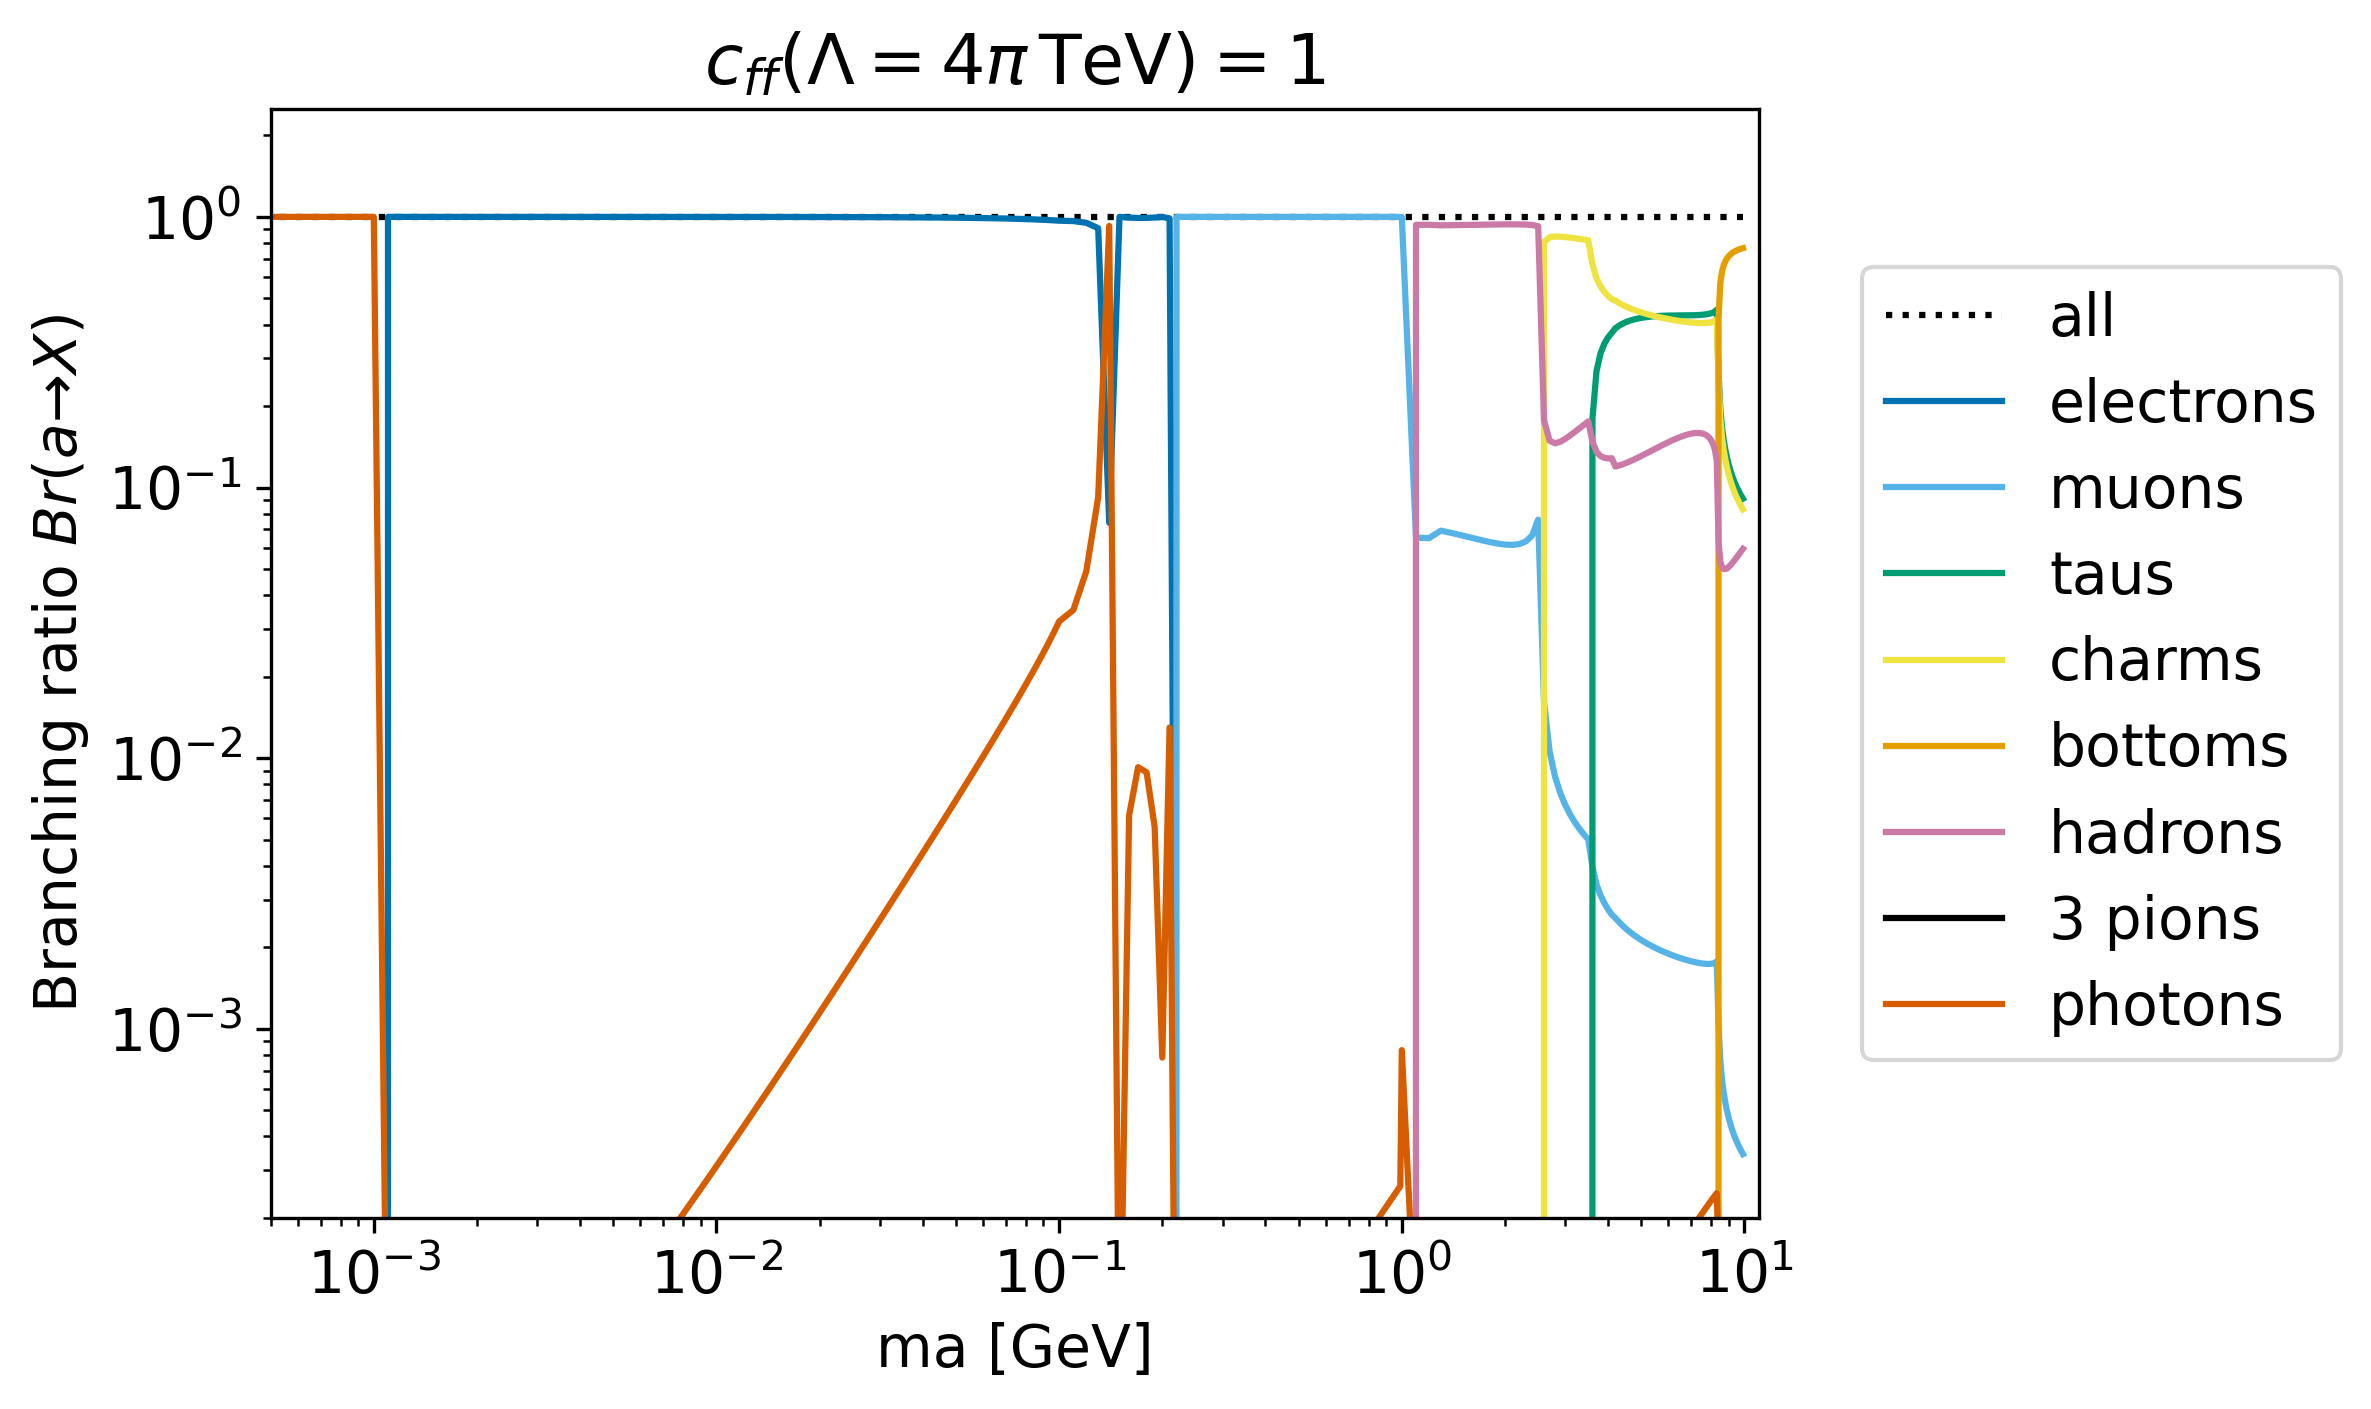

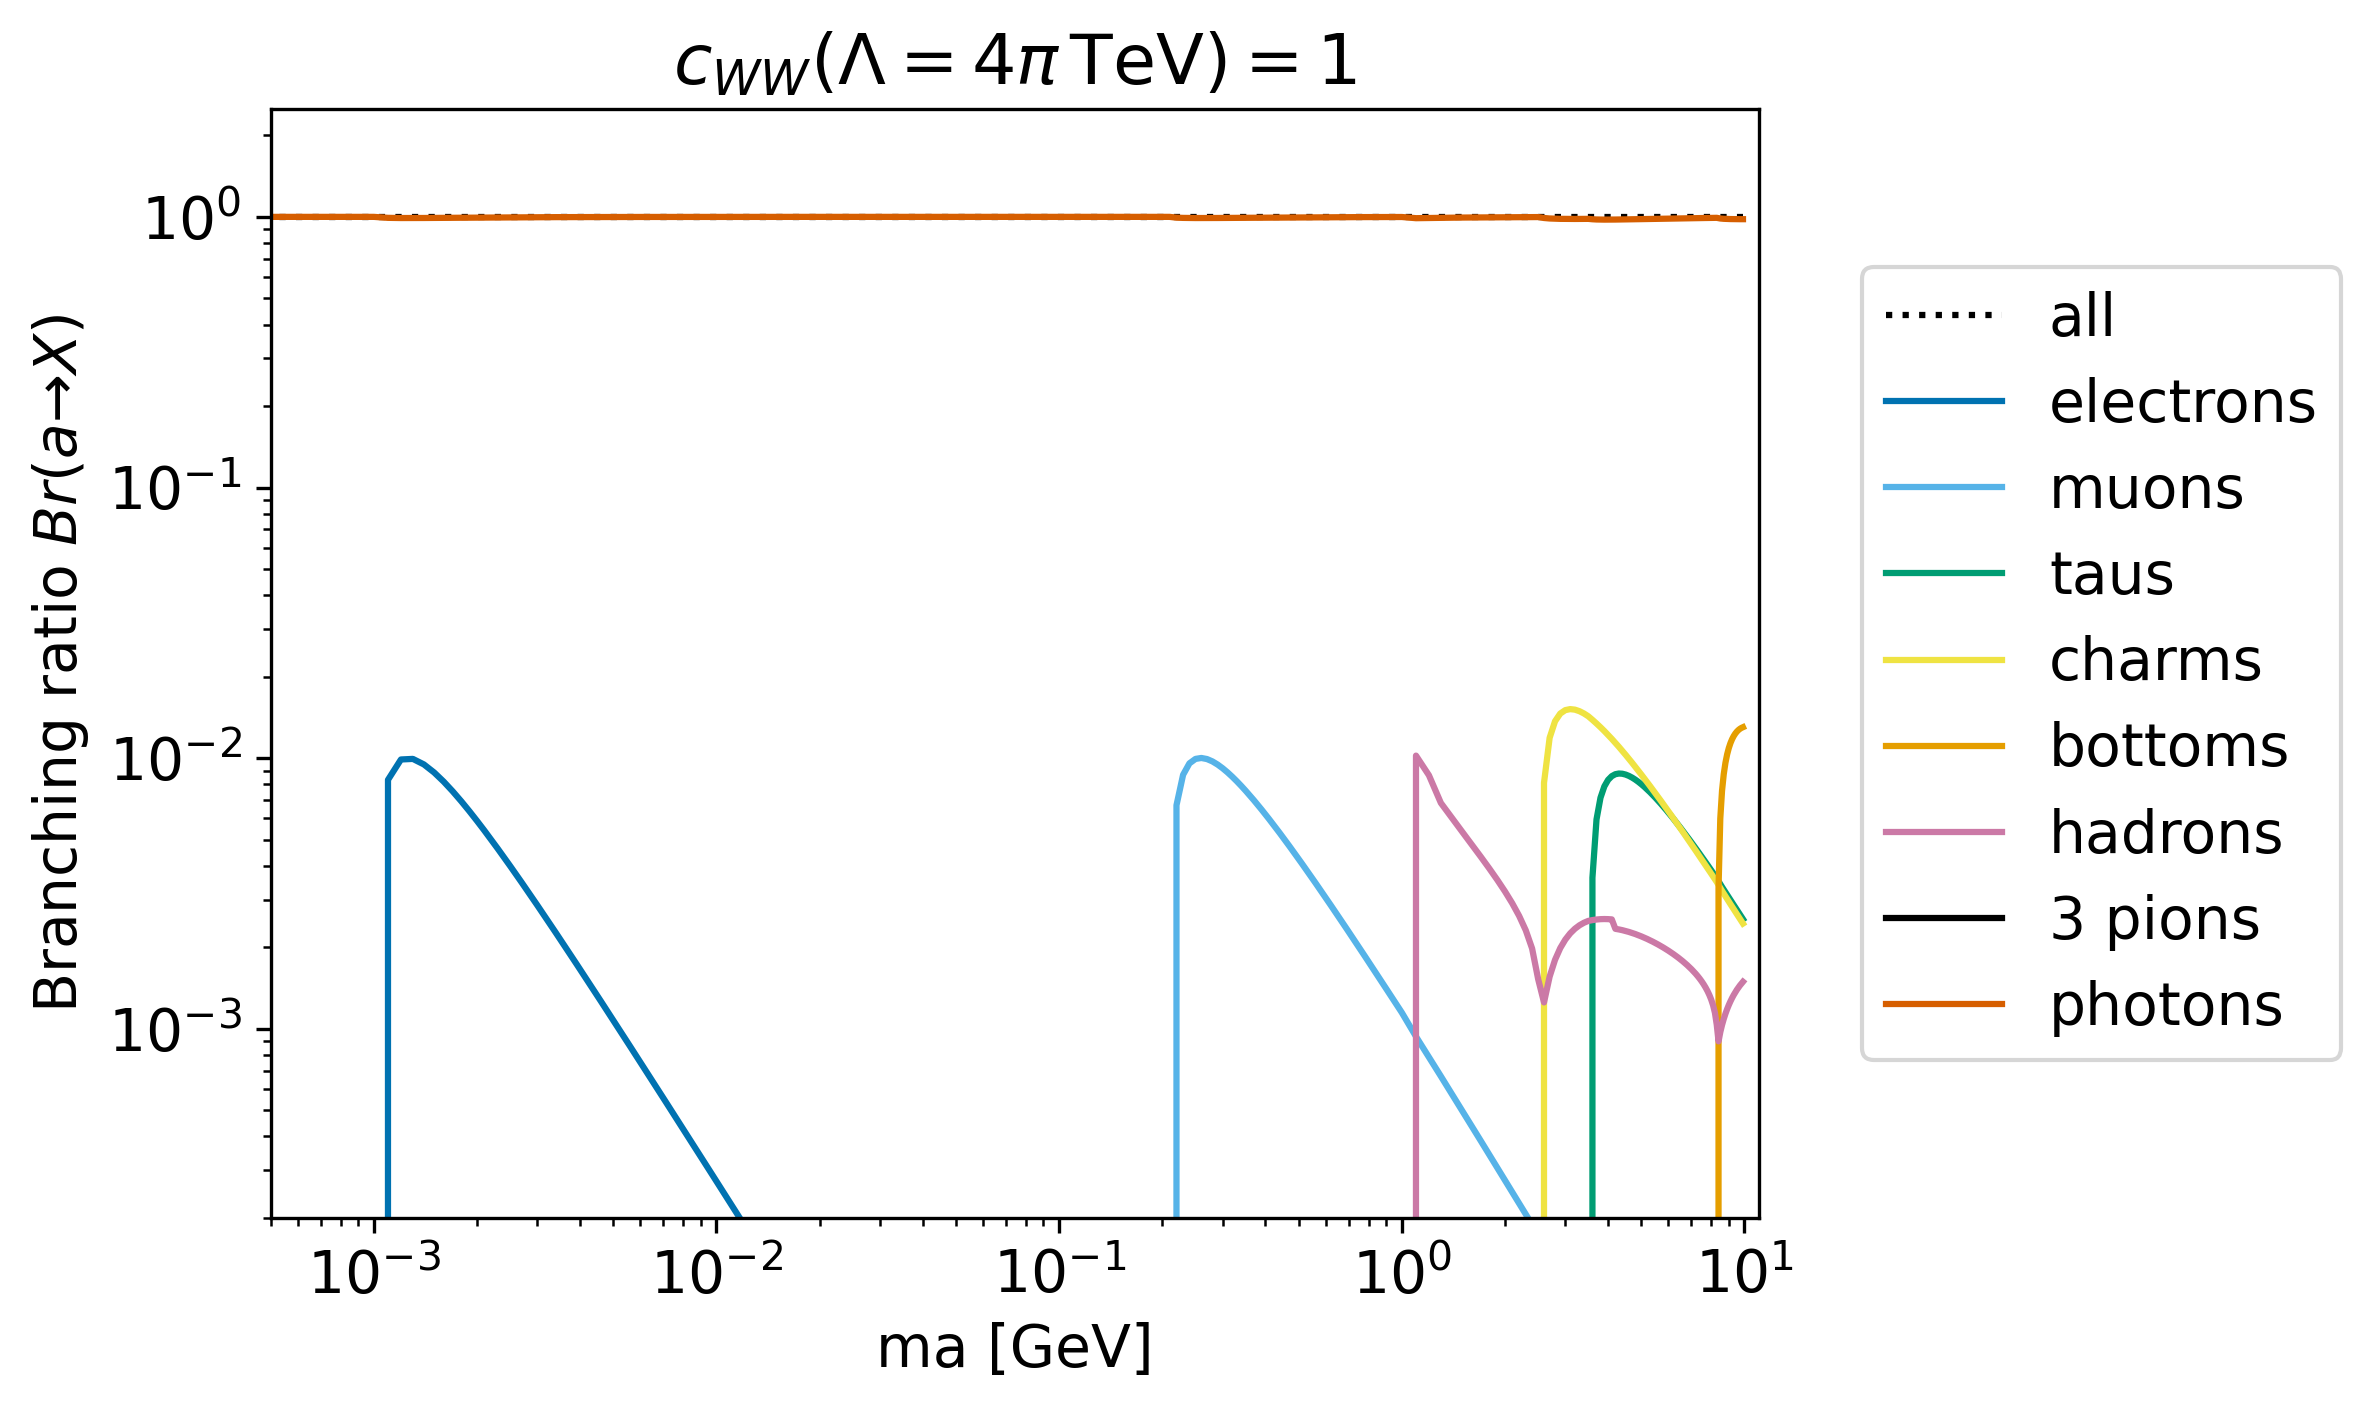

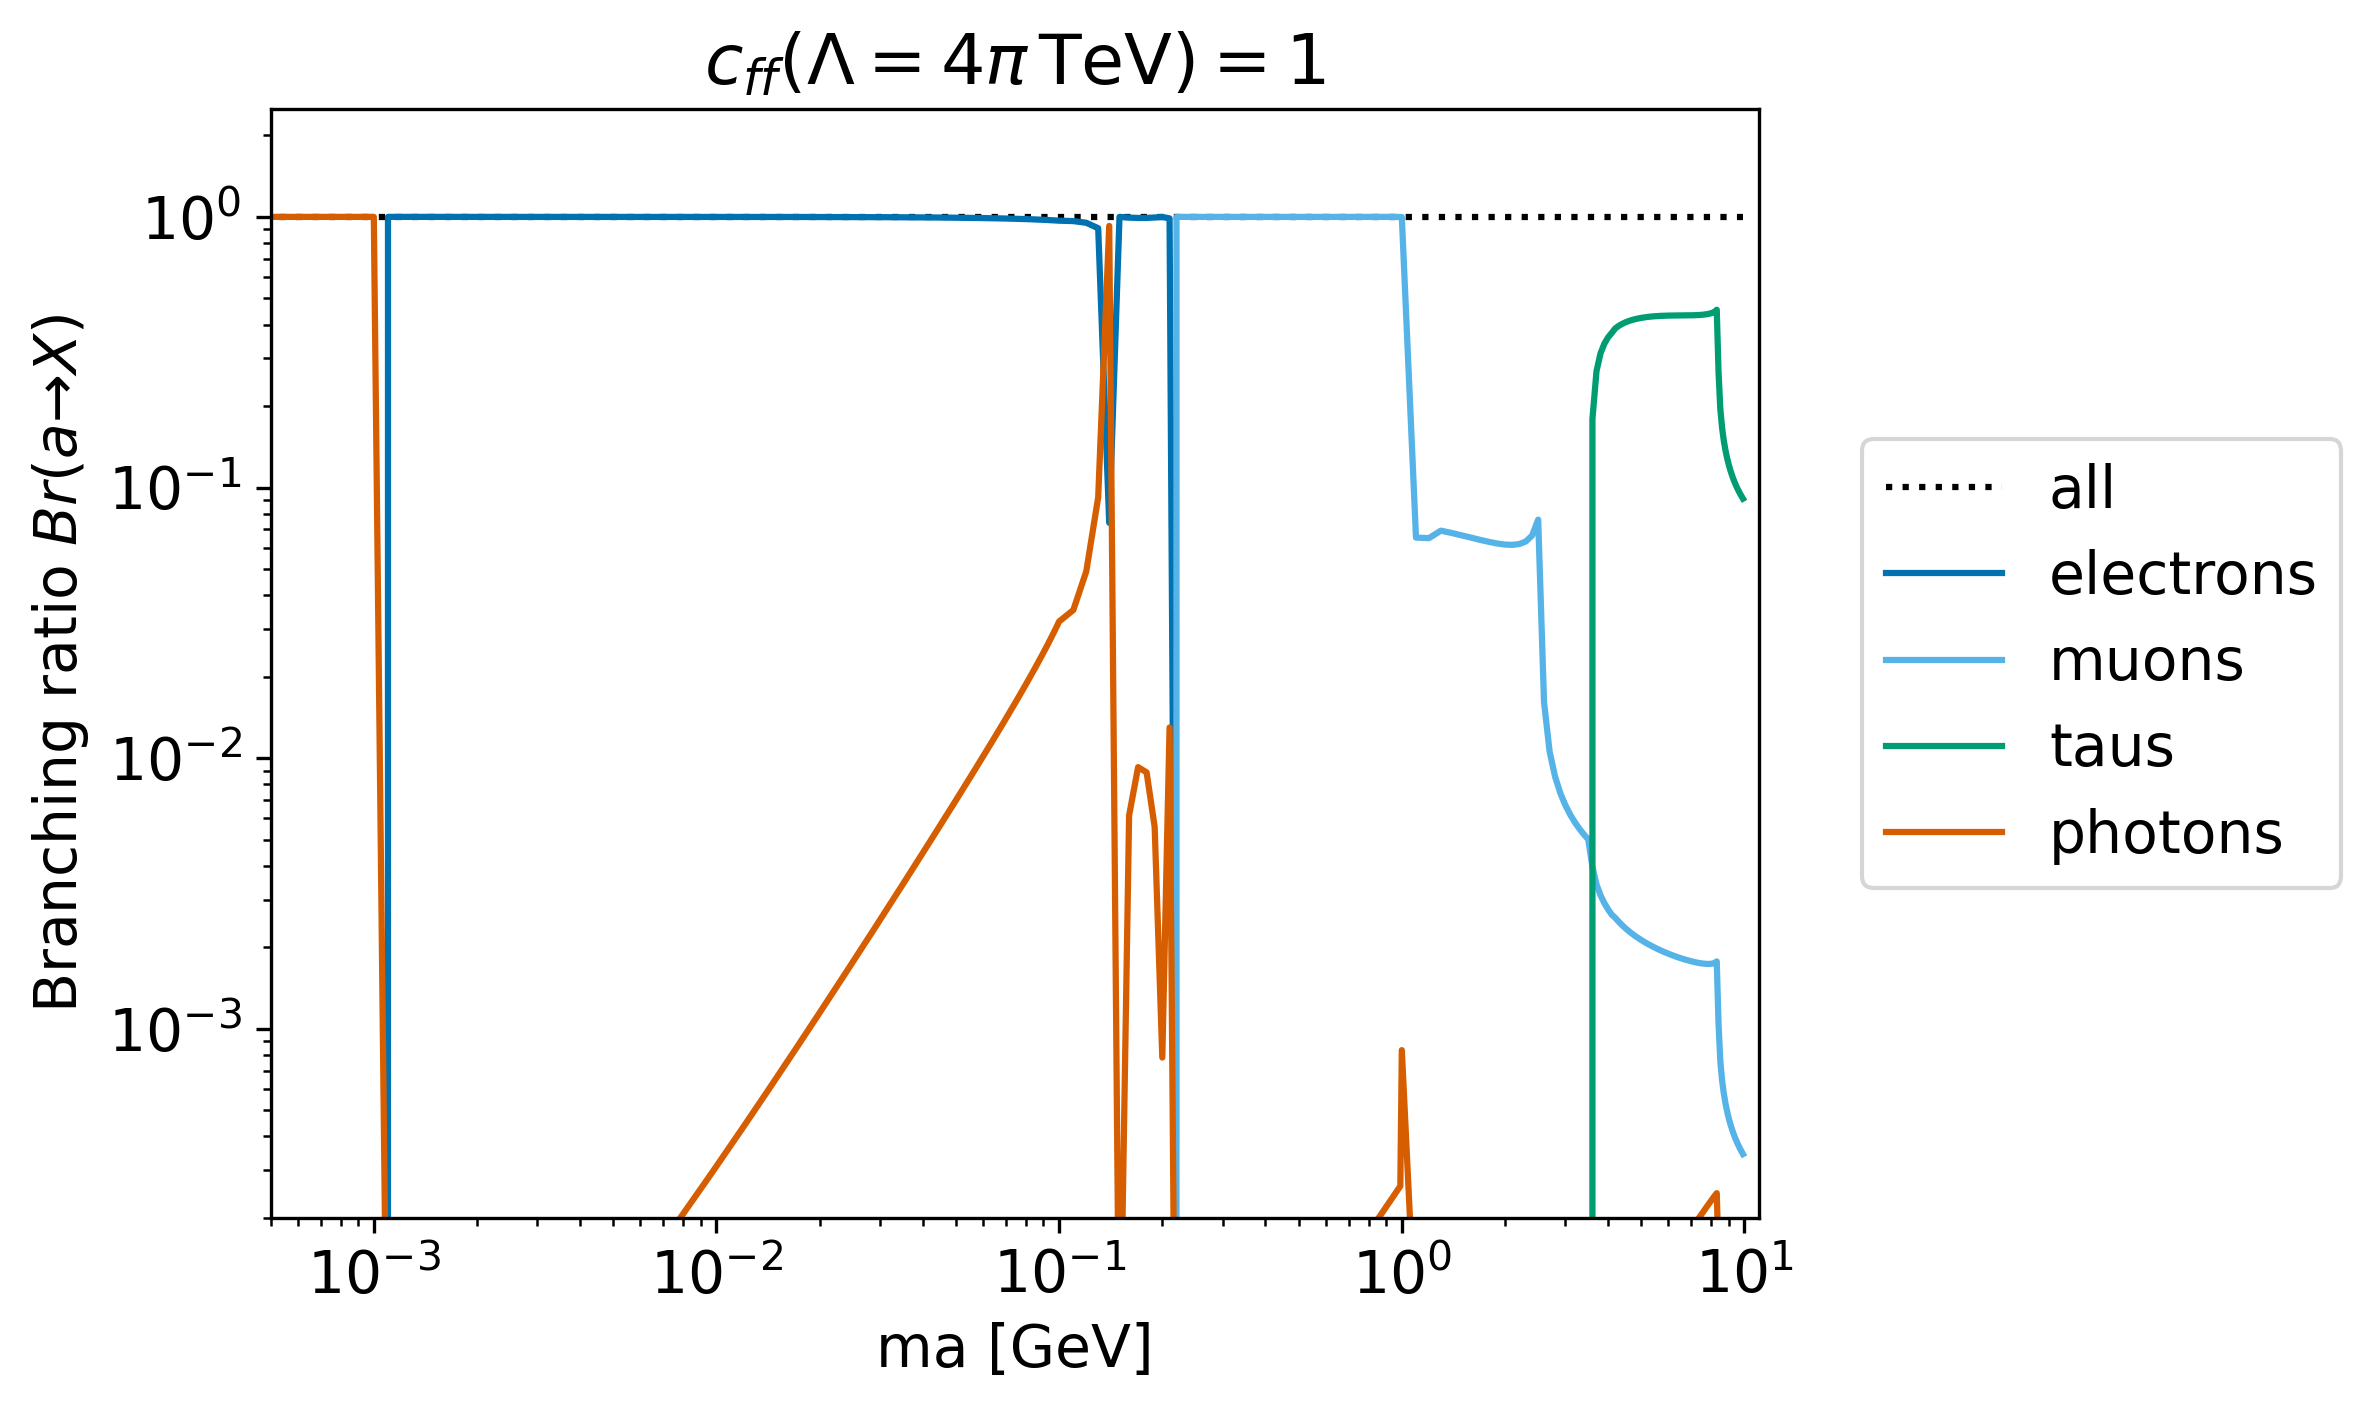

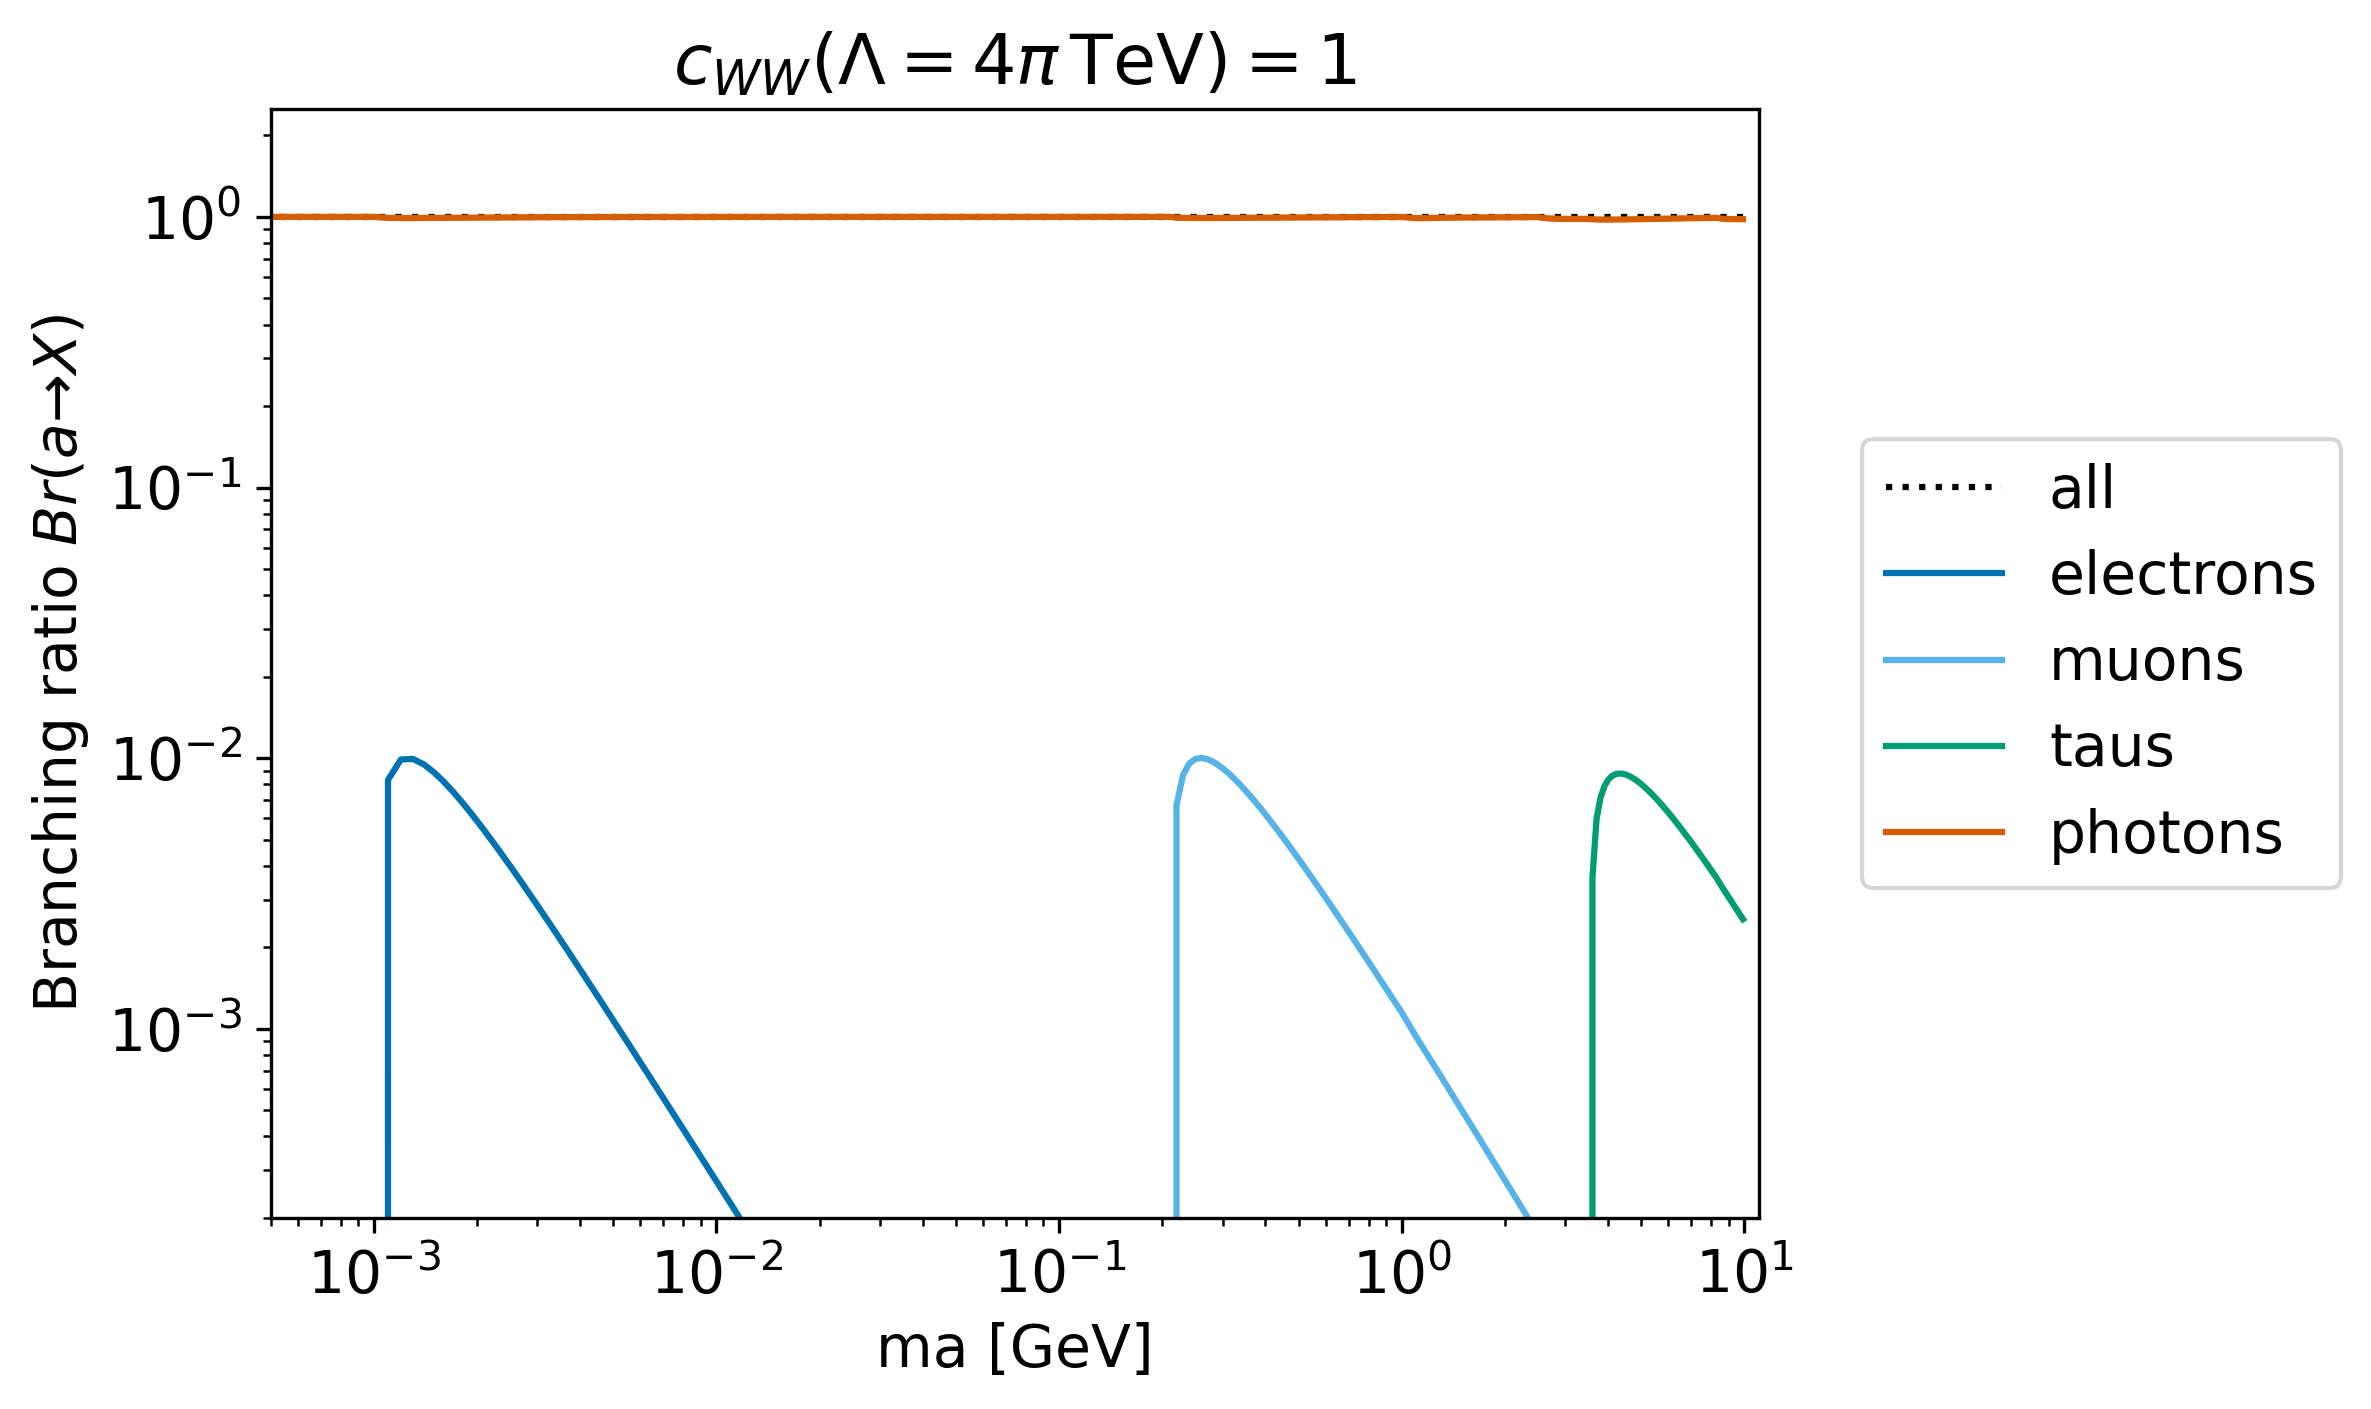

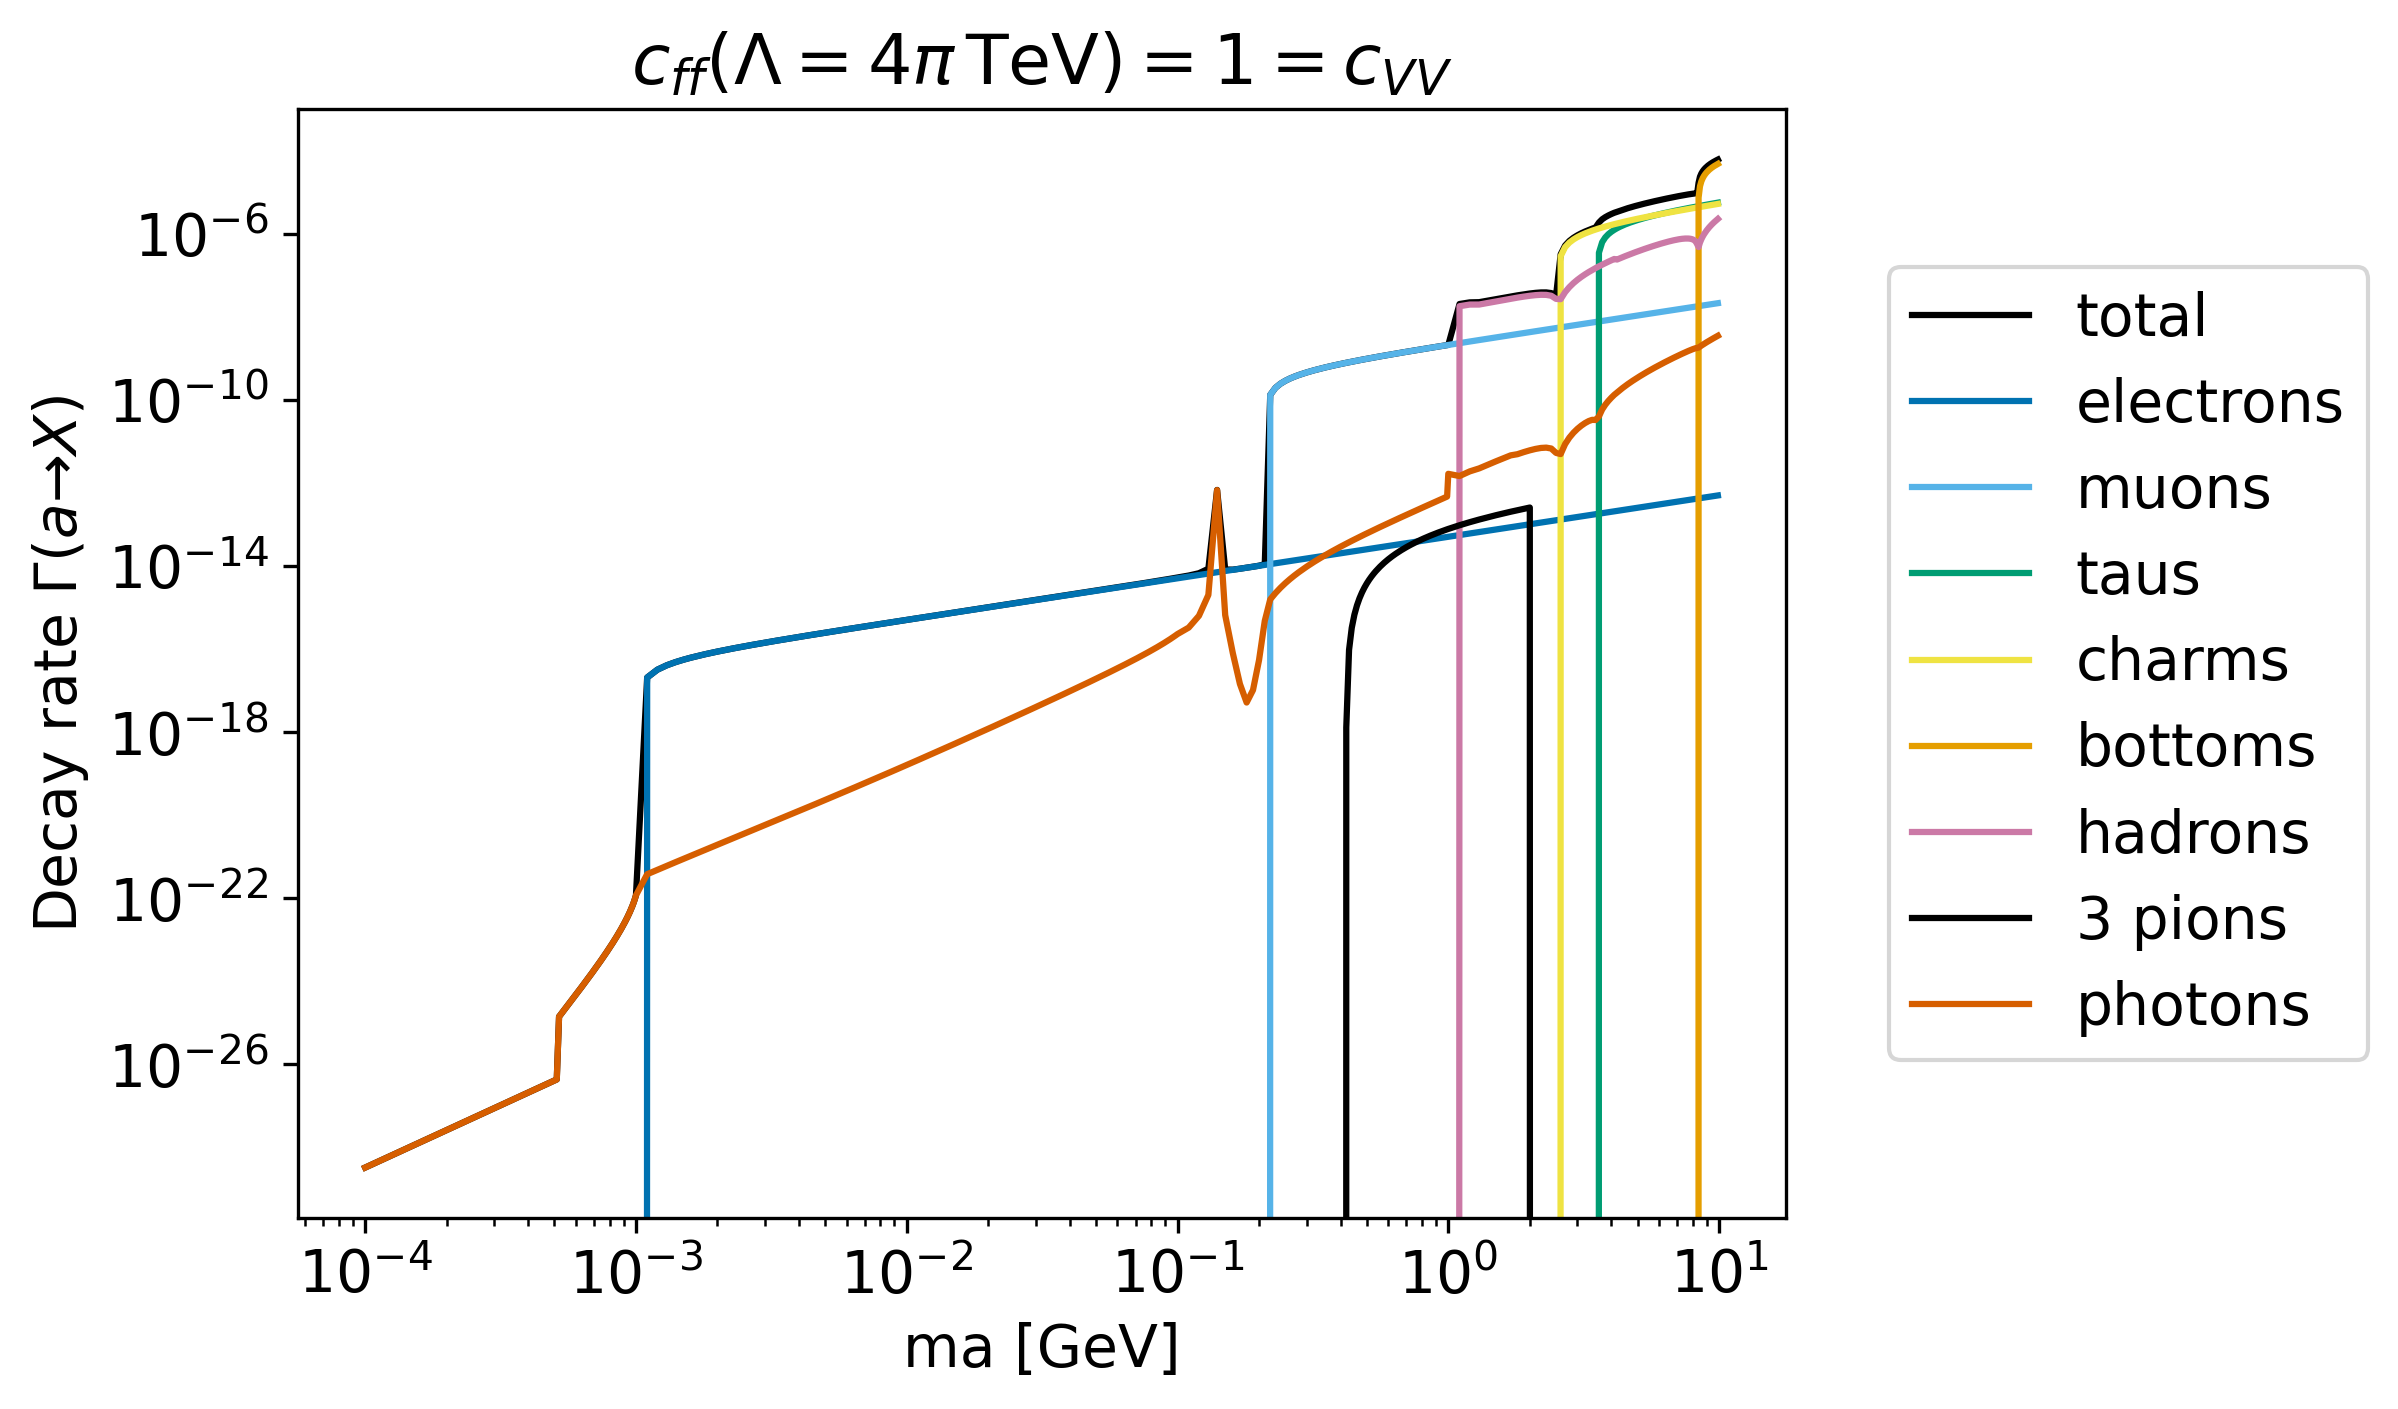

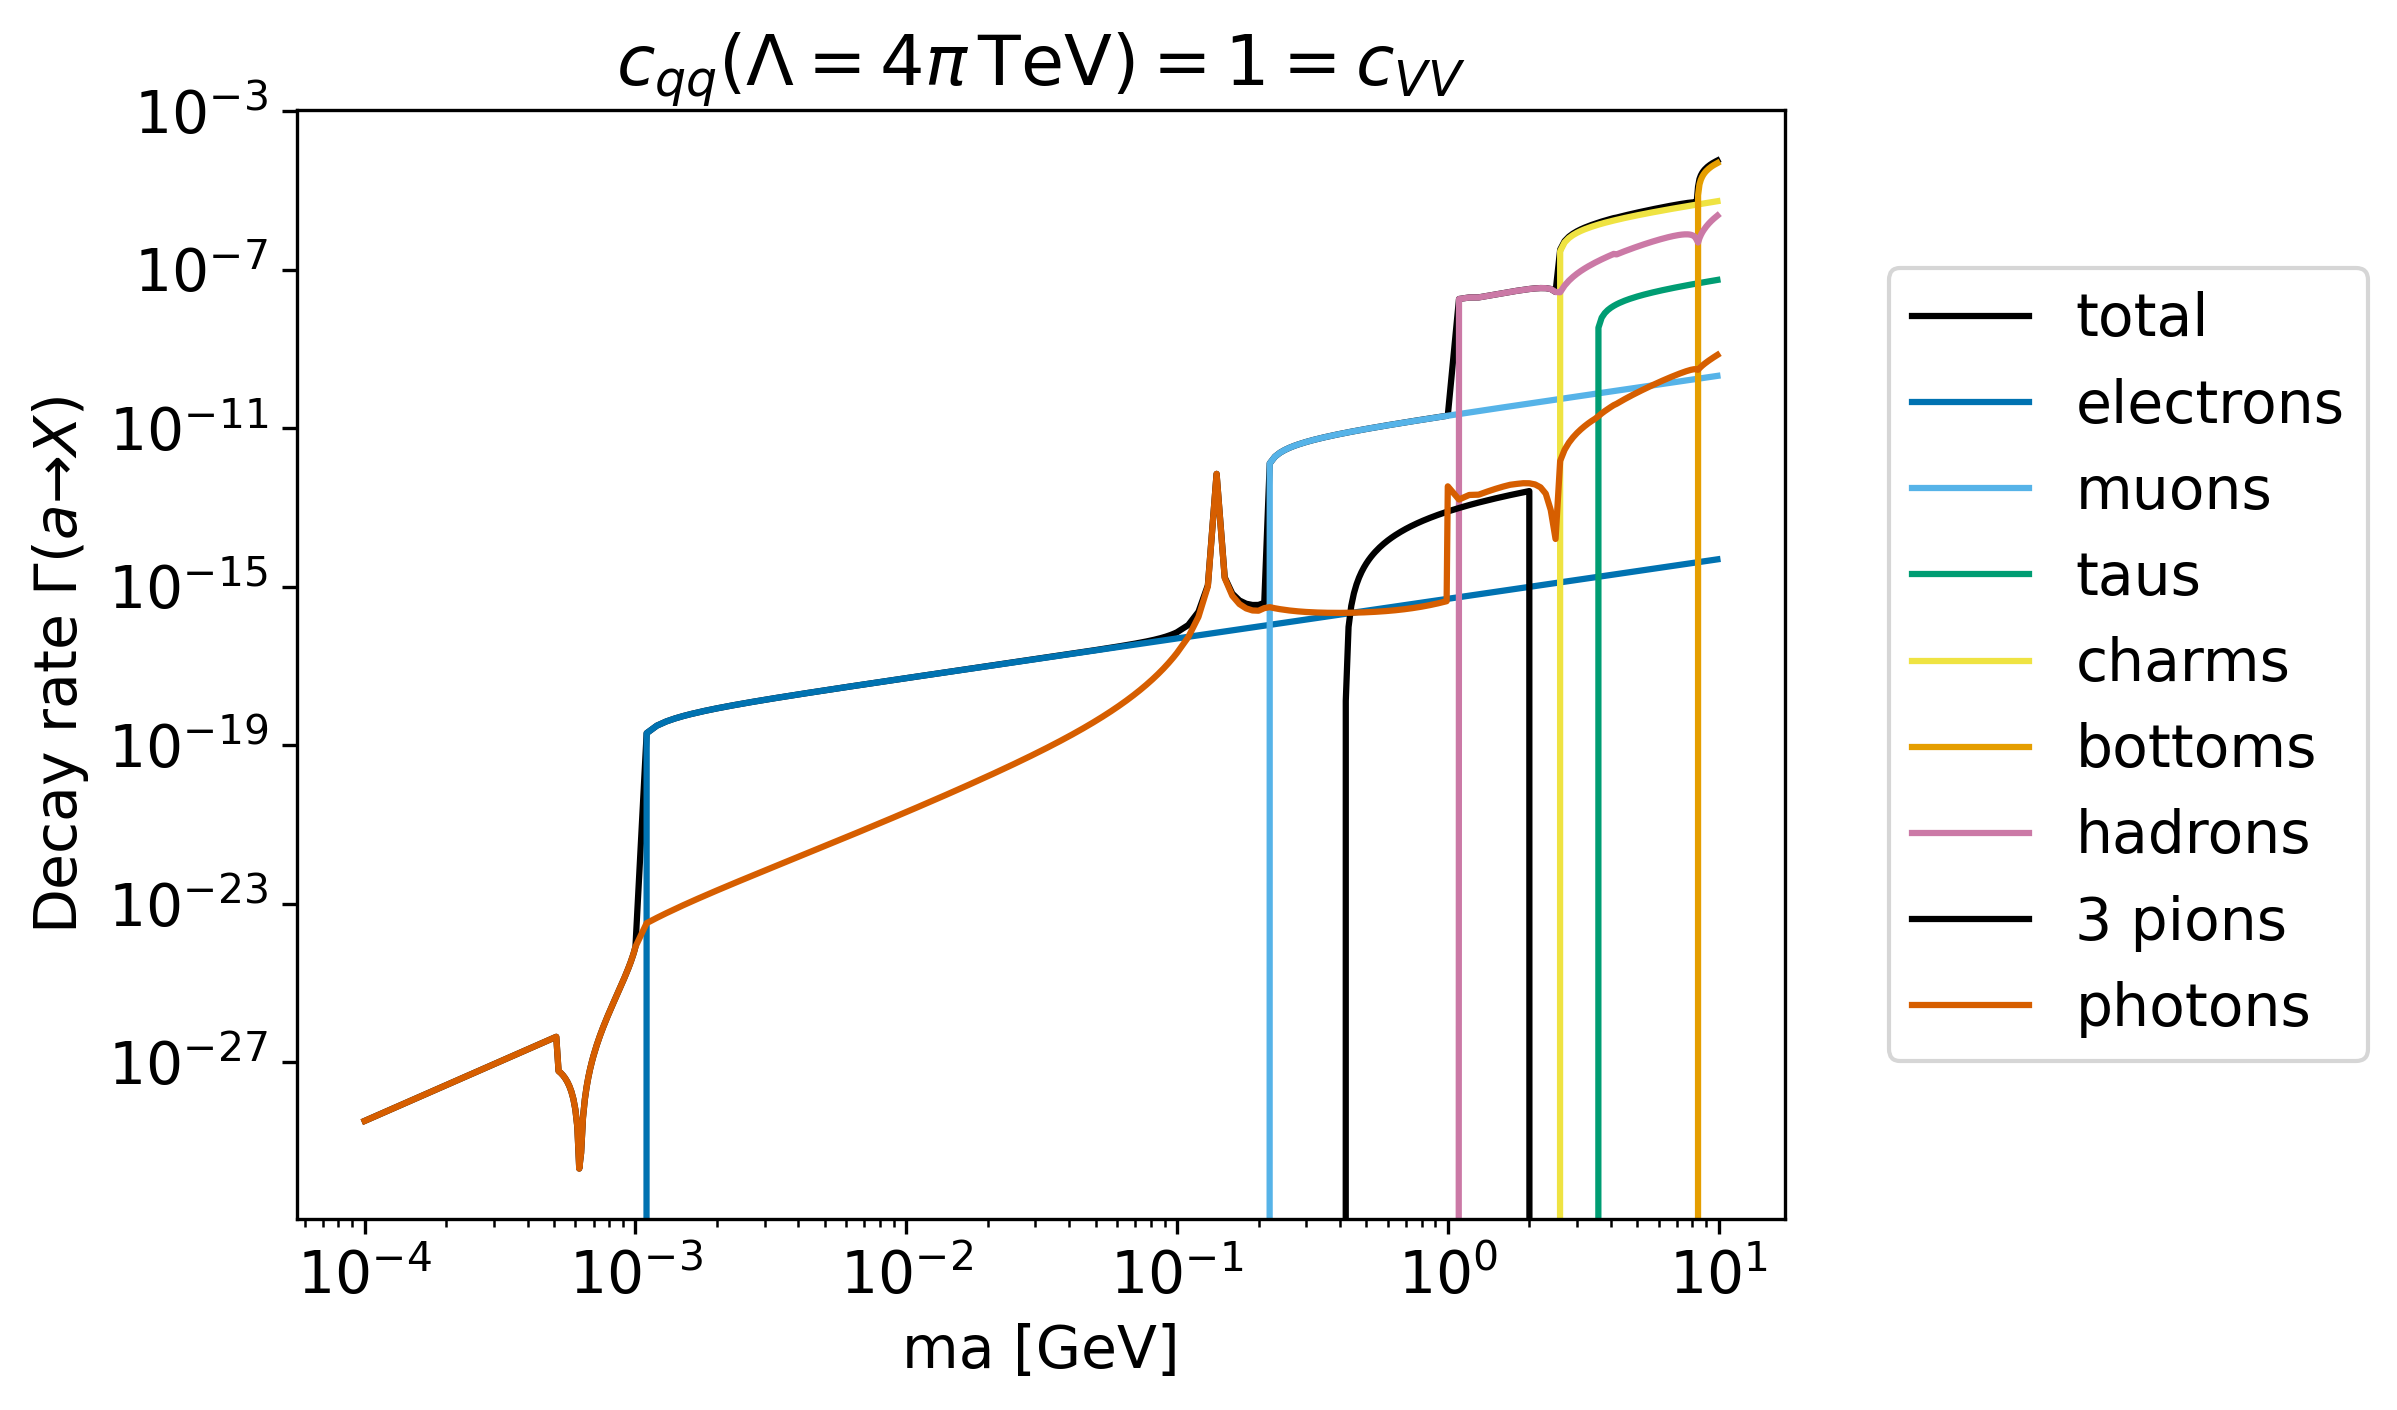

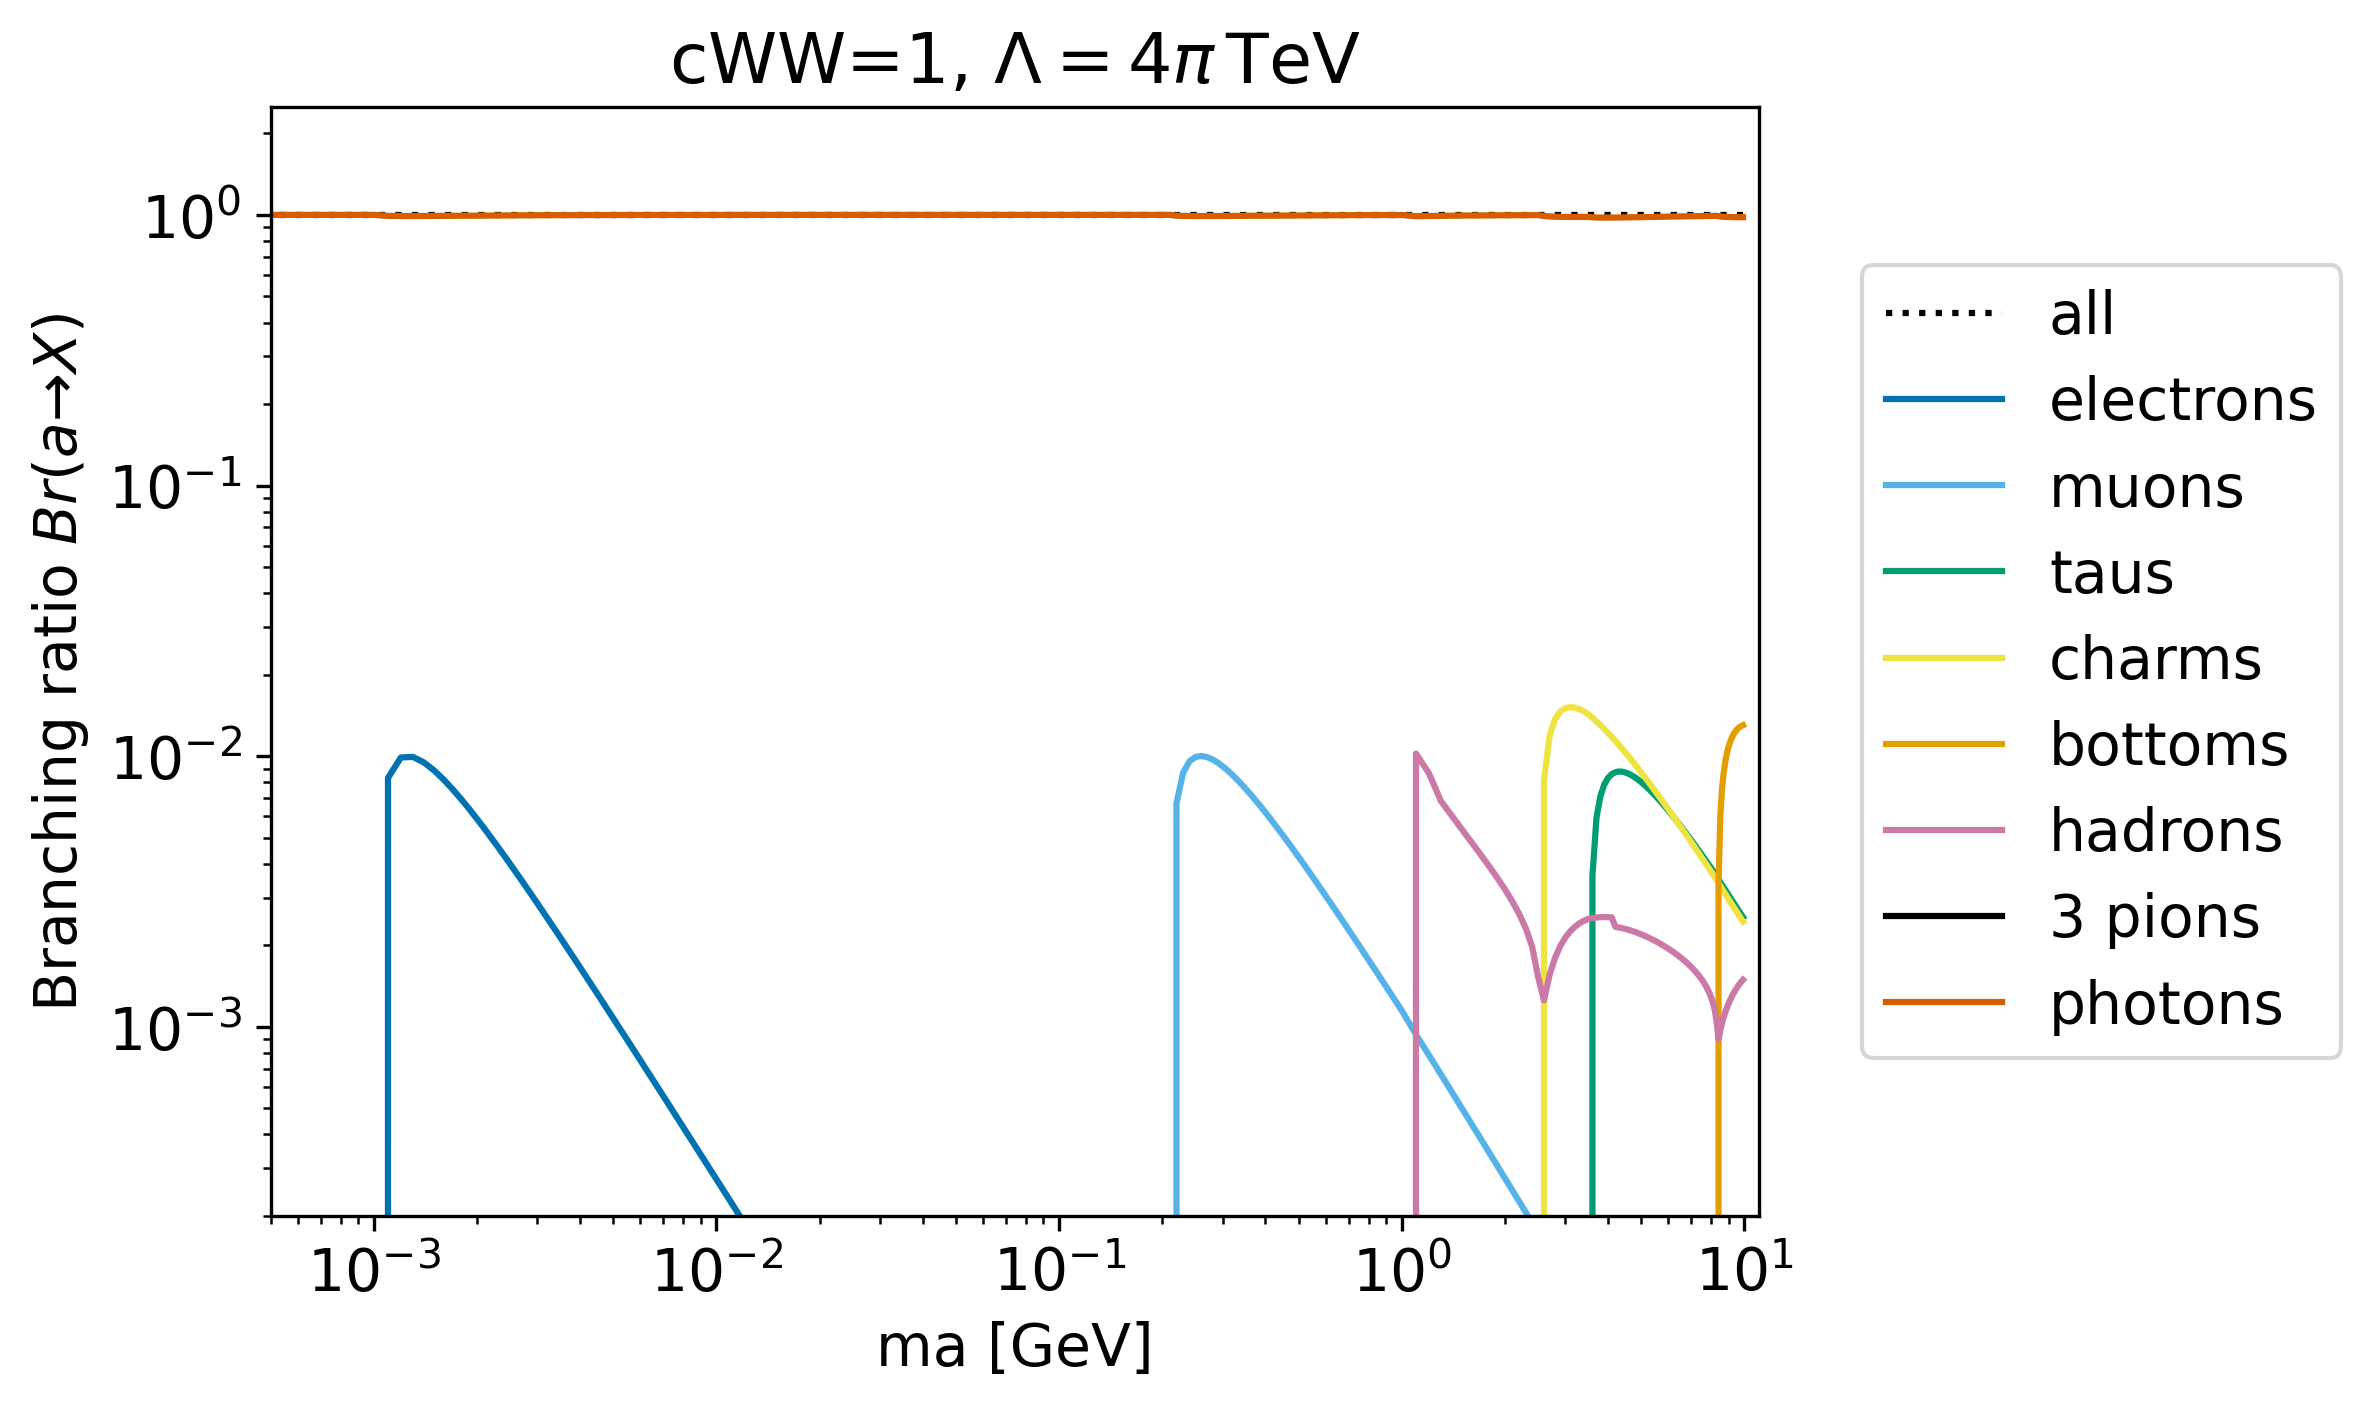

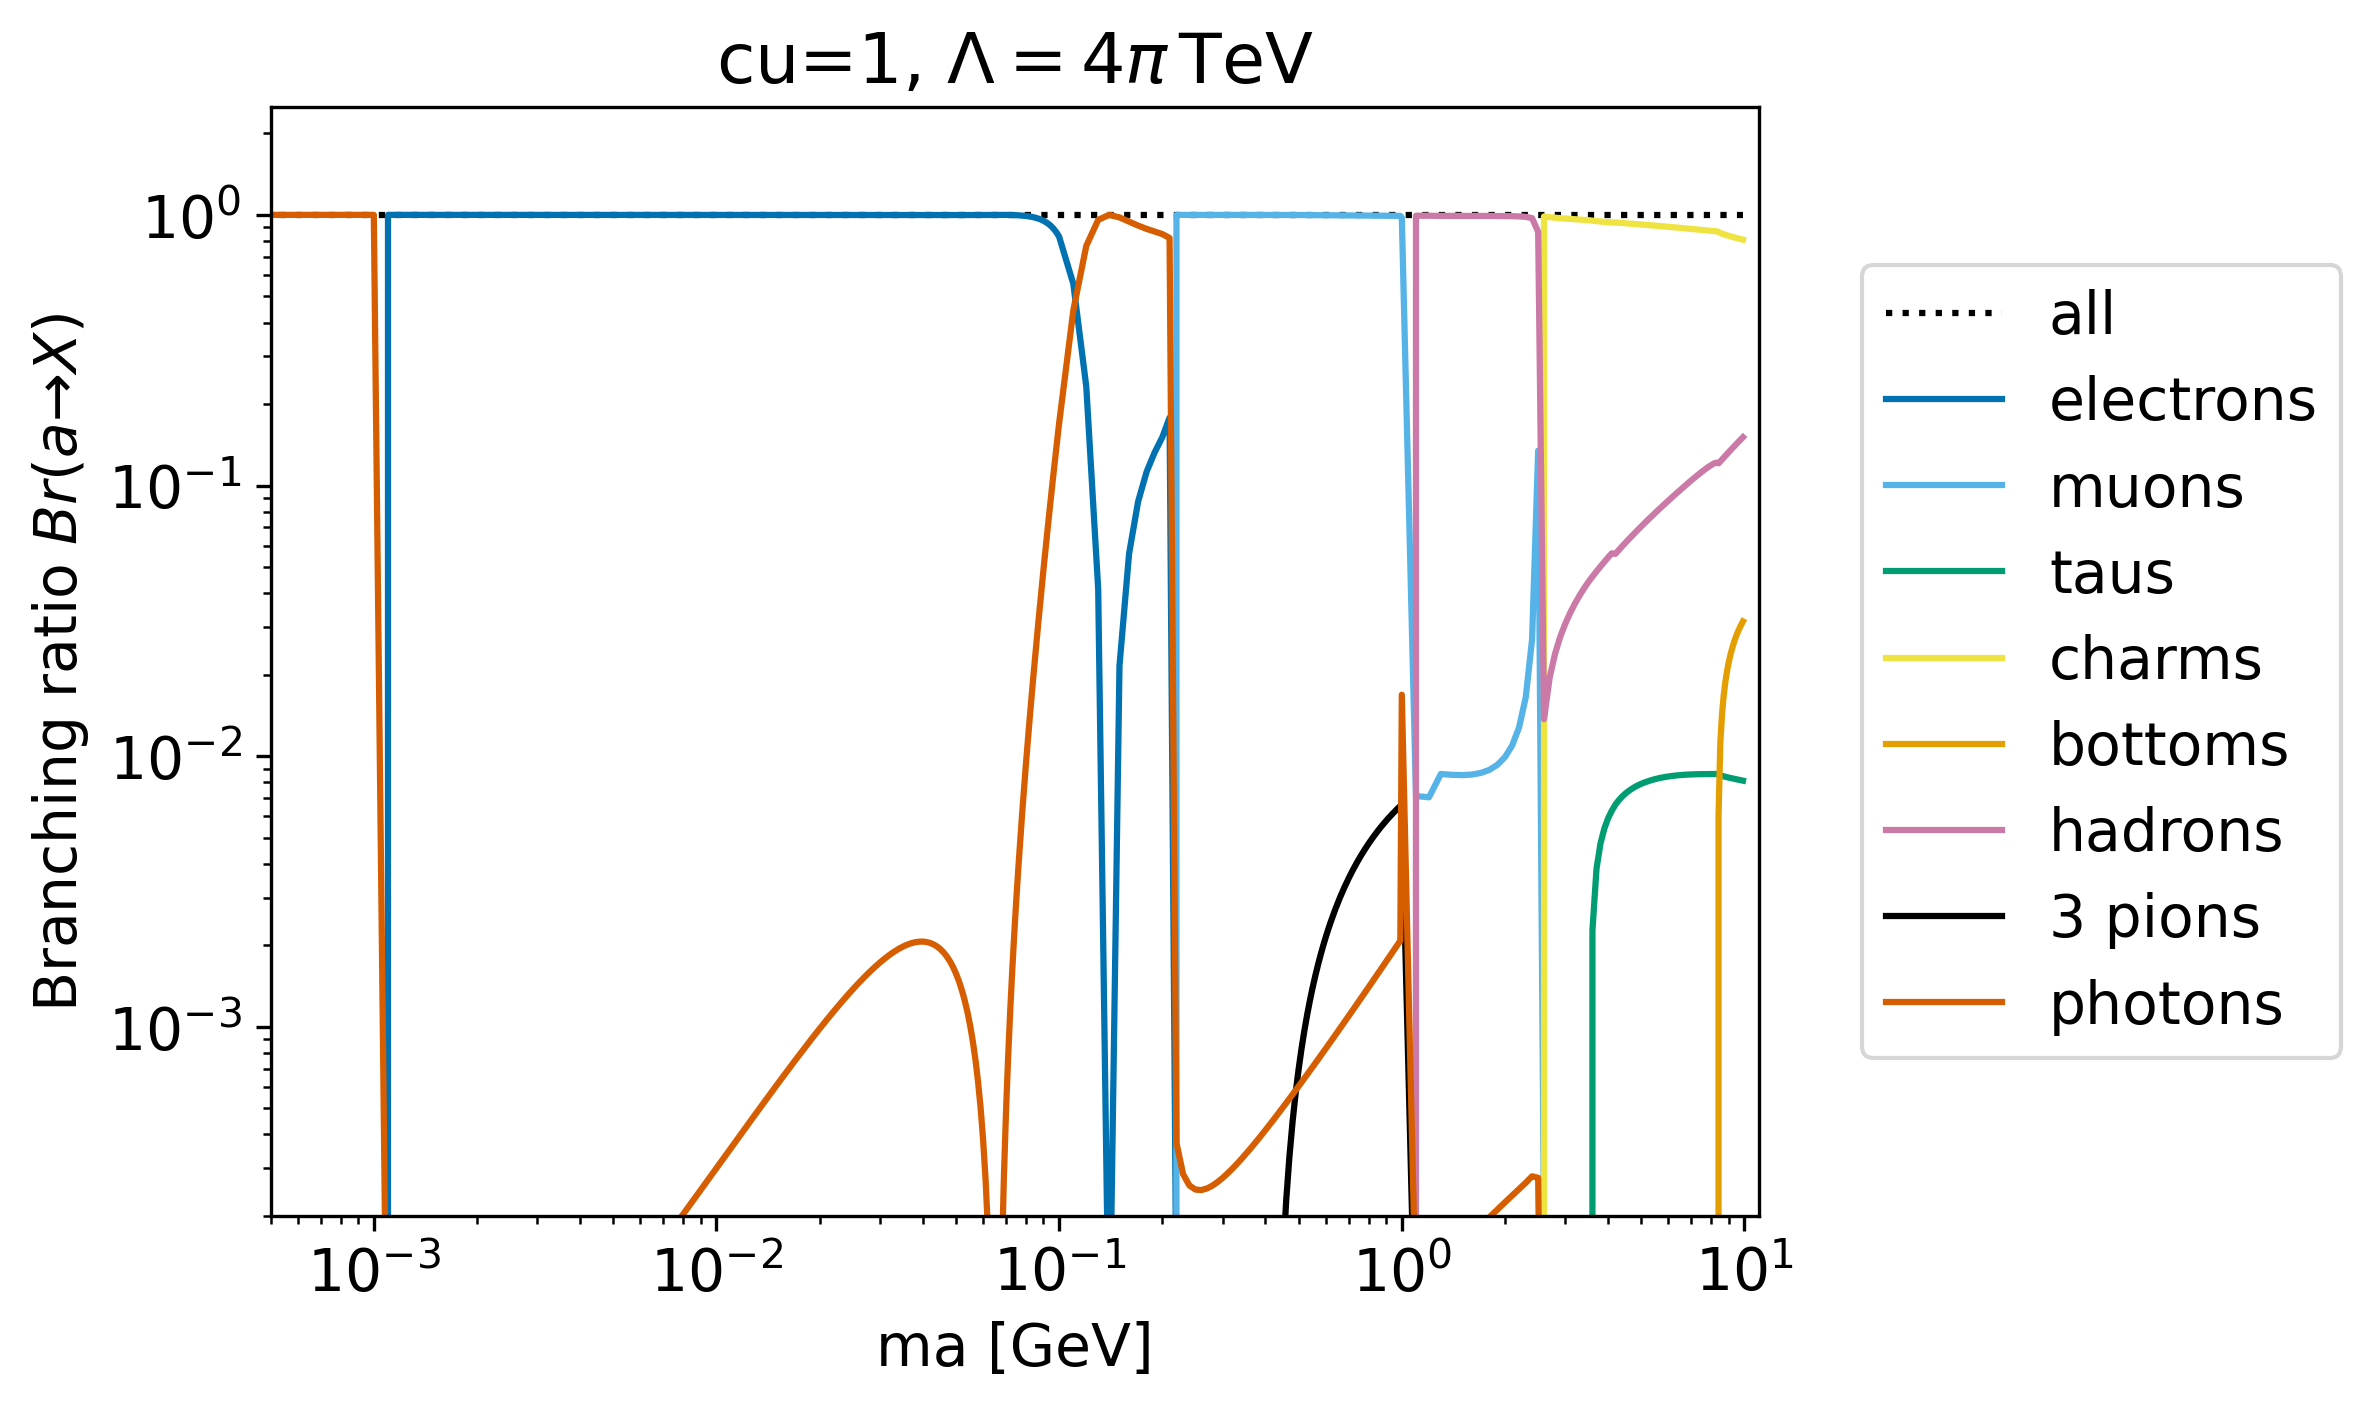

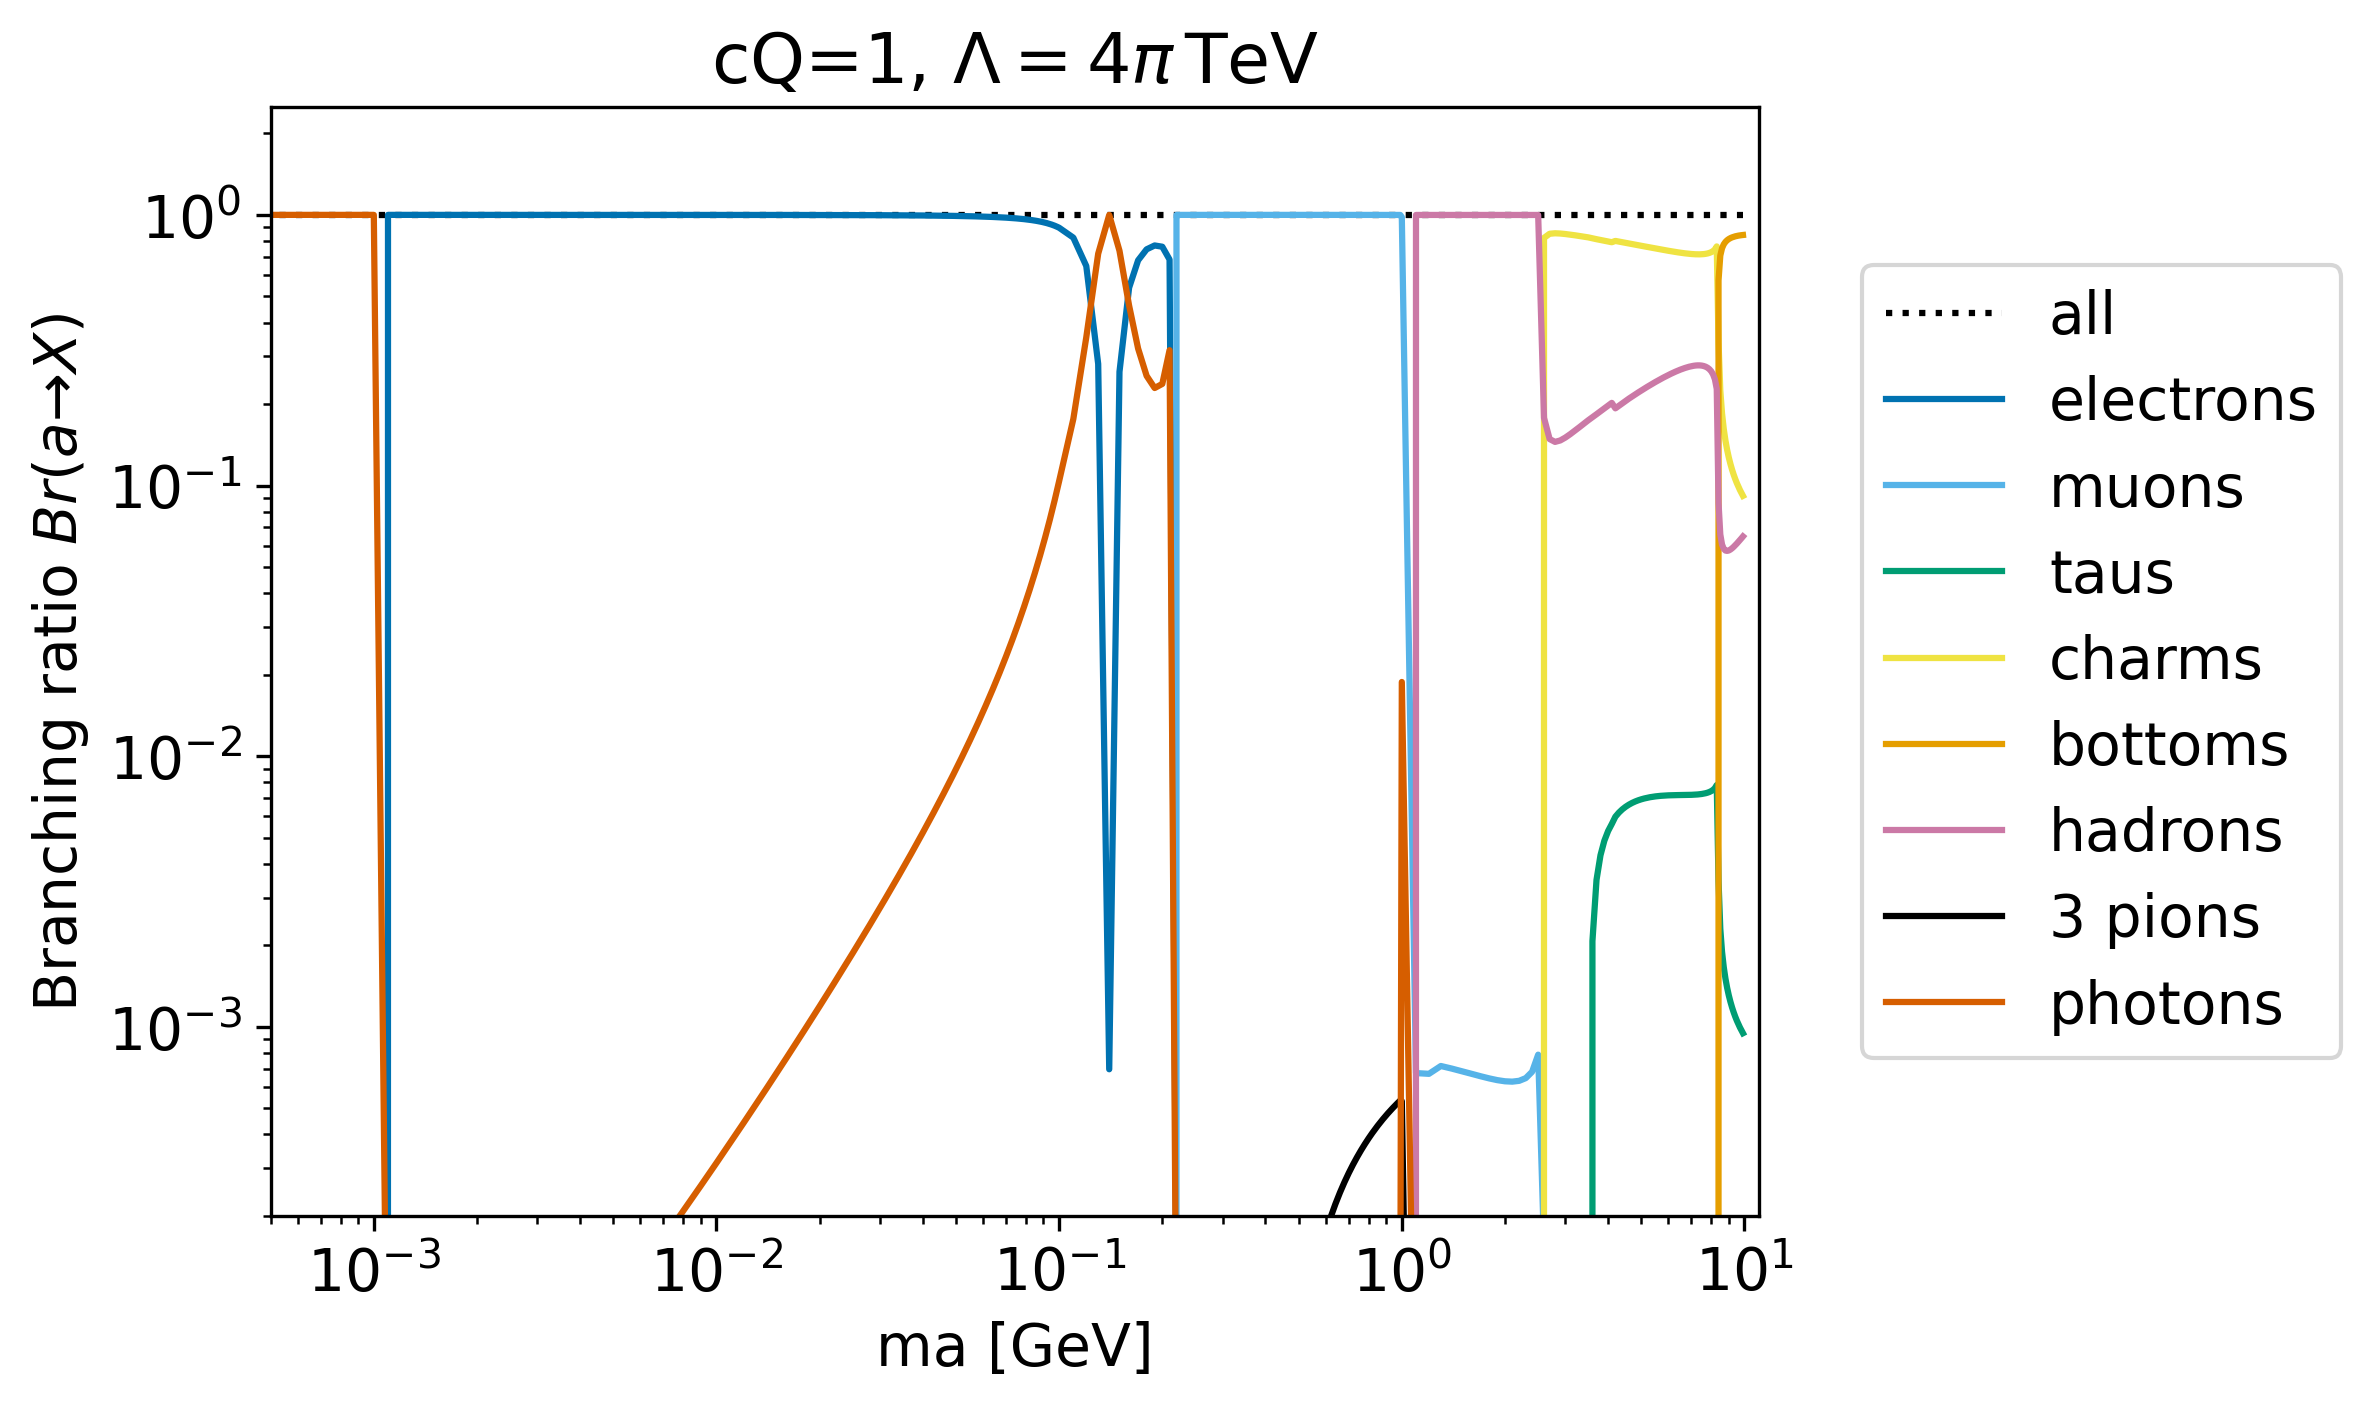

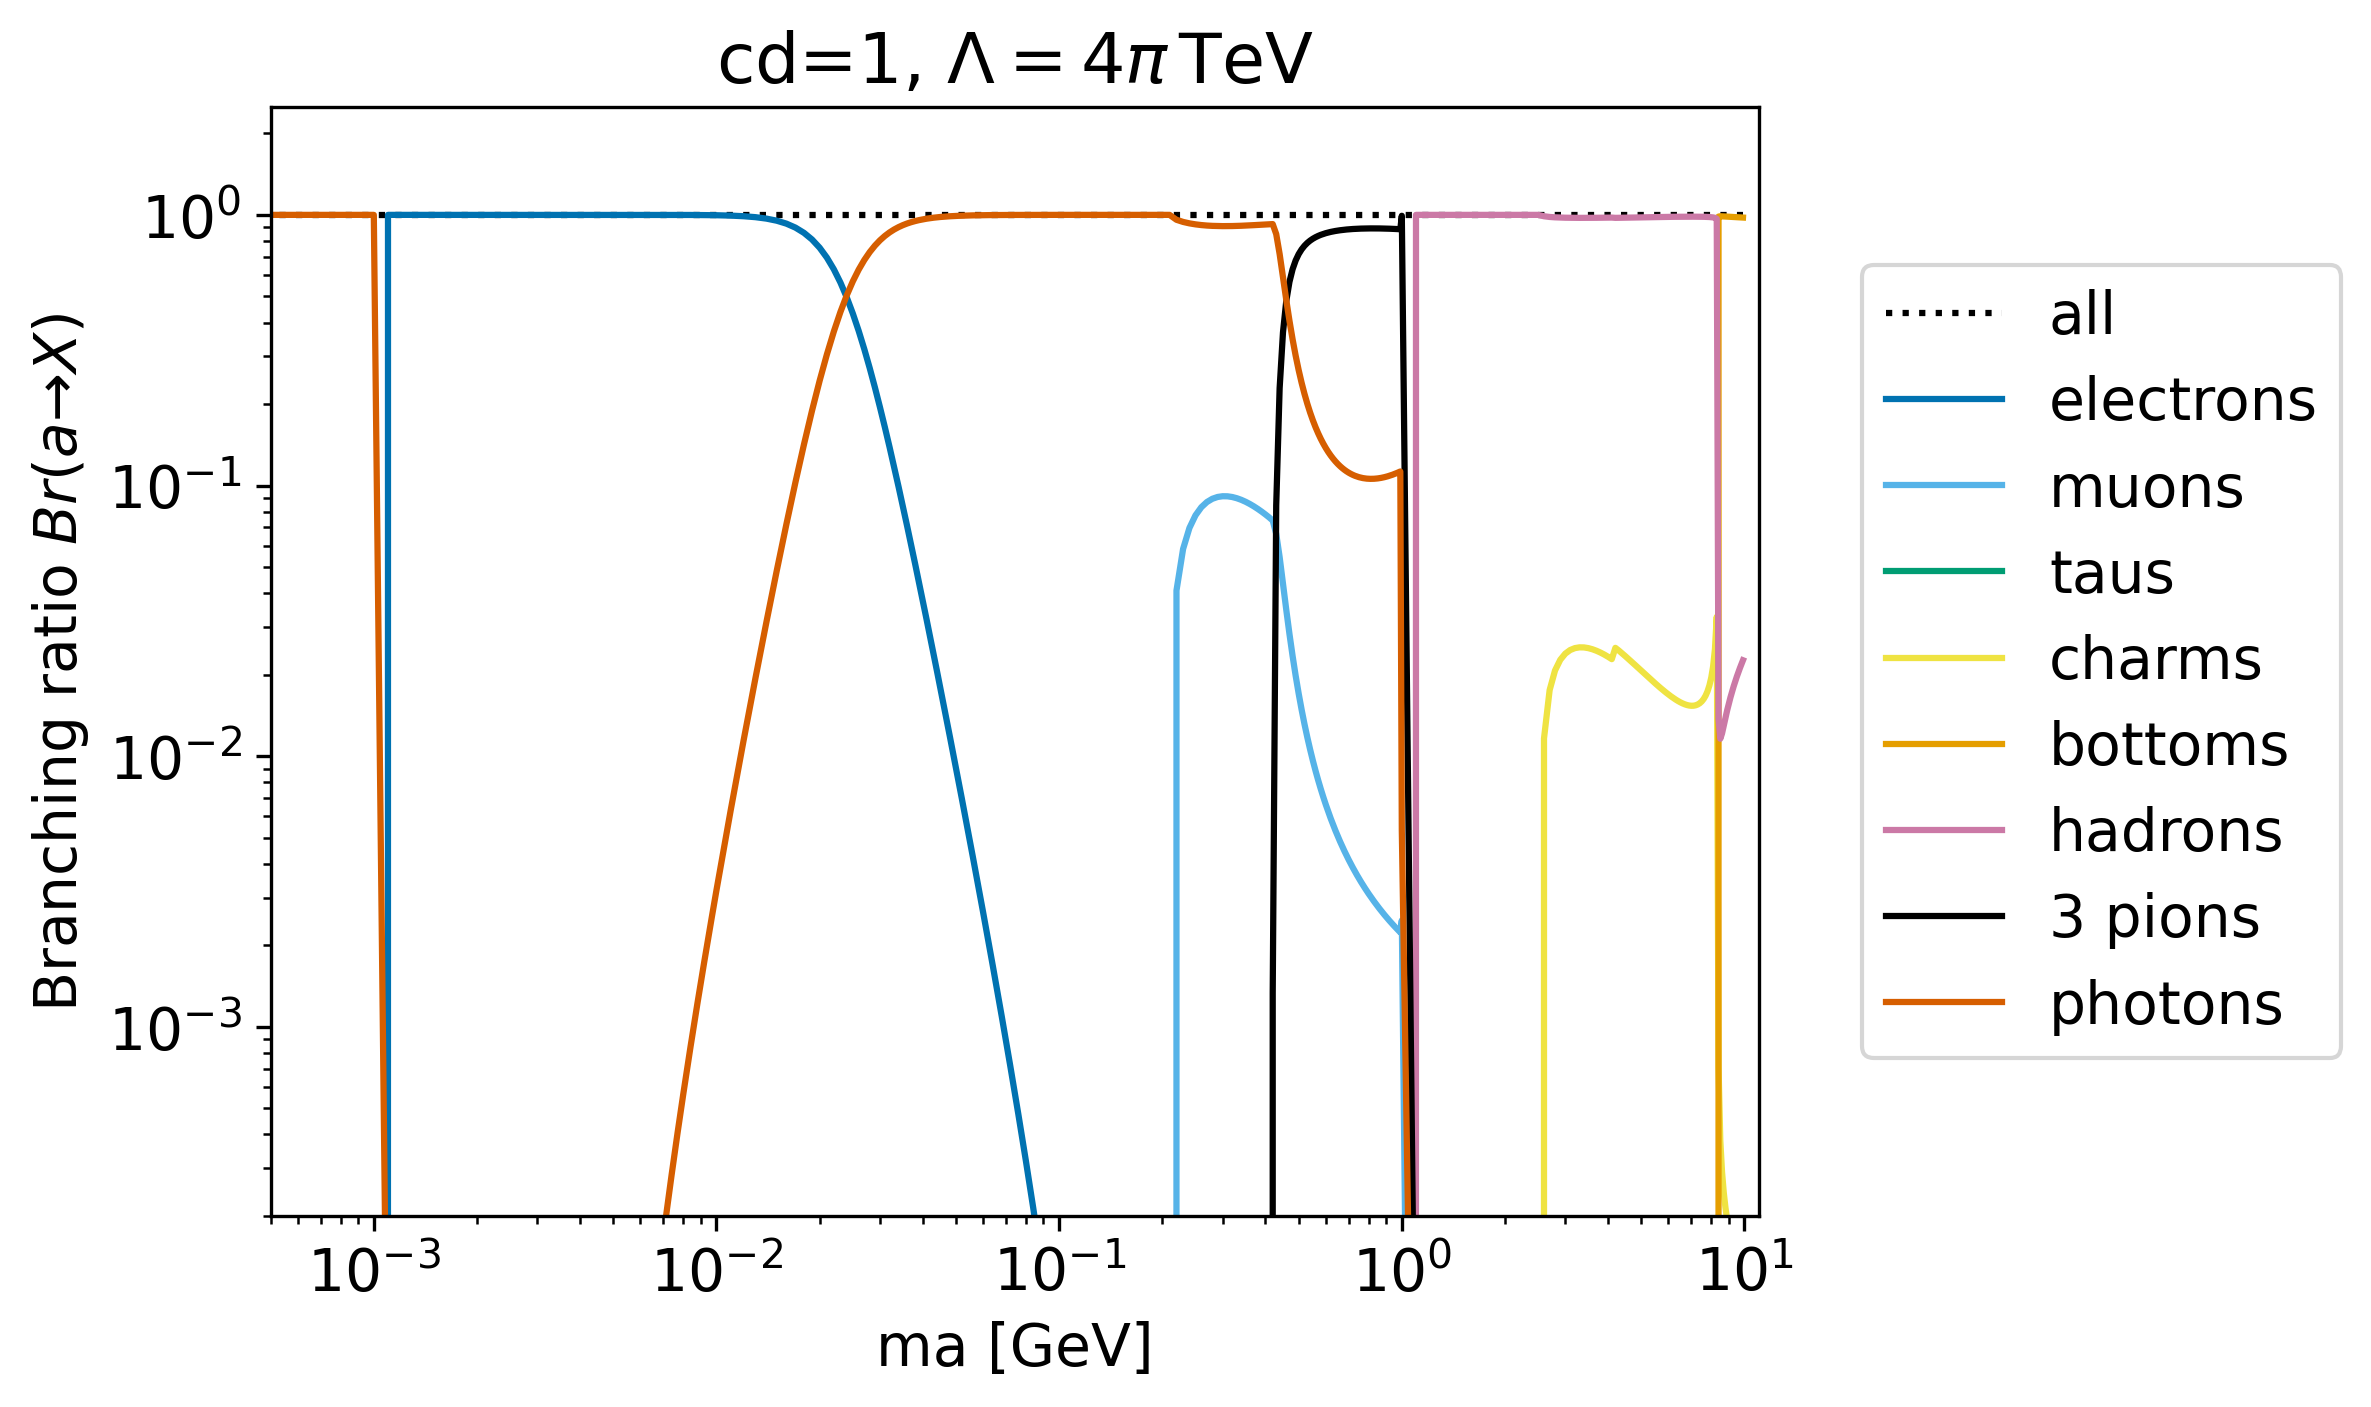

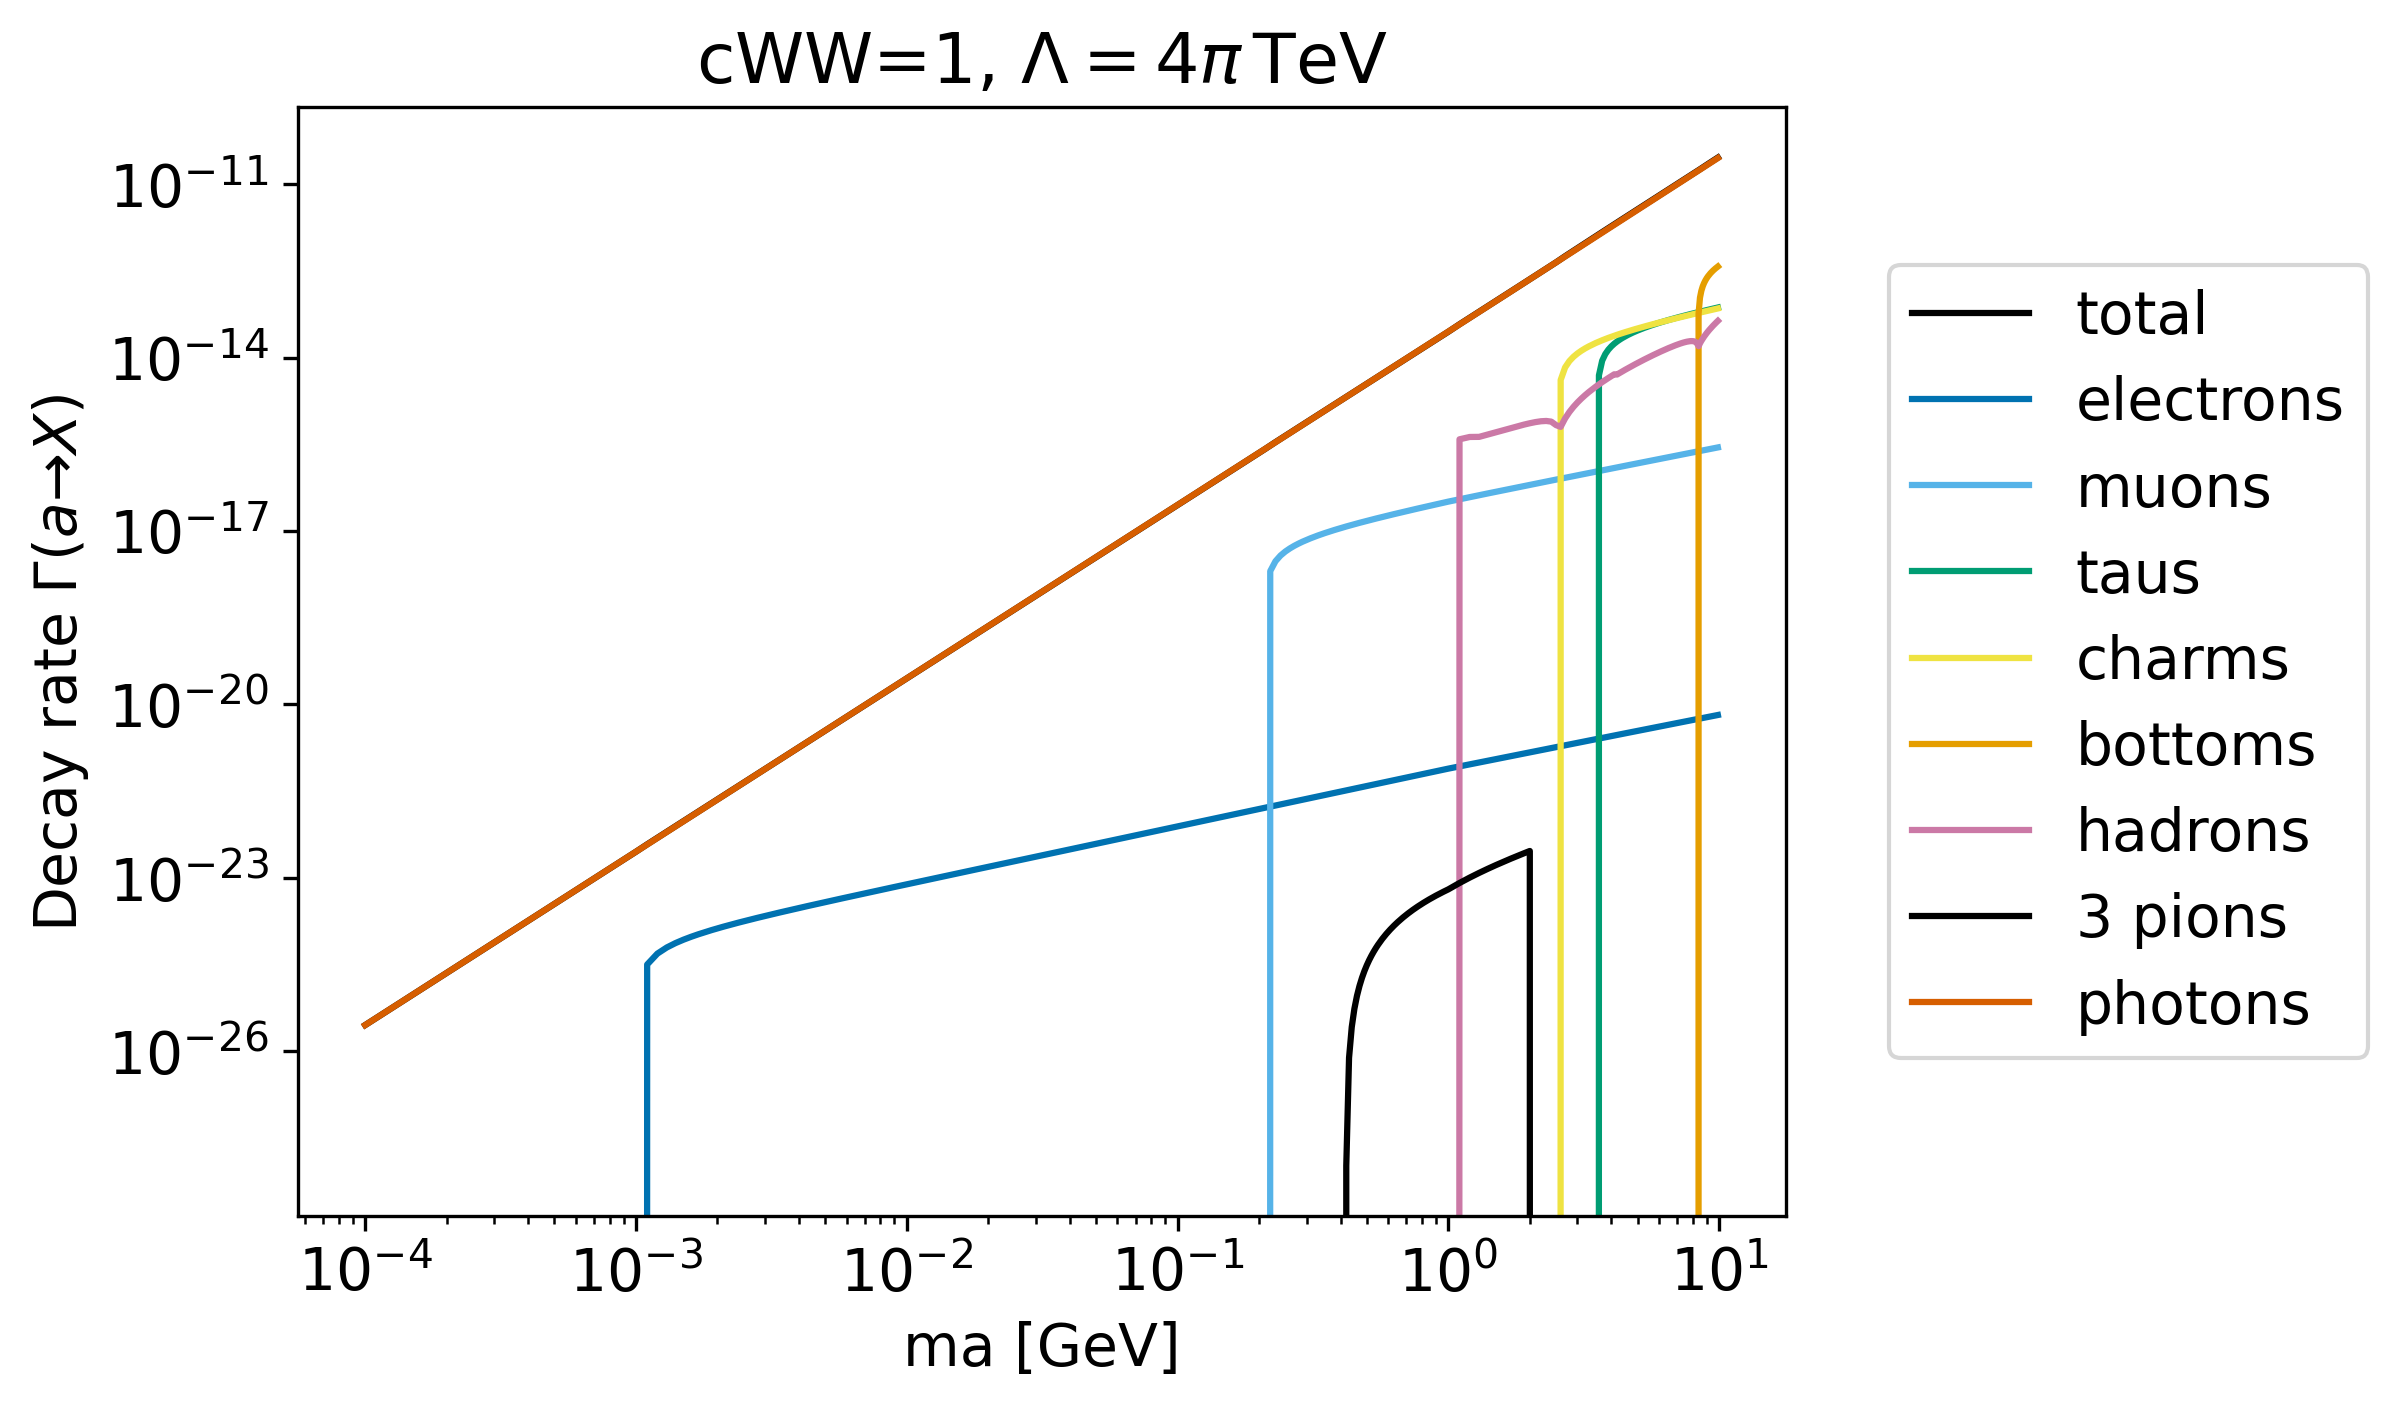

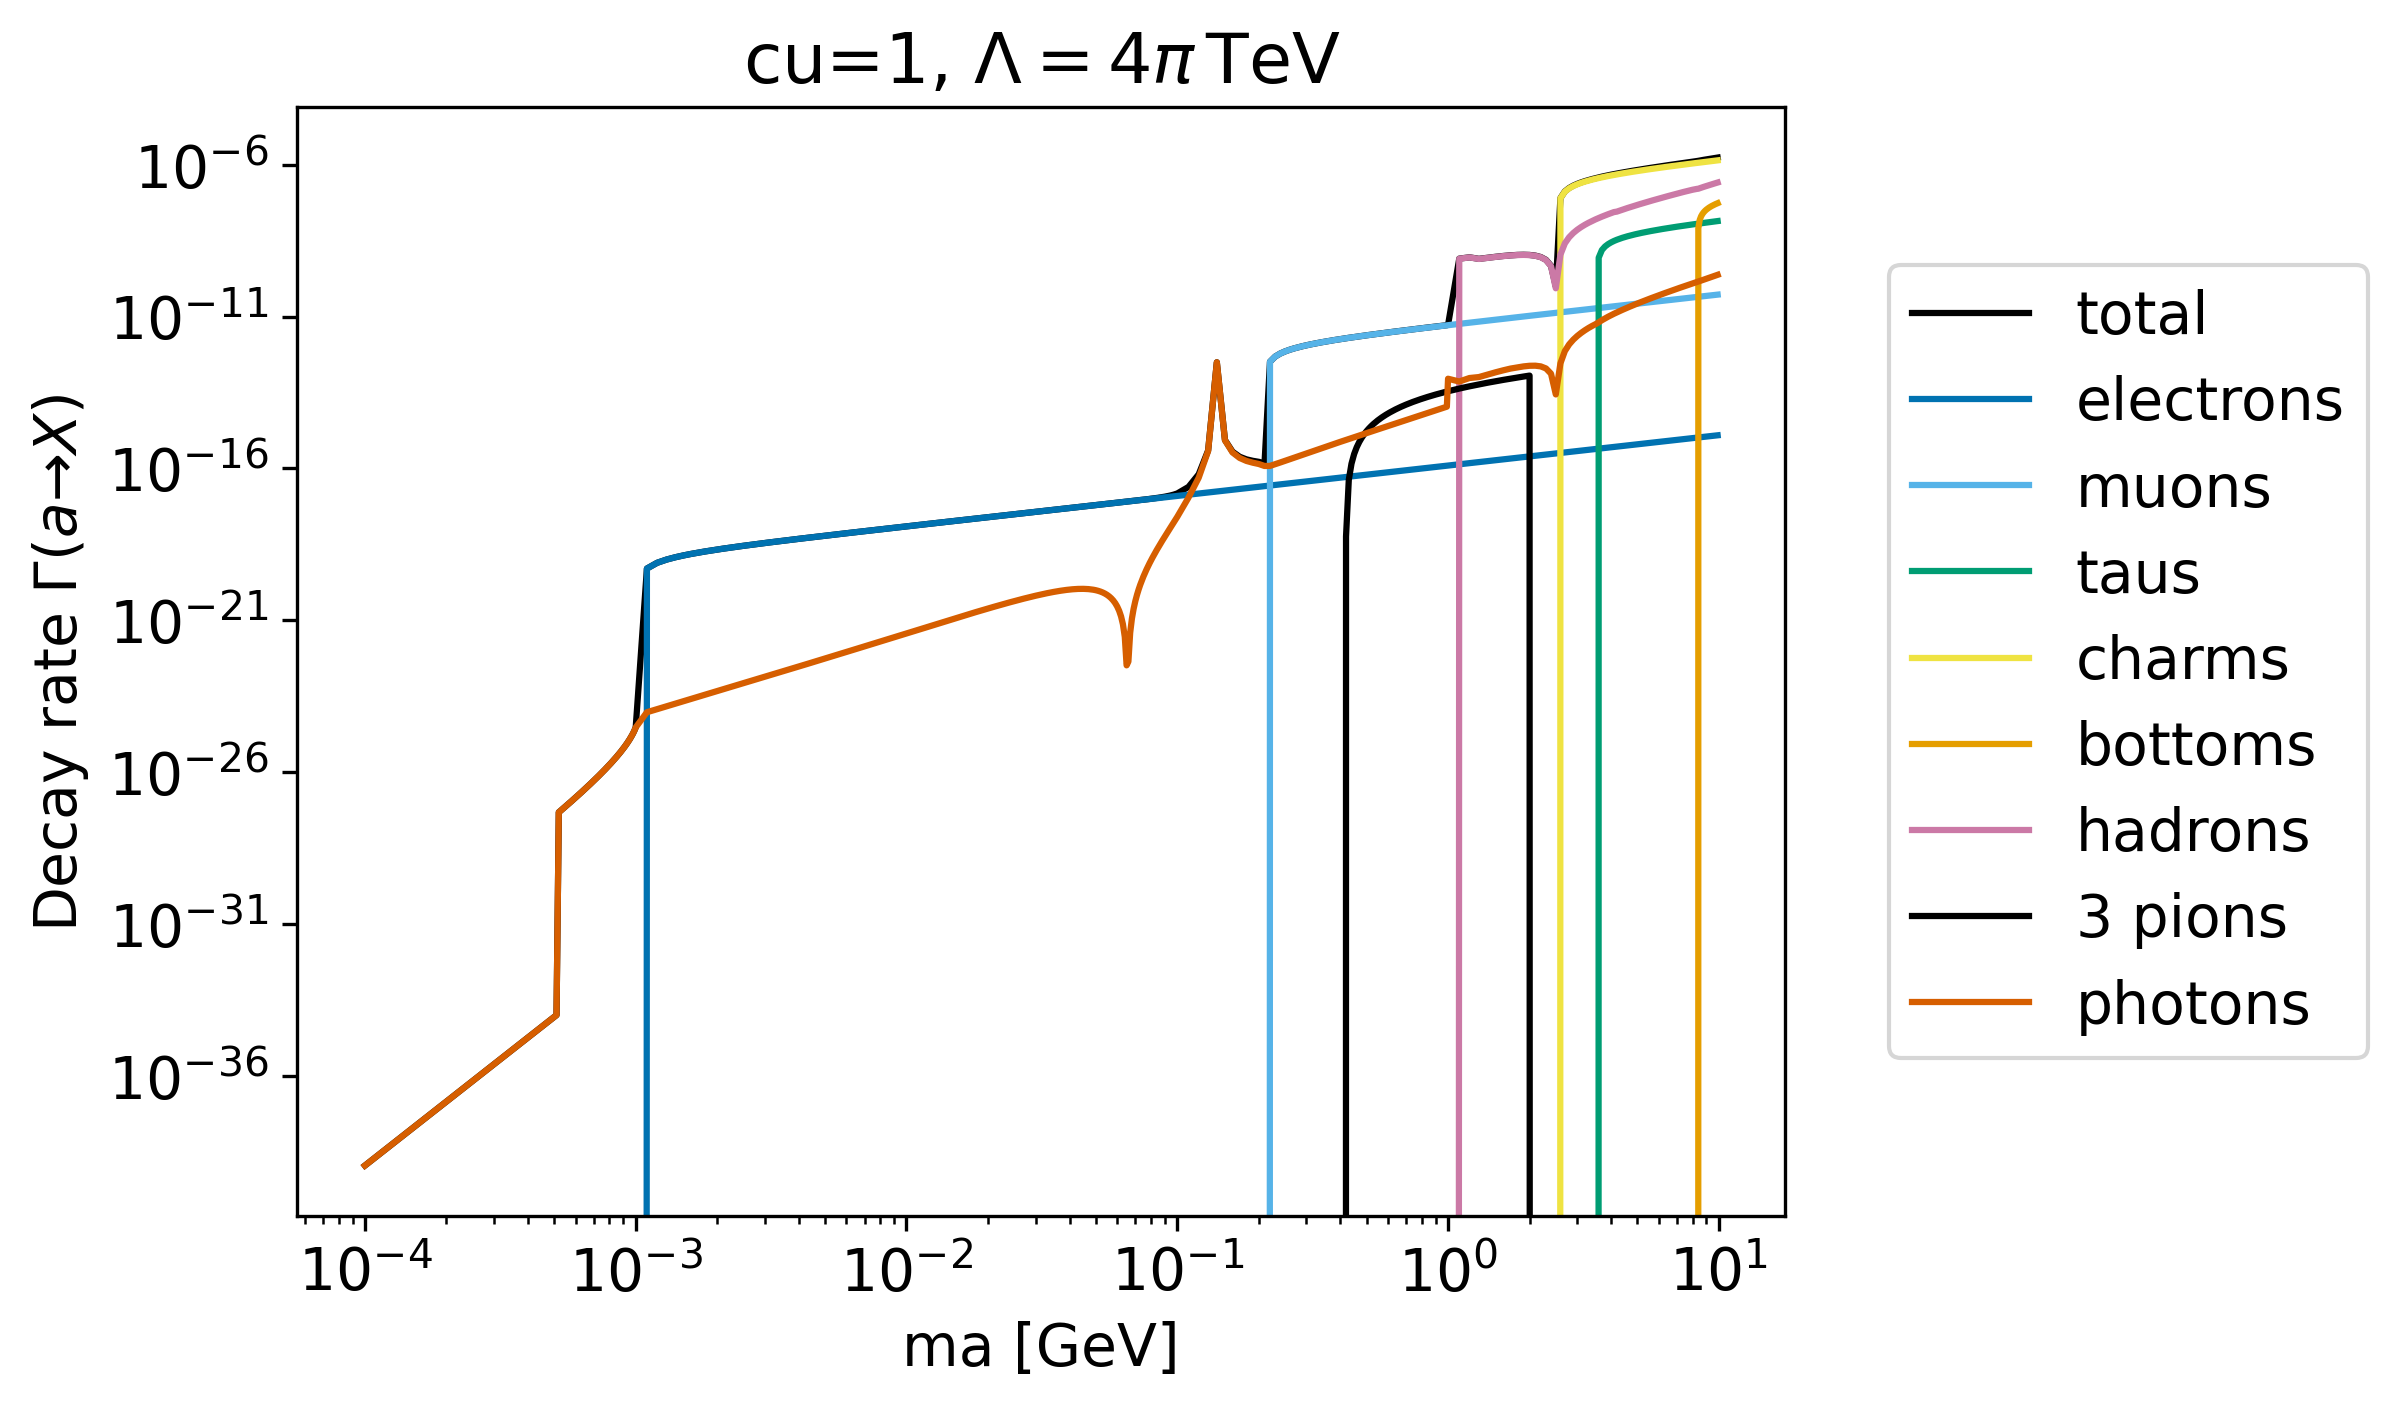

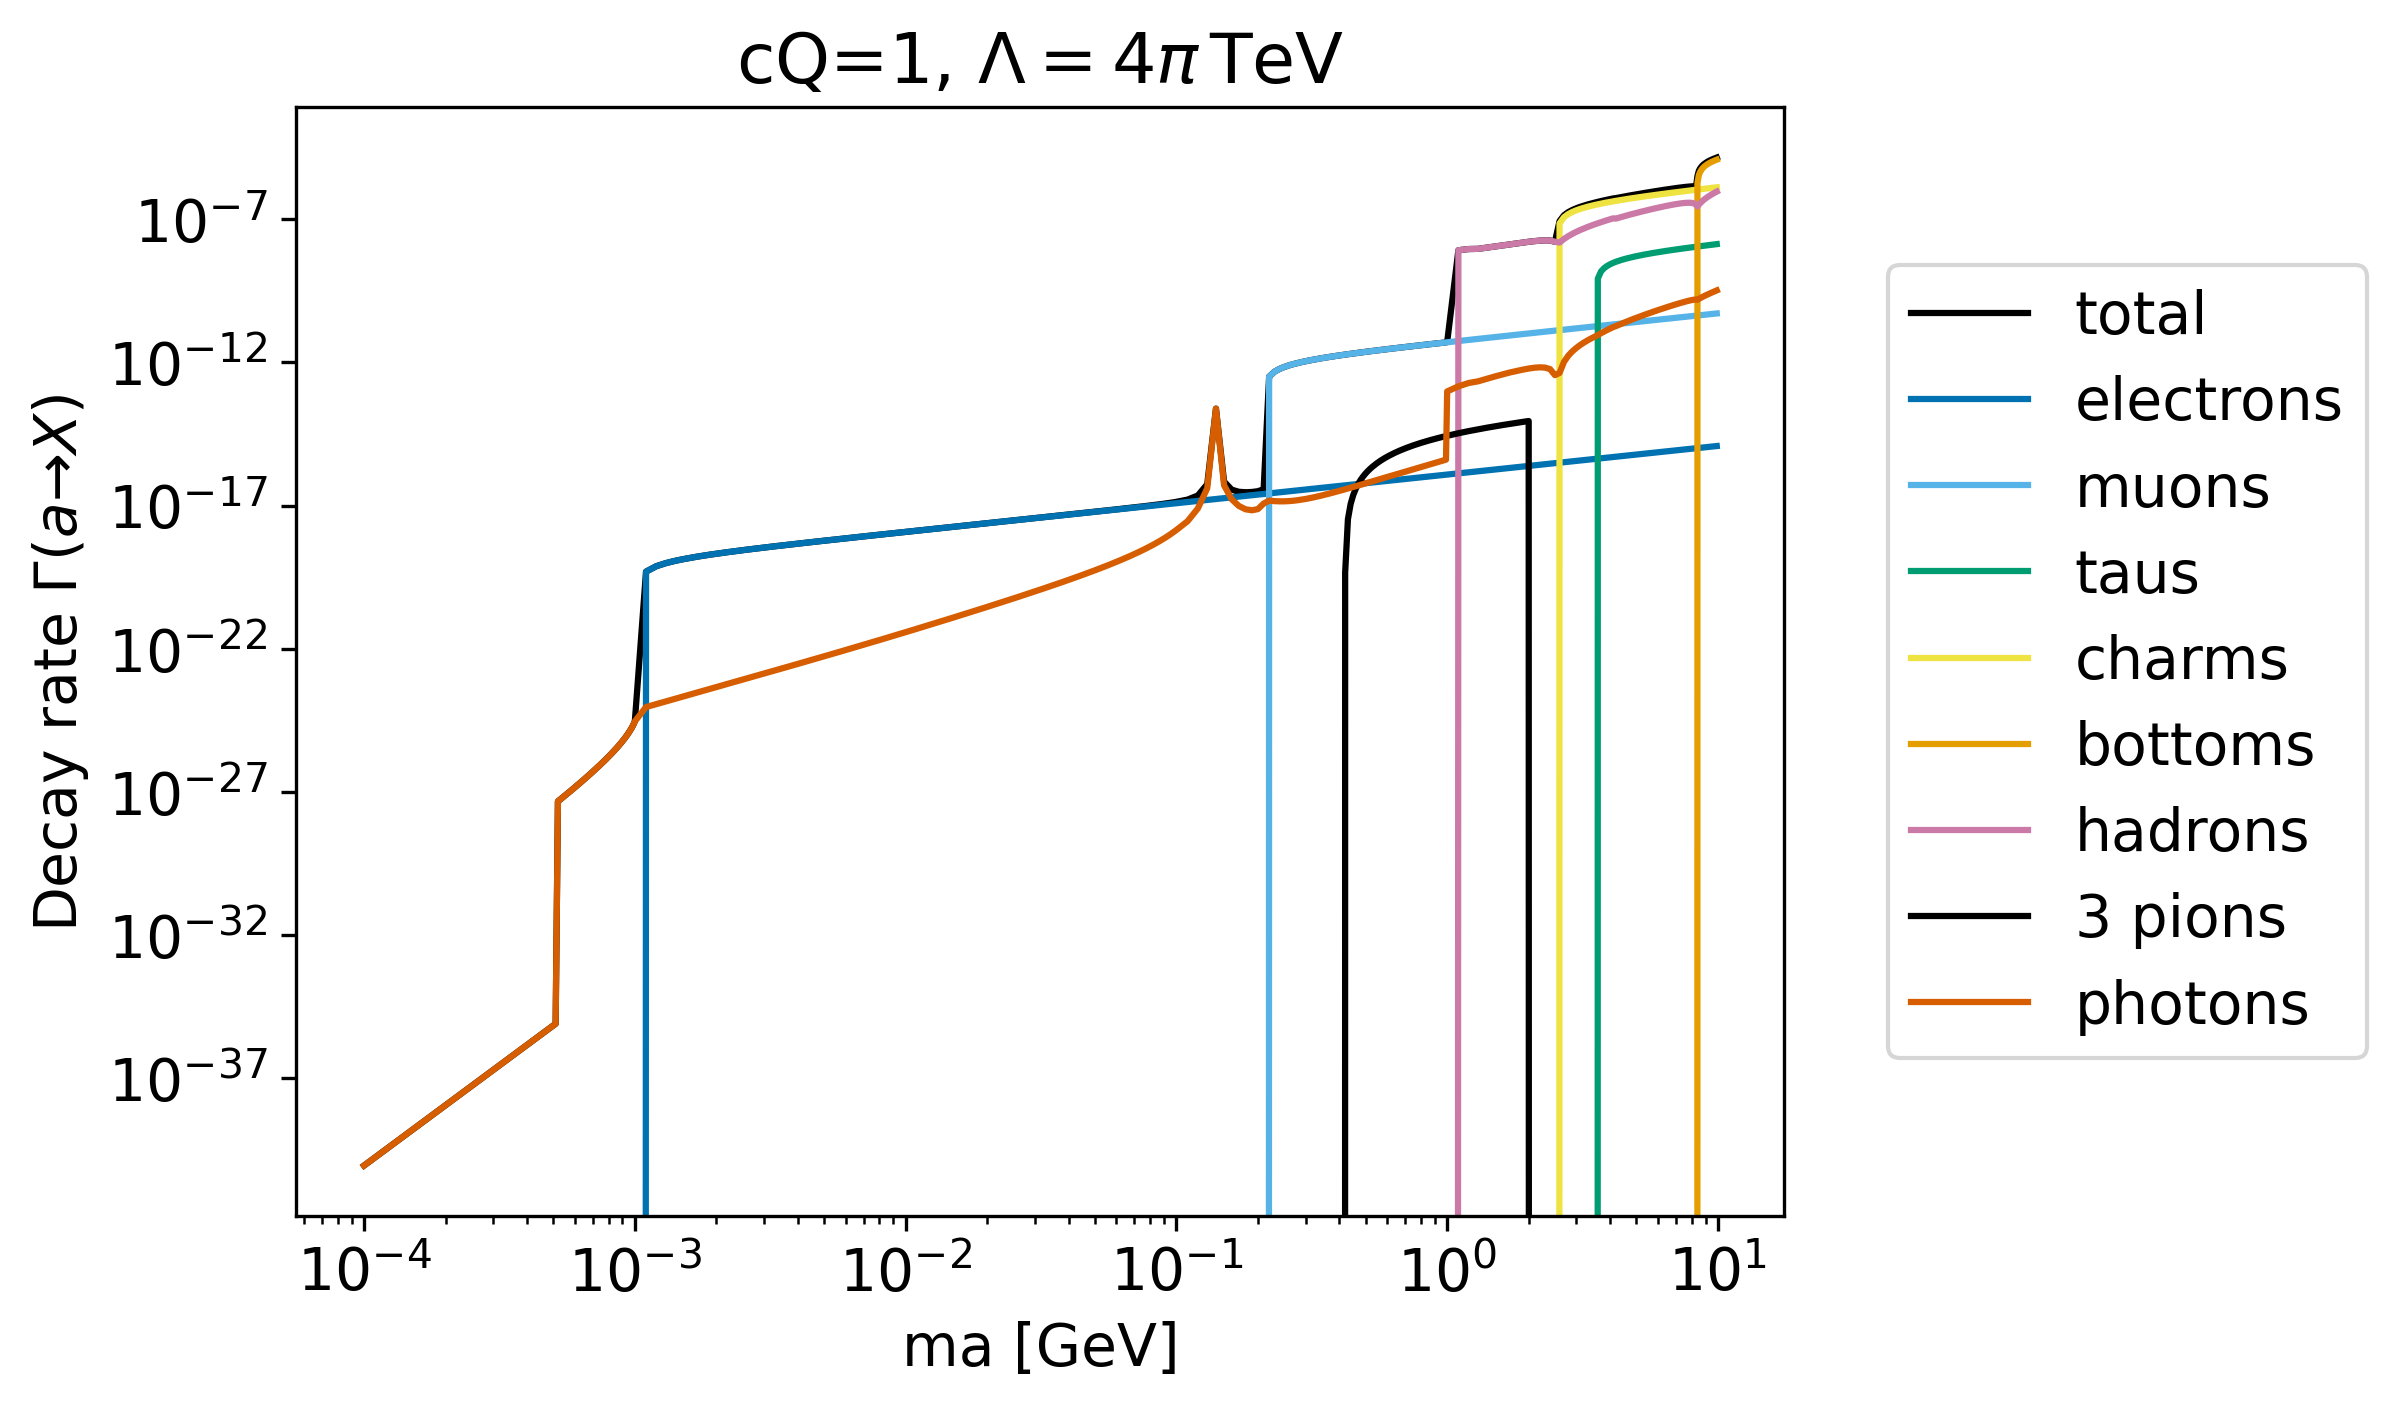

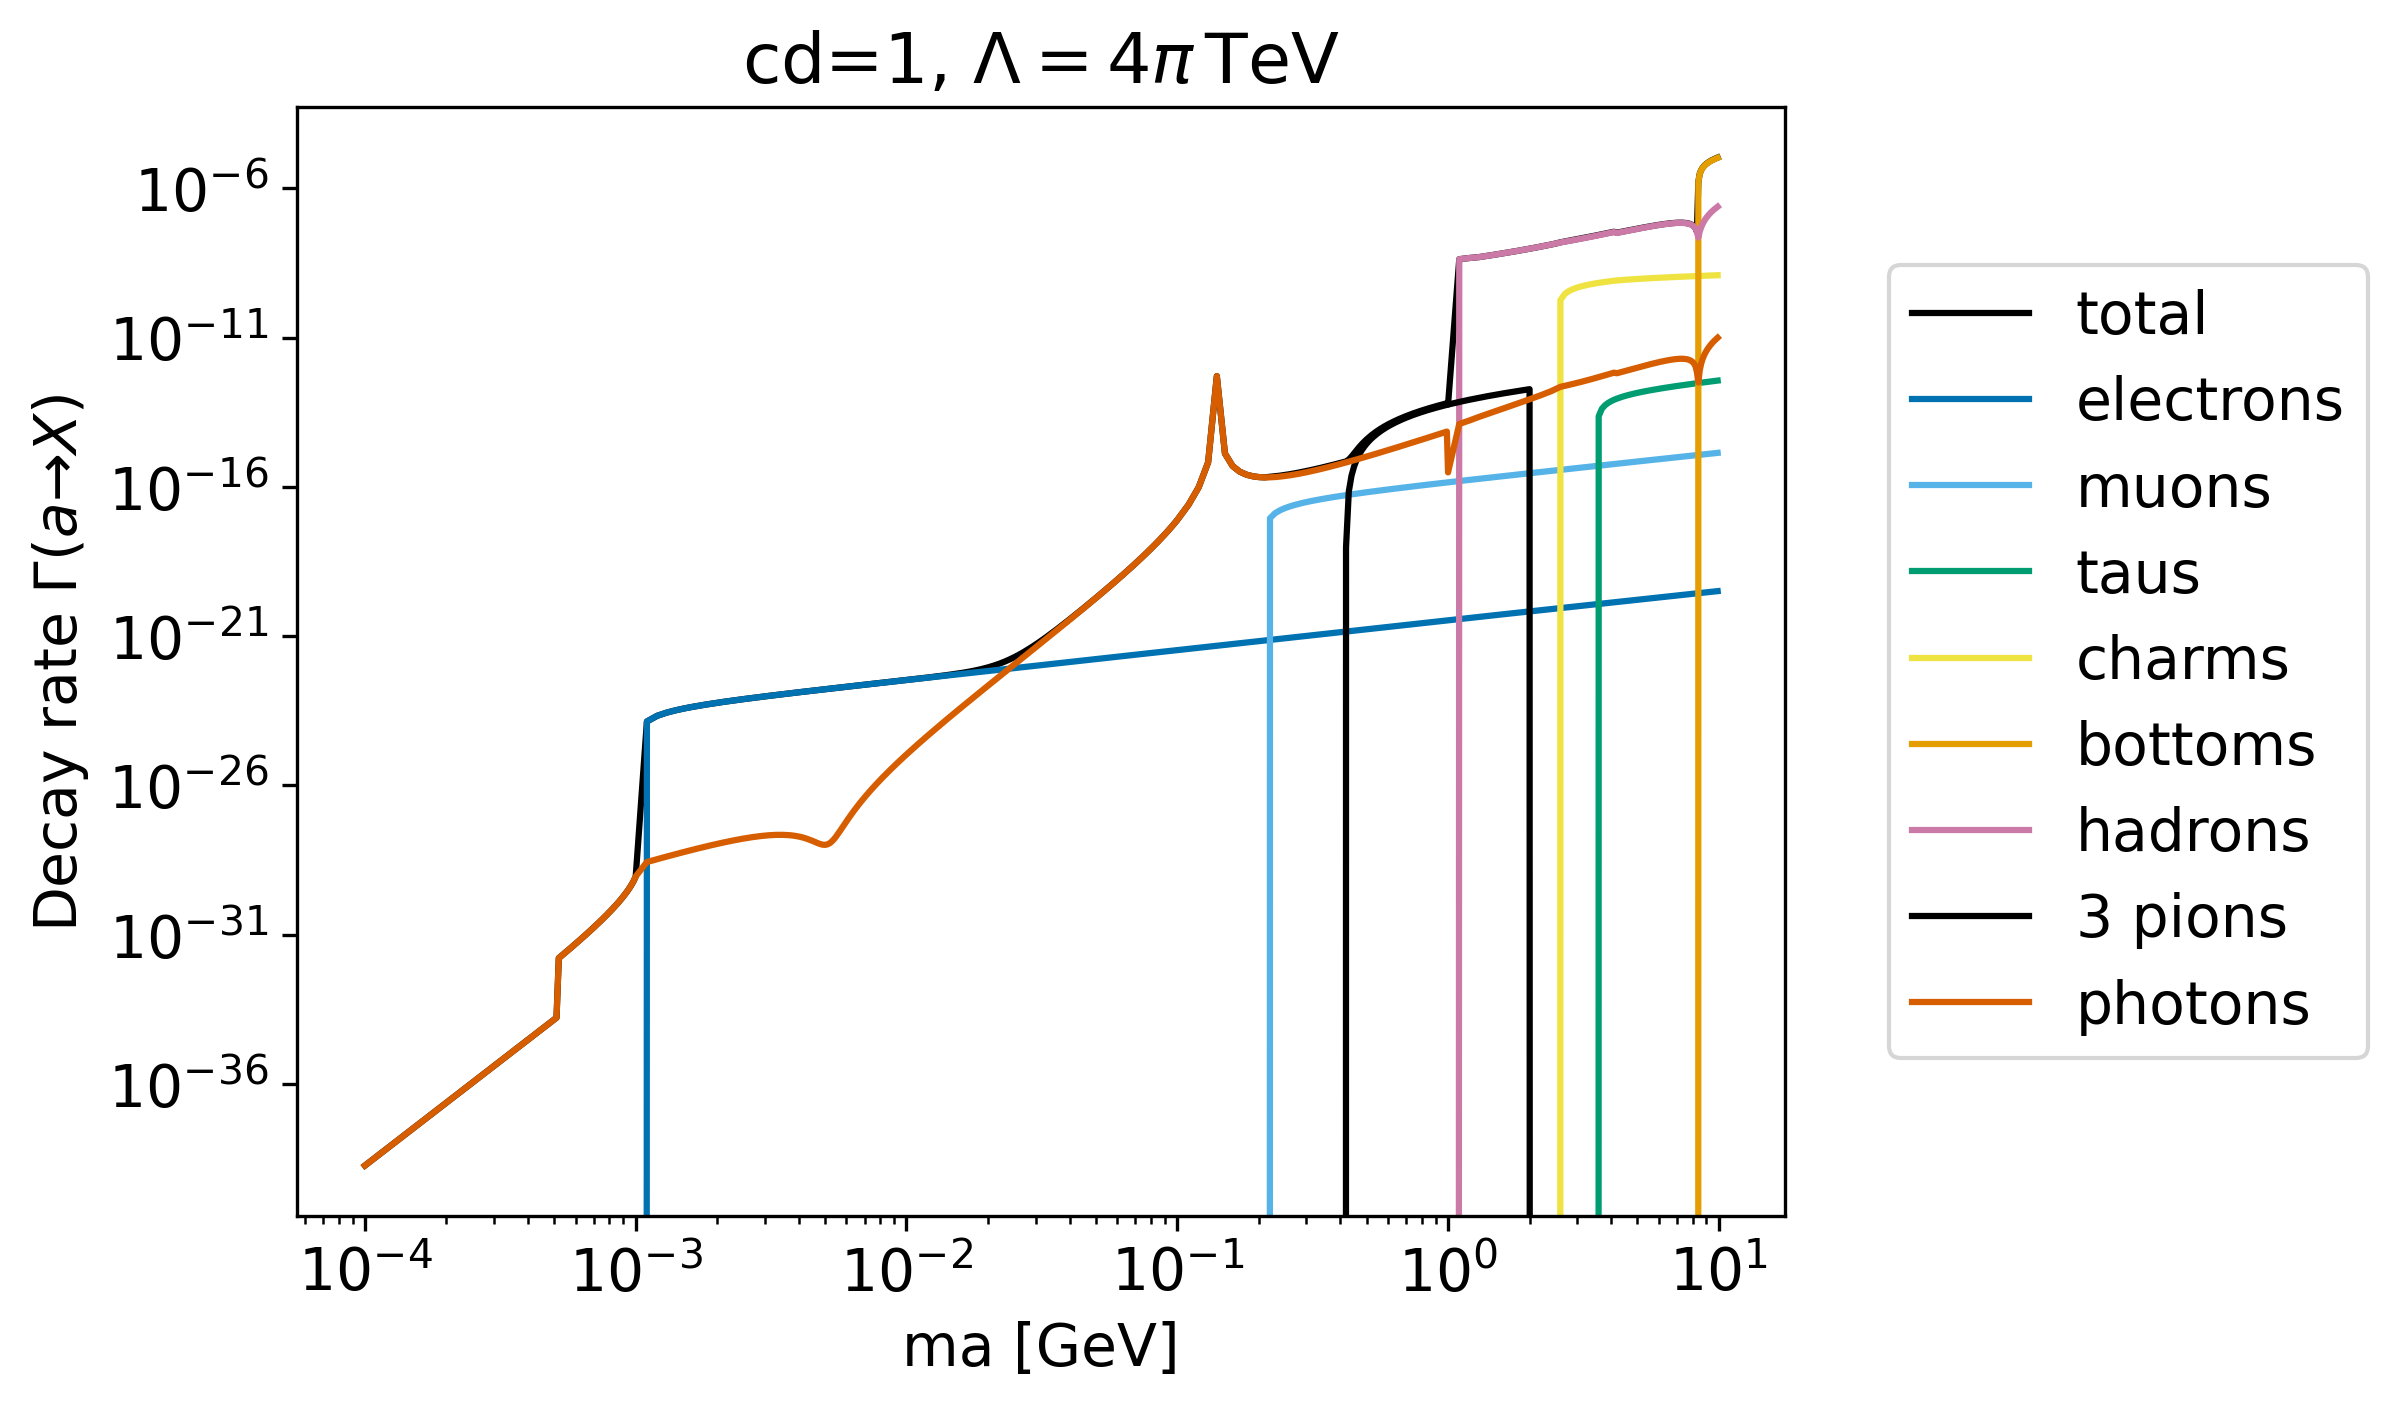

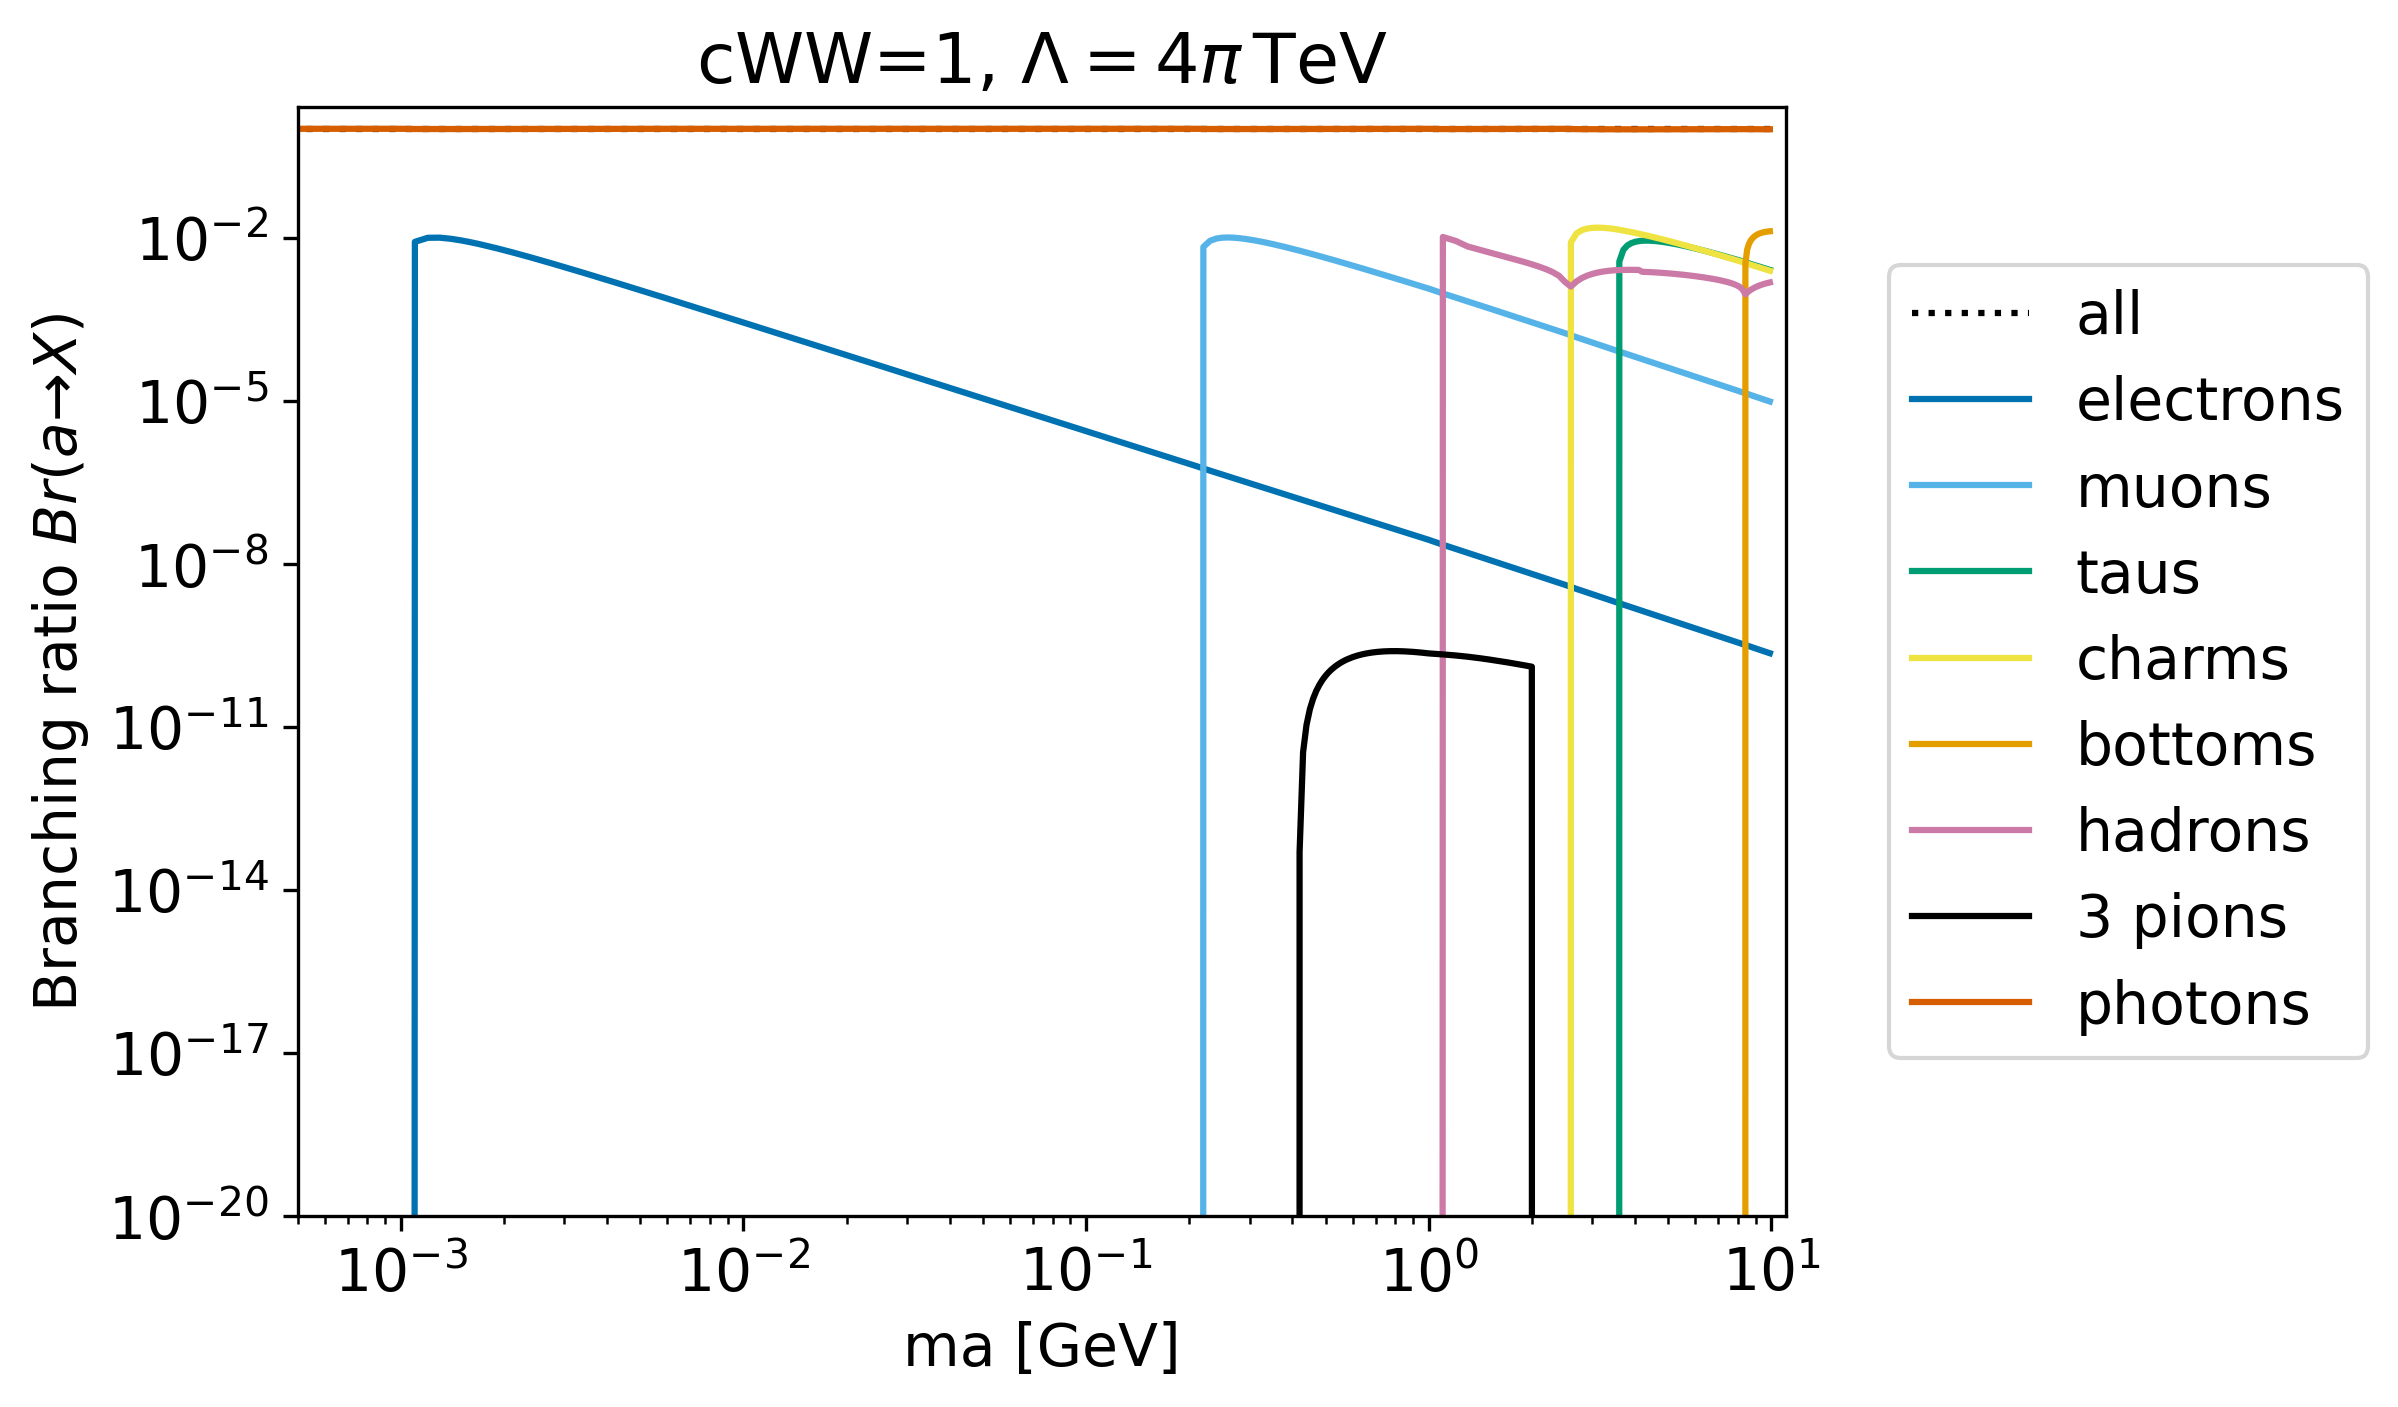

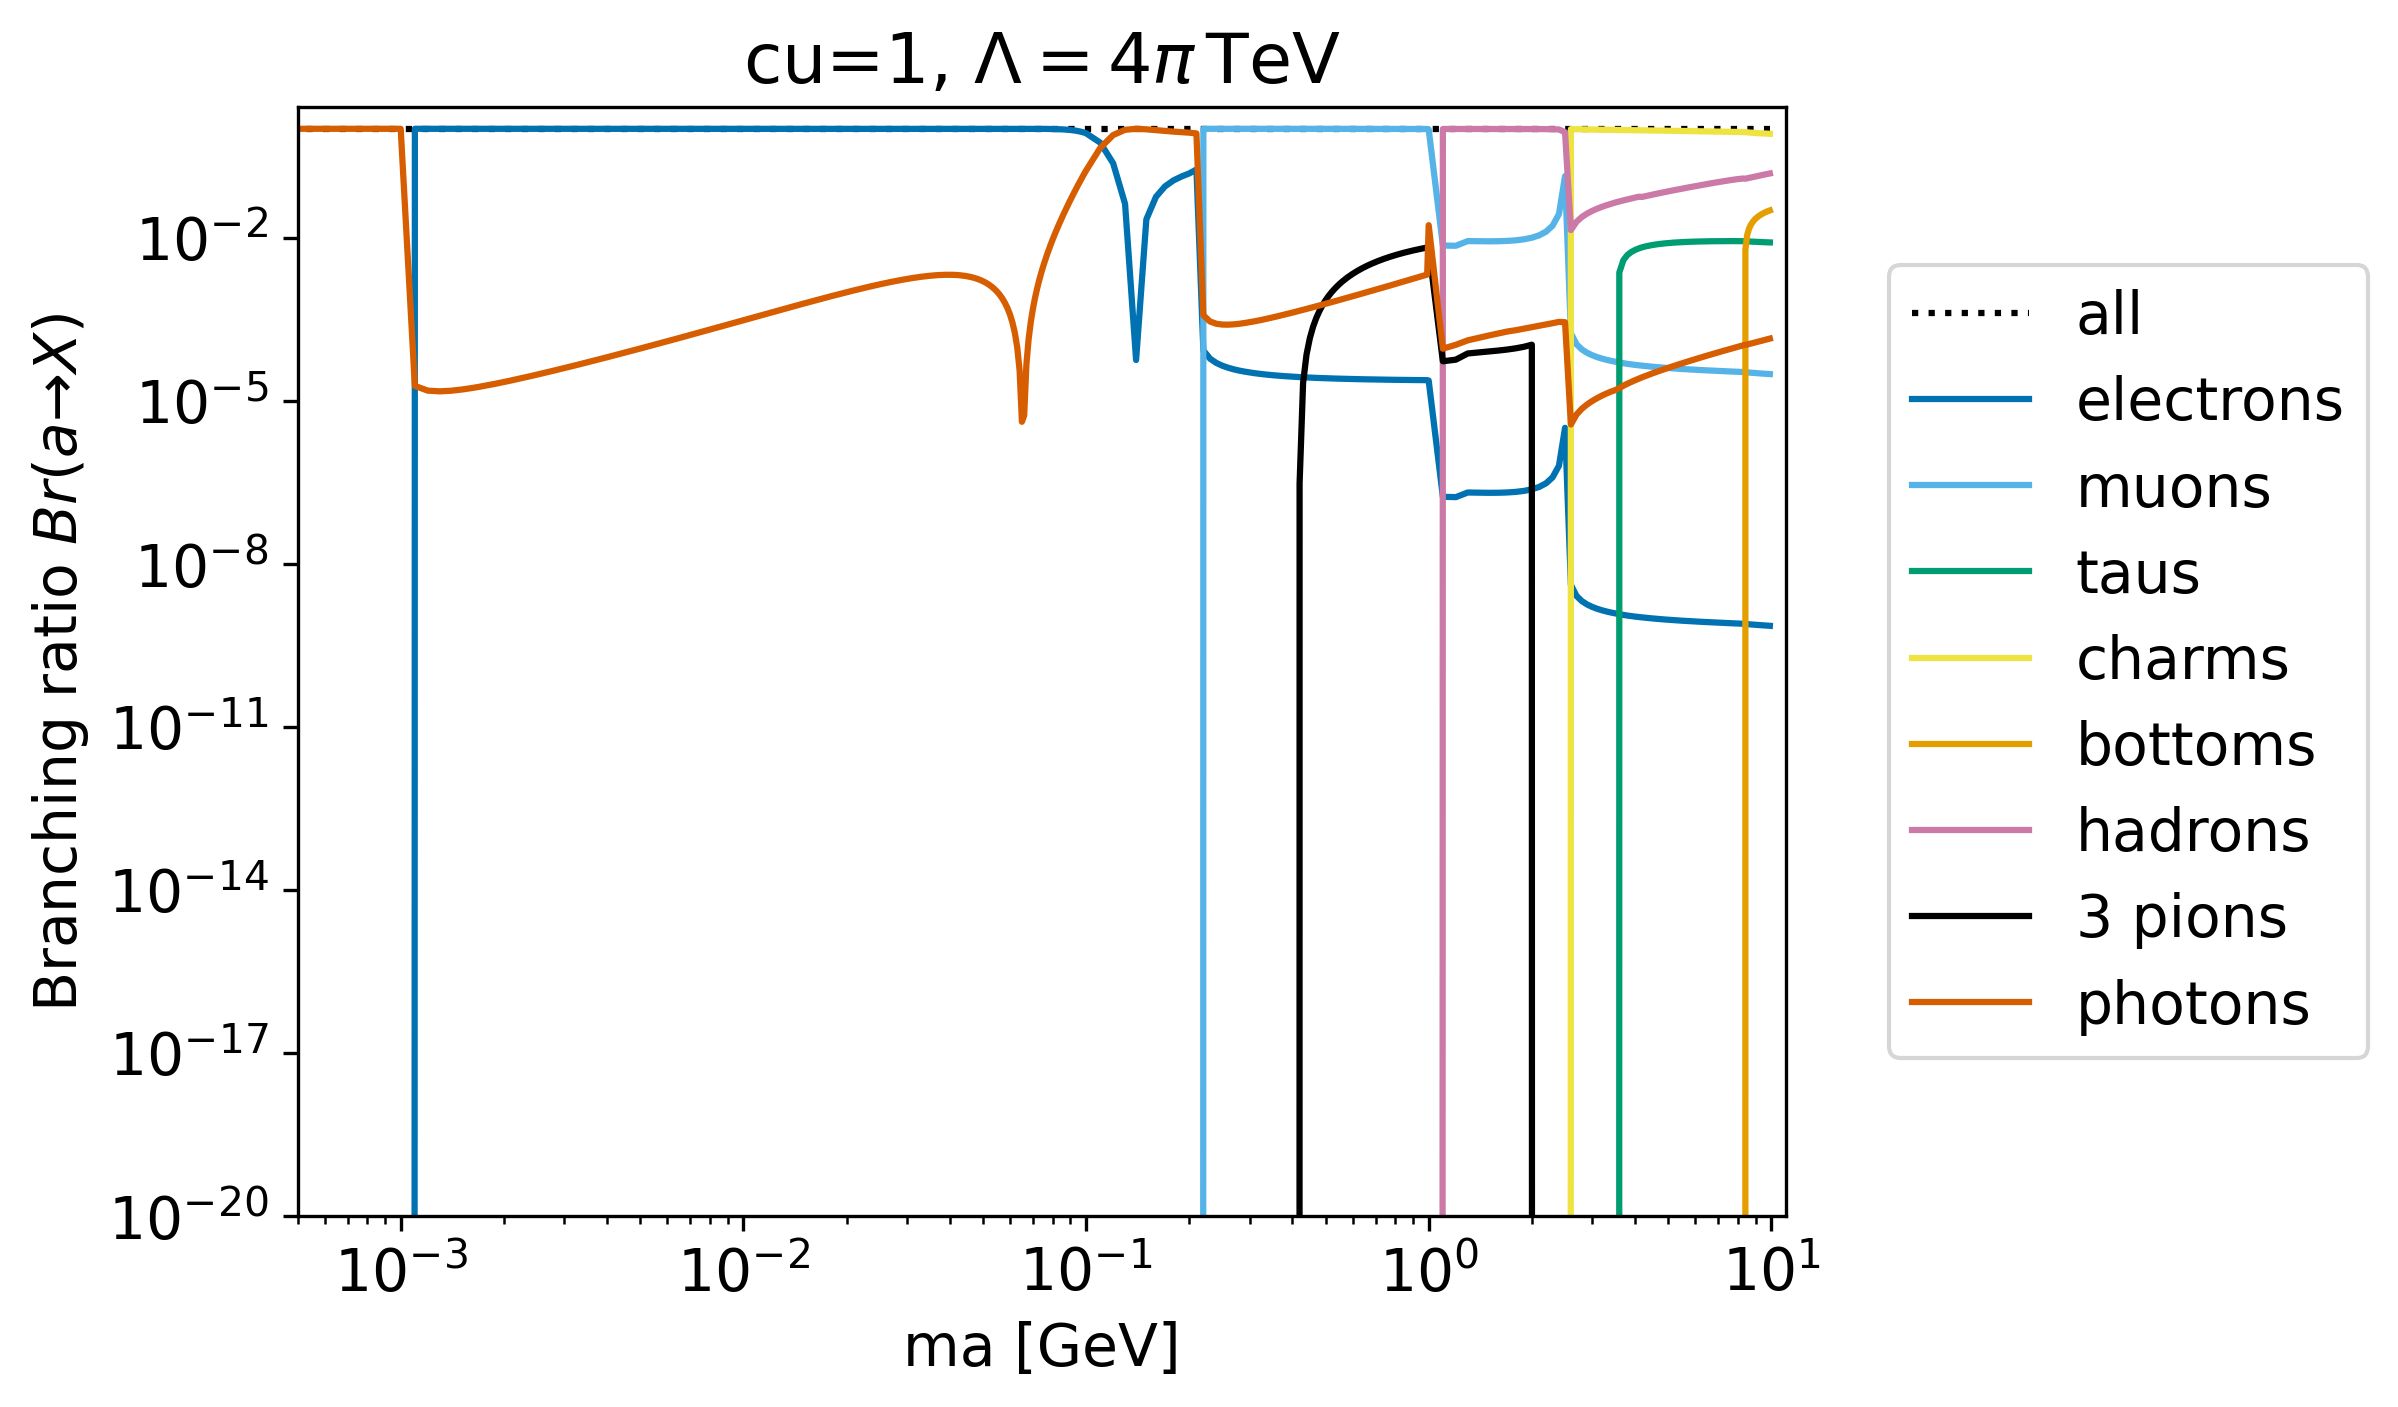

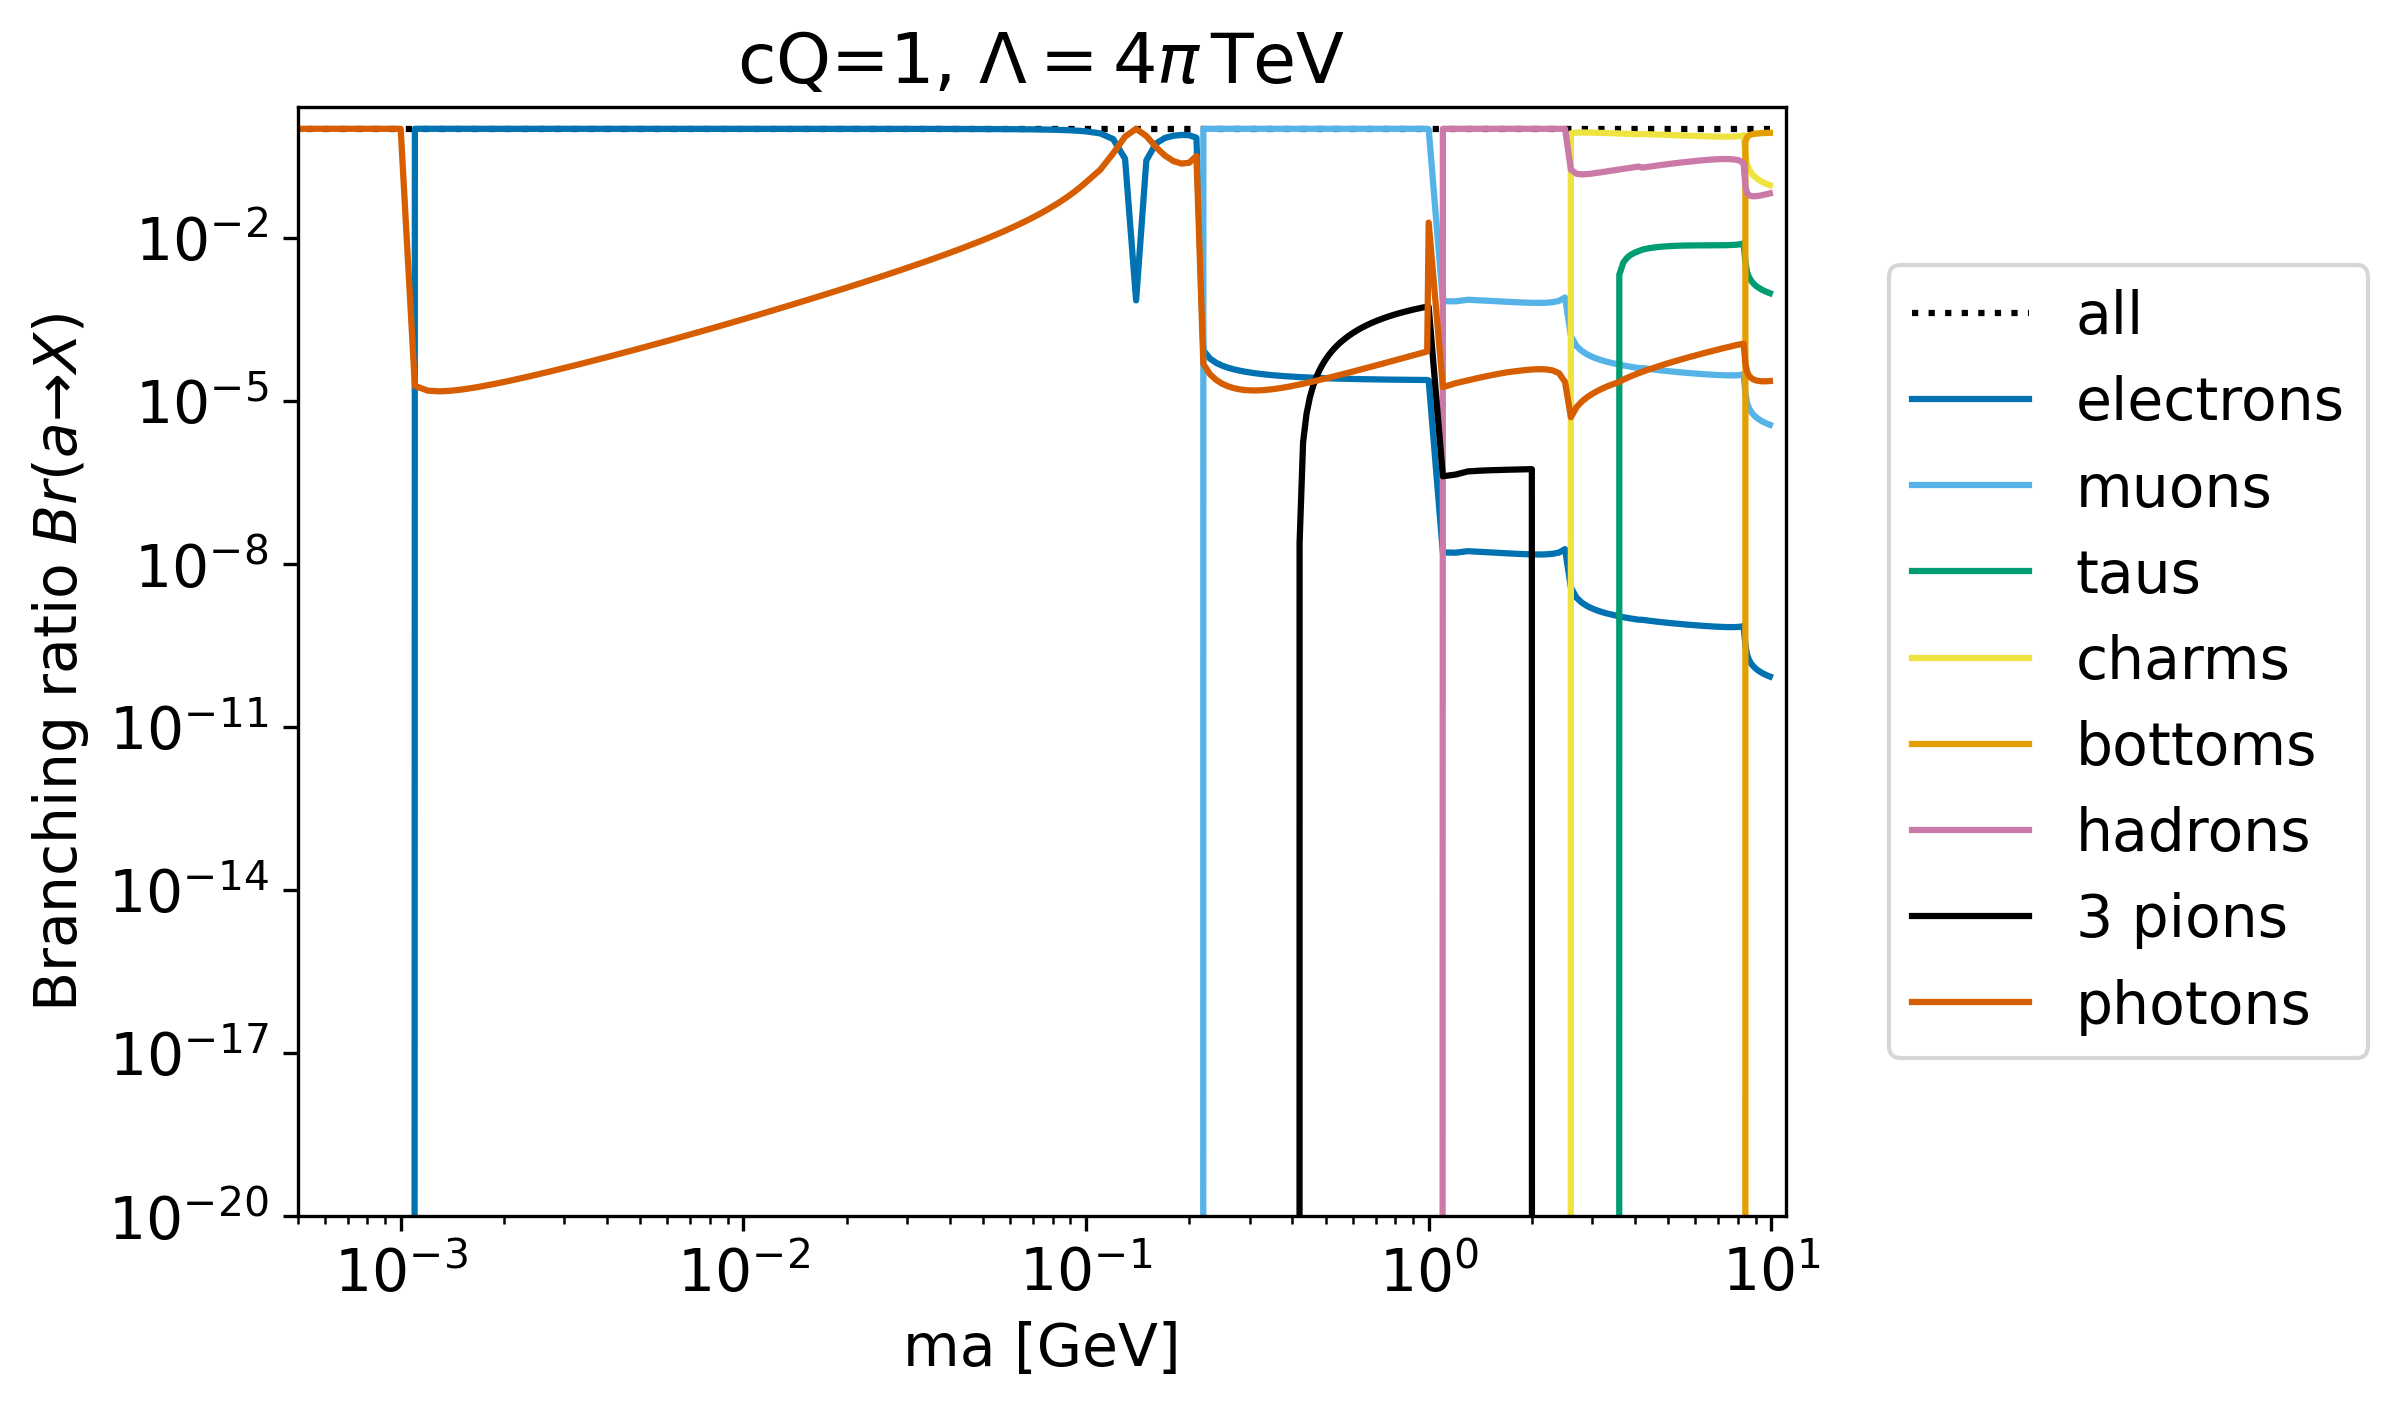

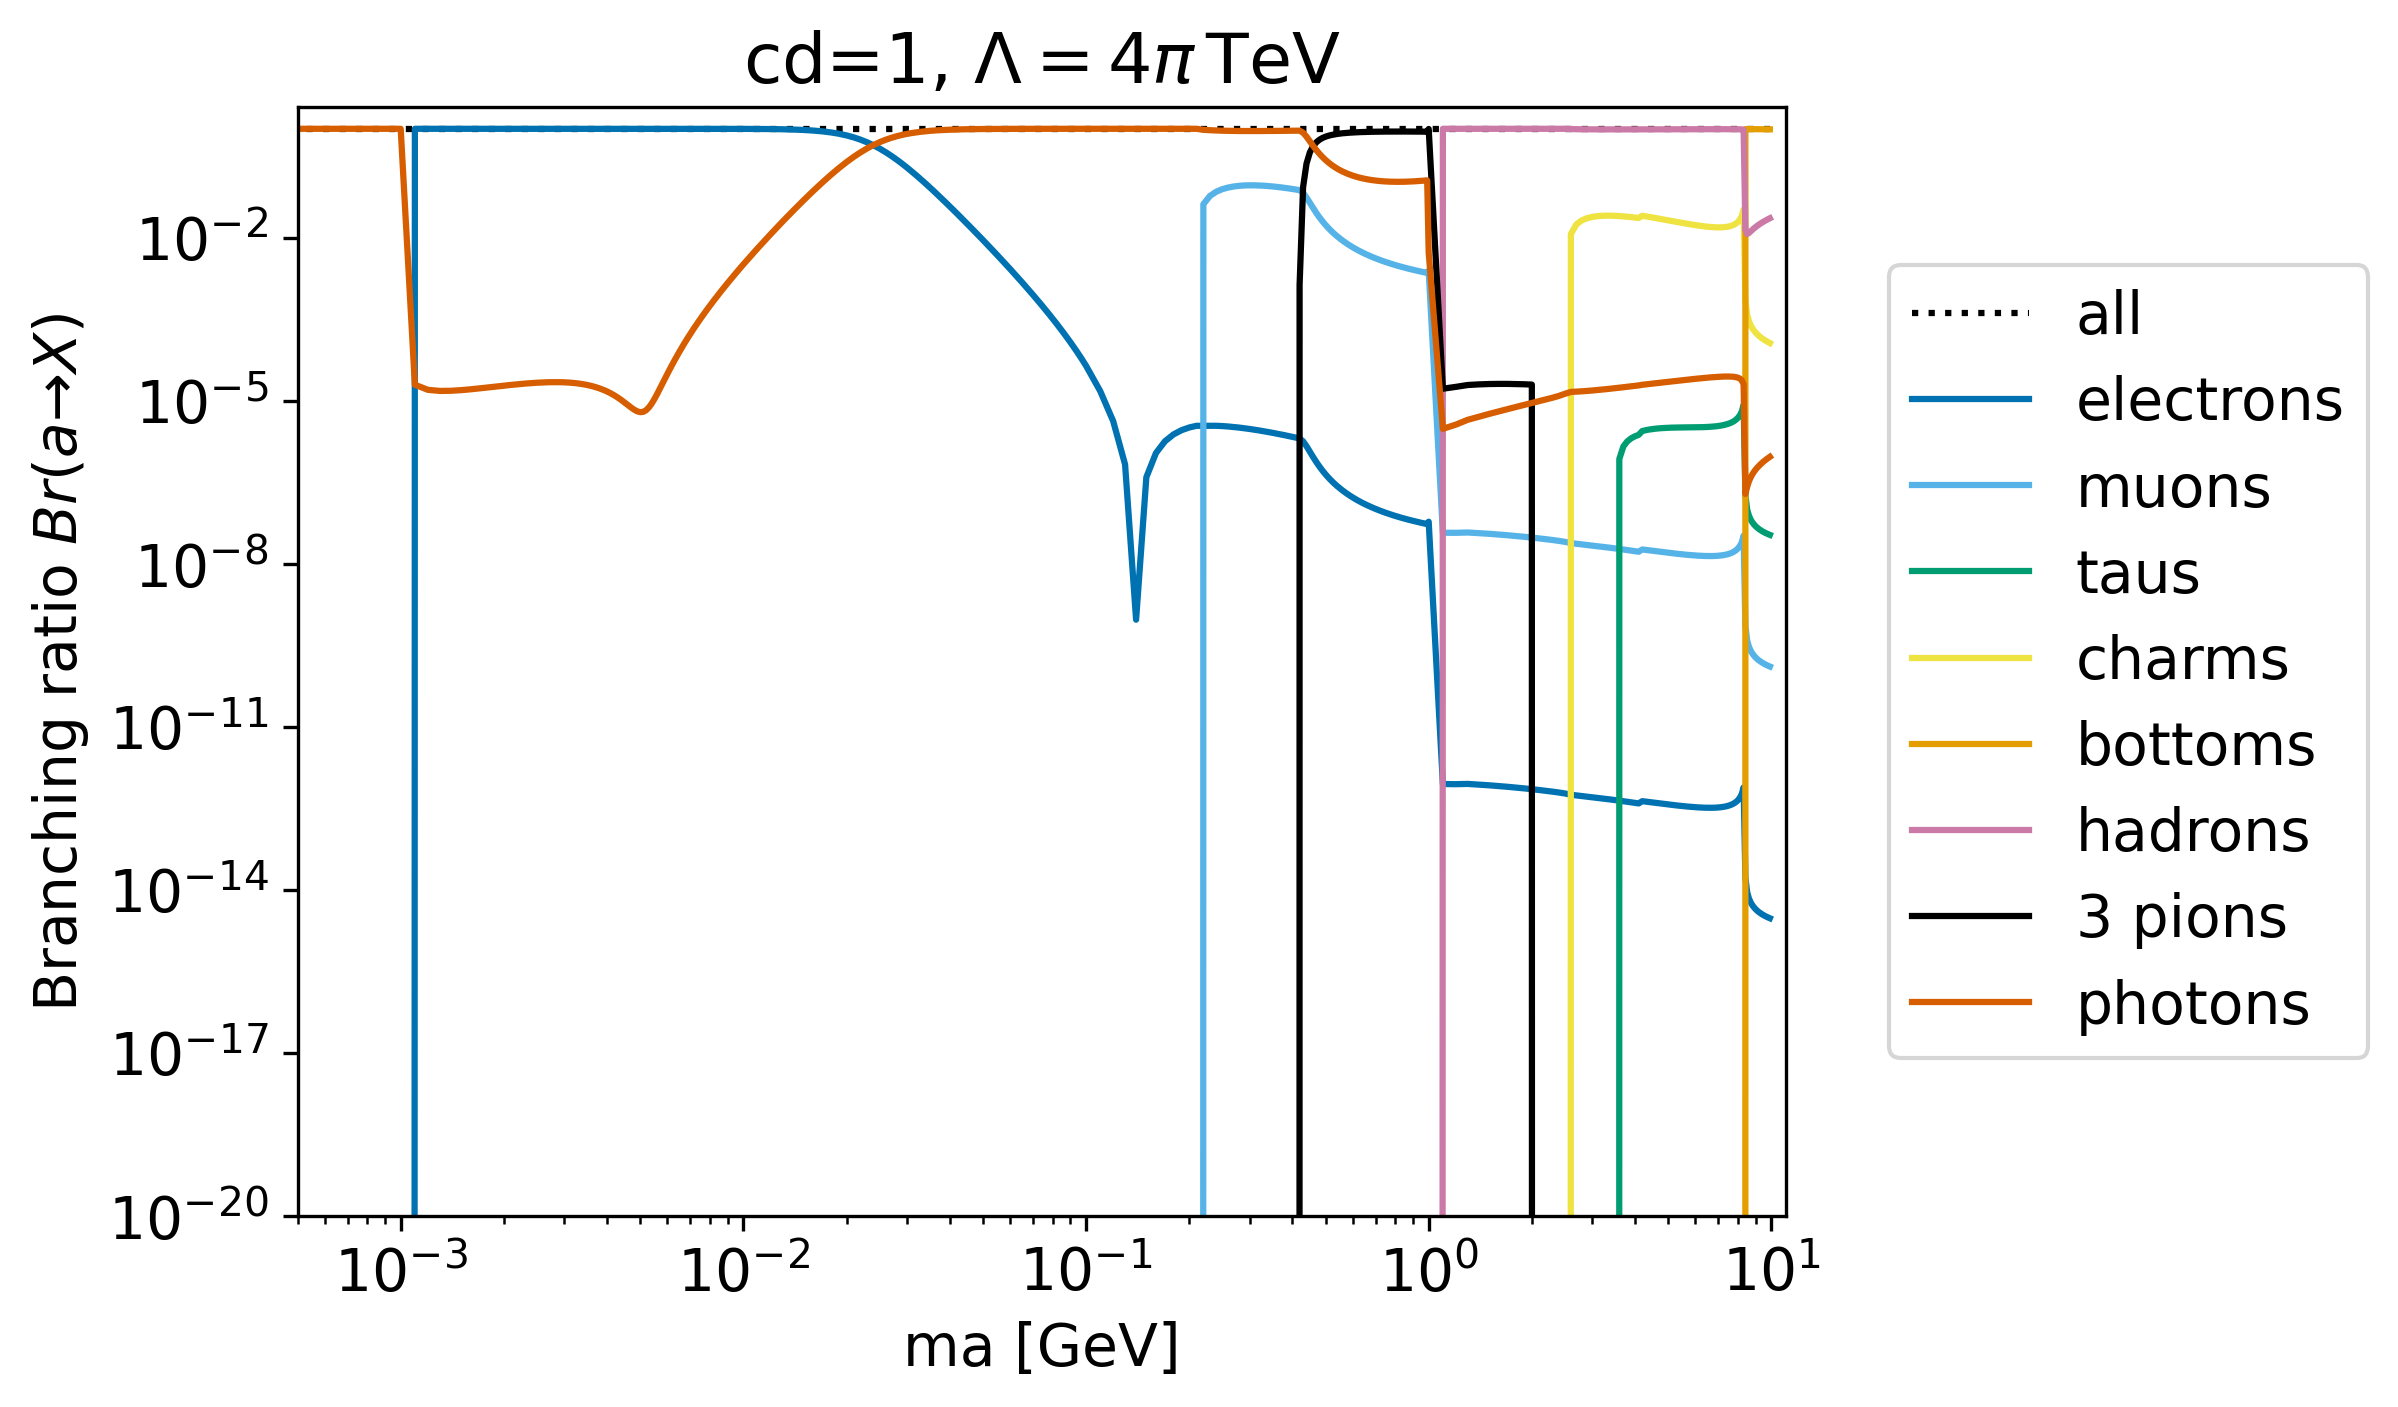

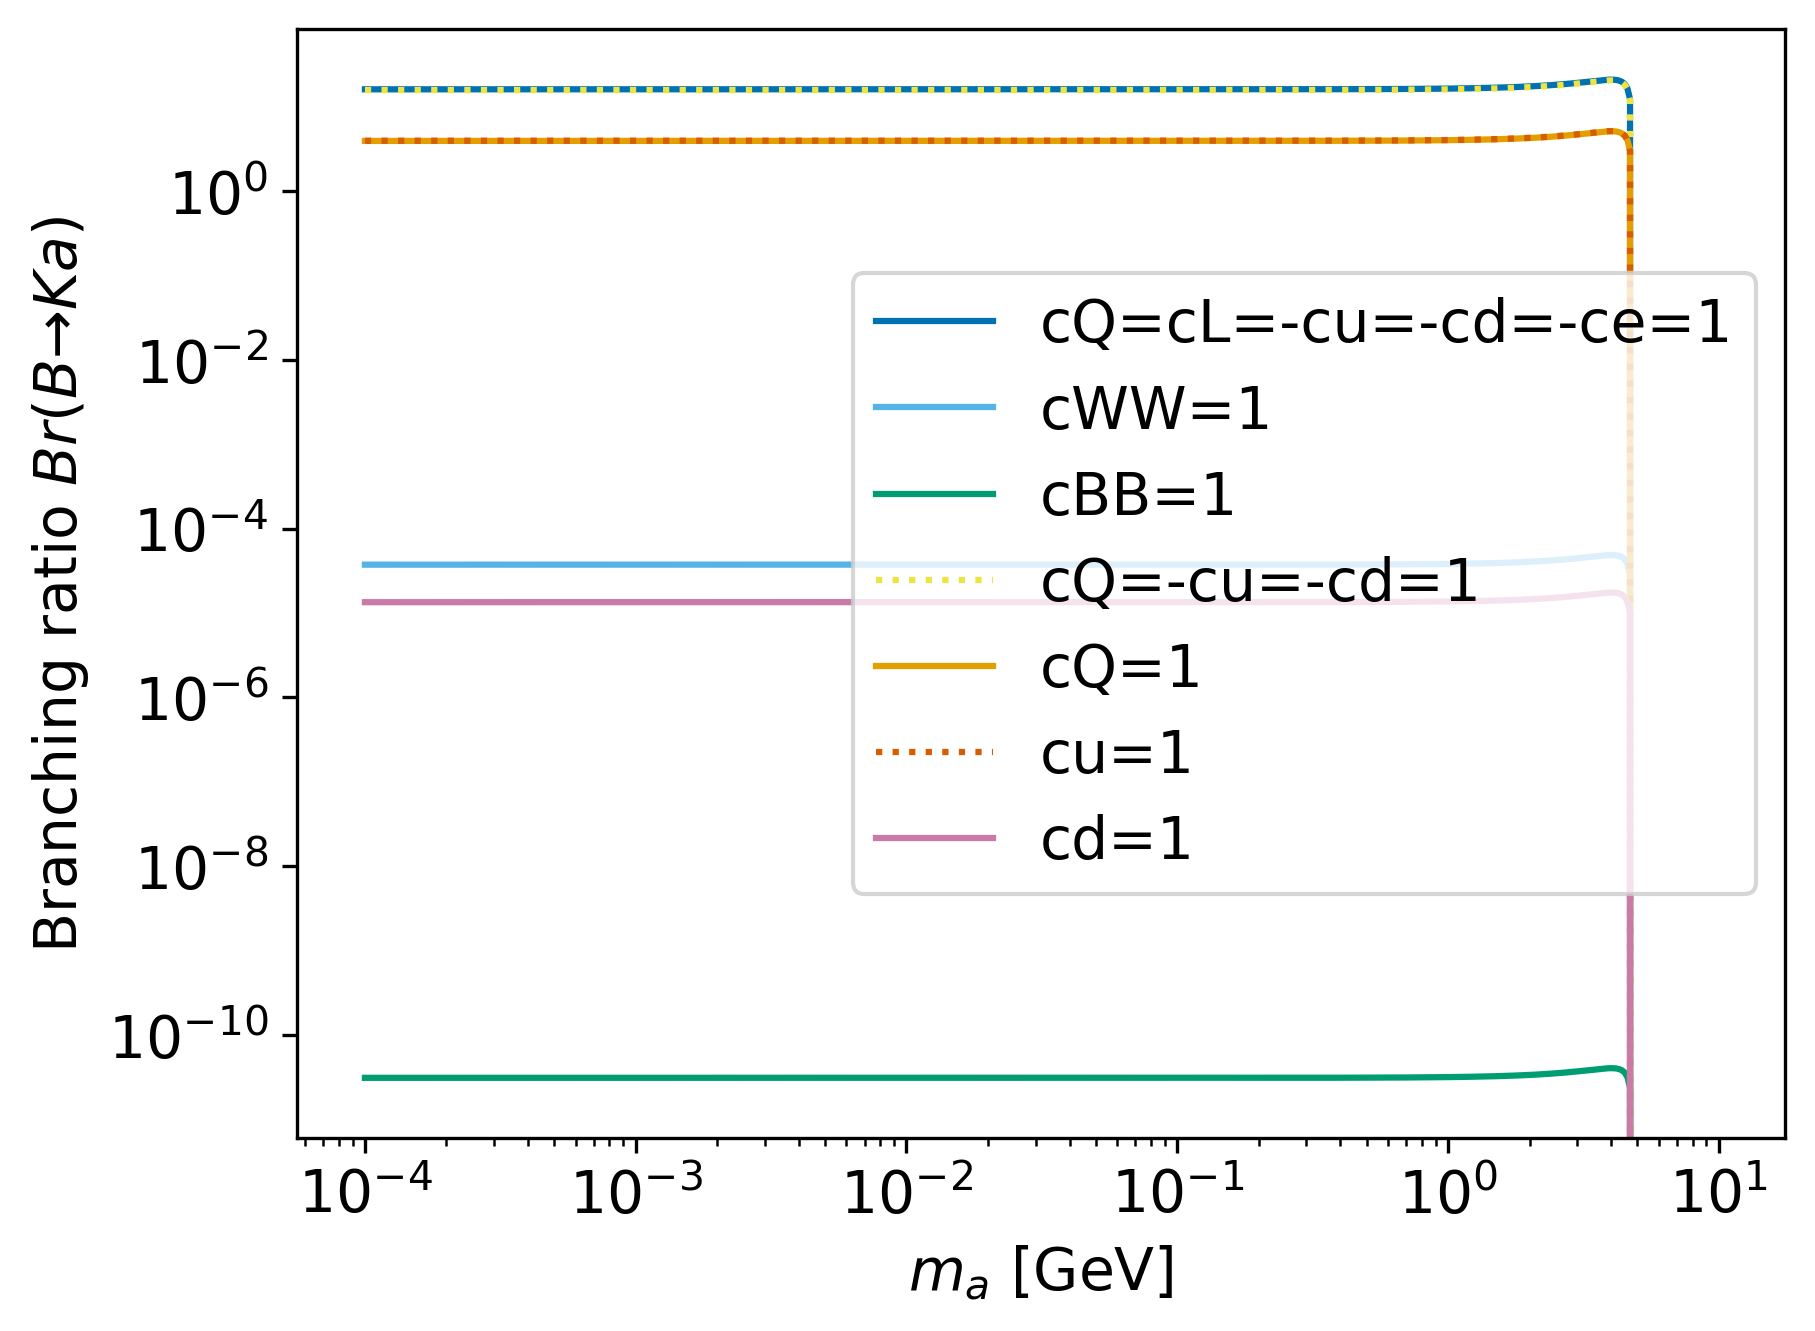

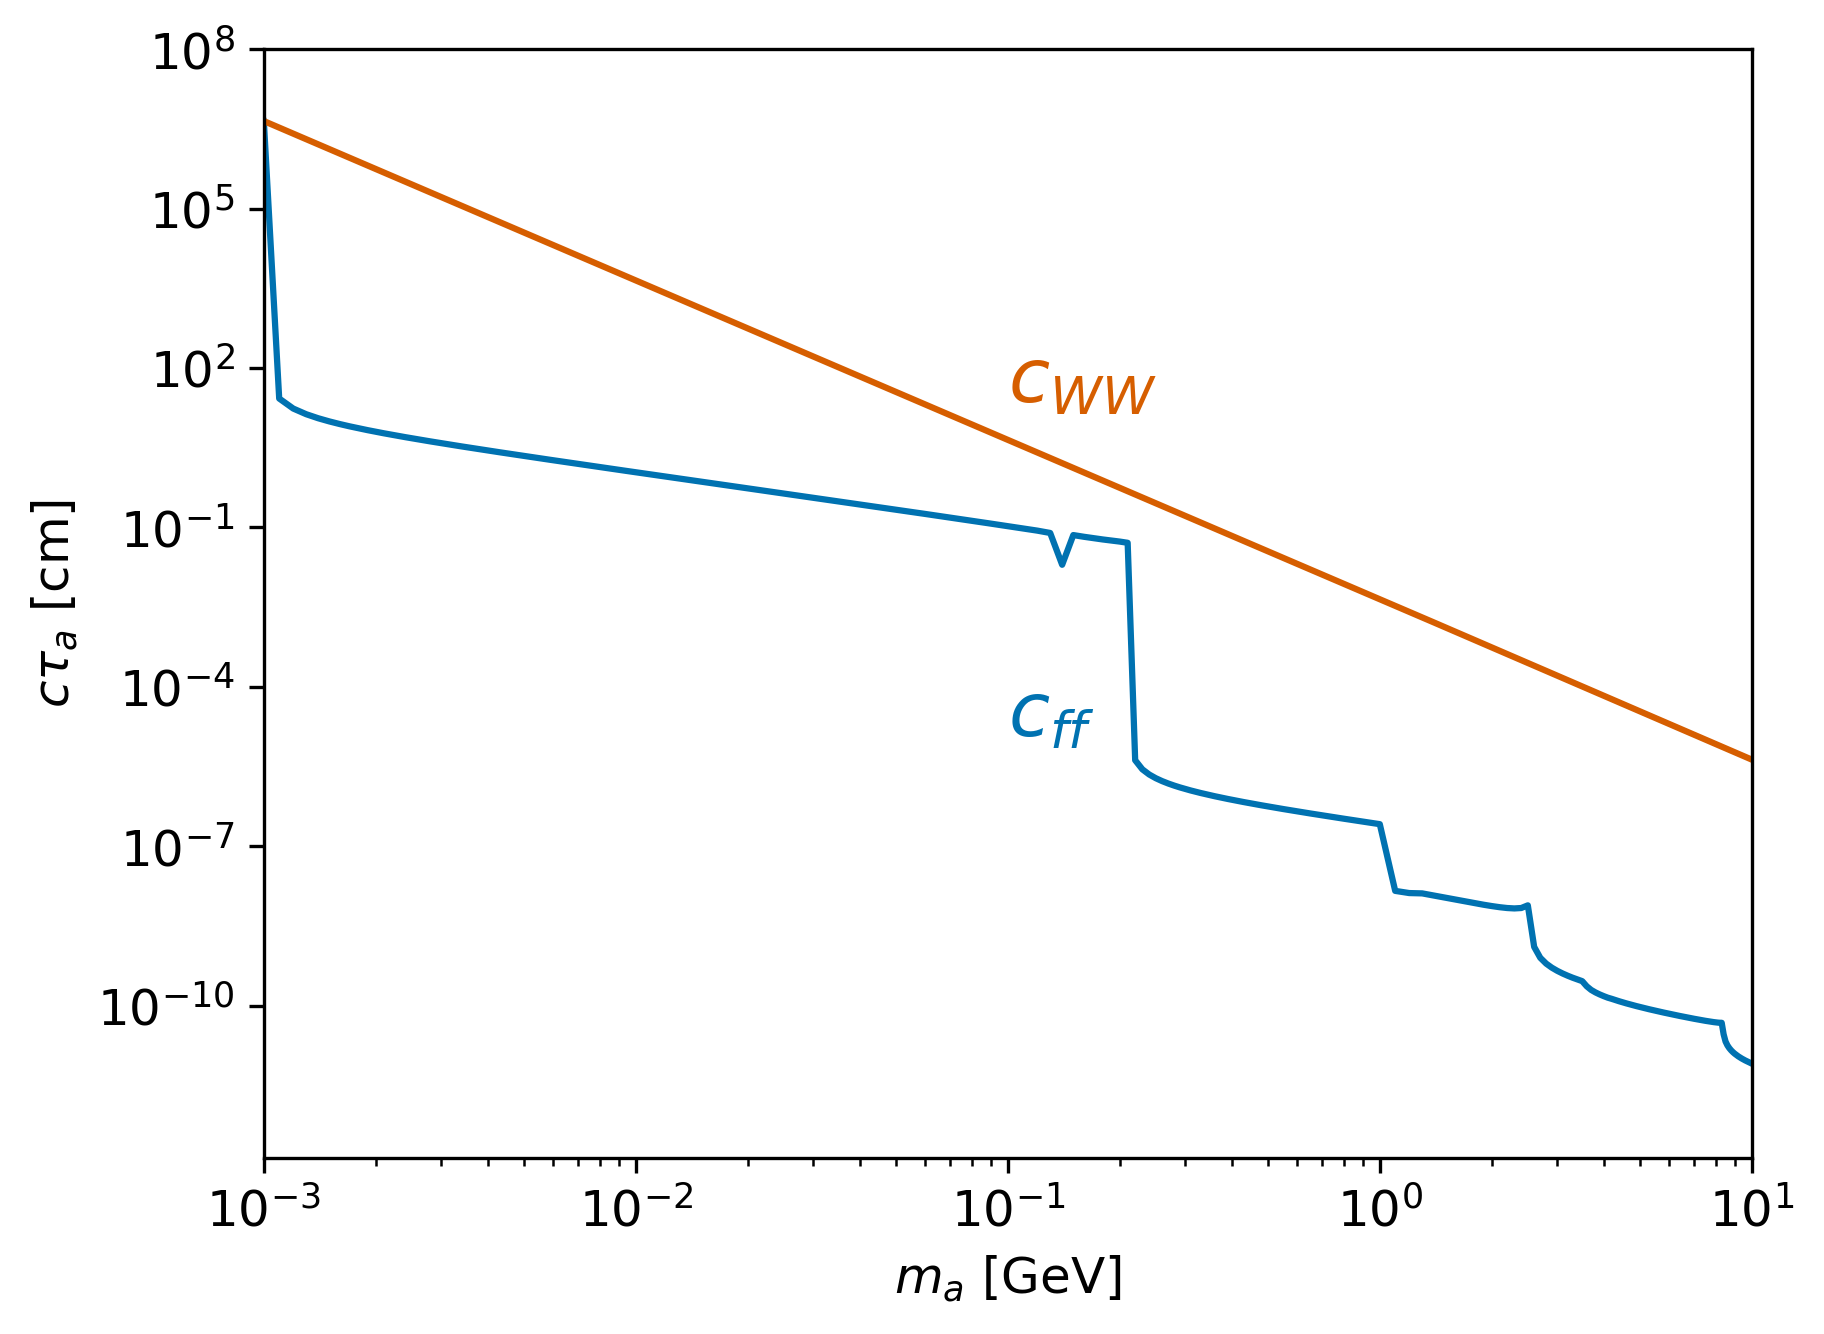

/home/stasya/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


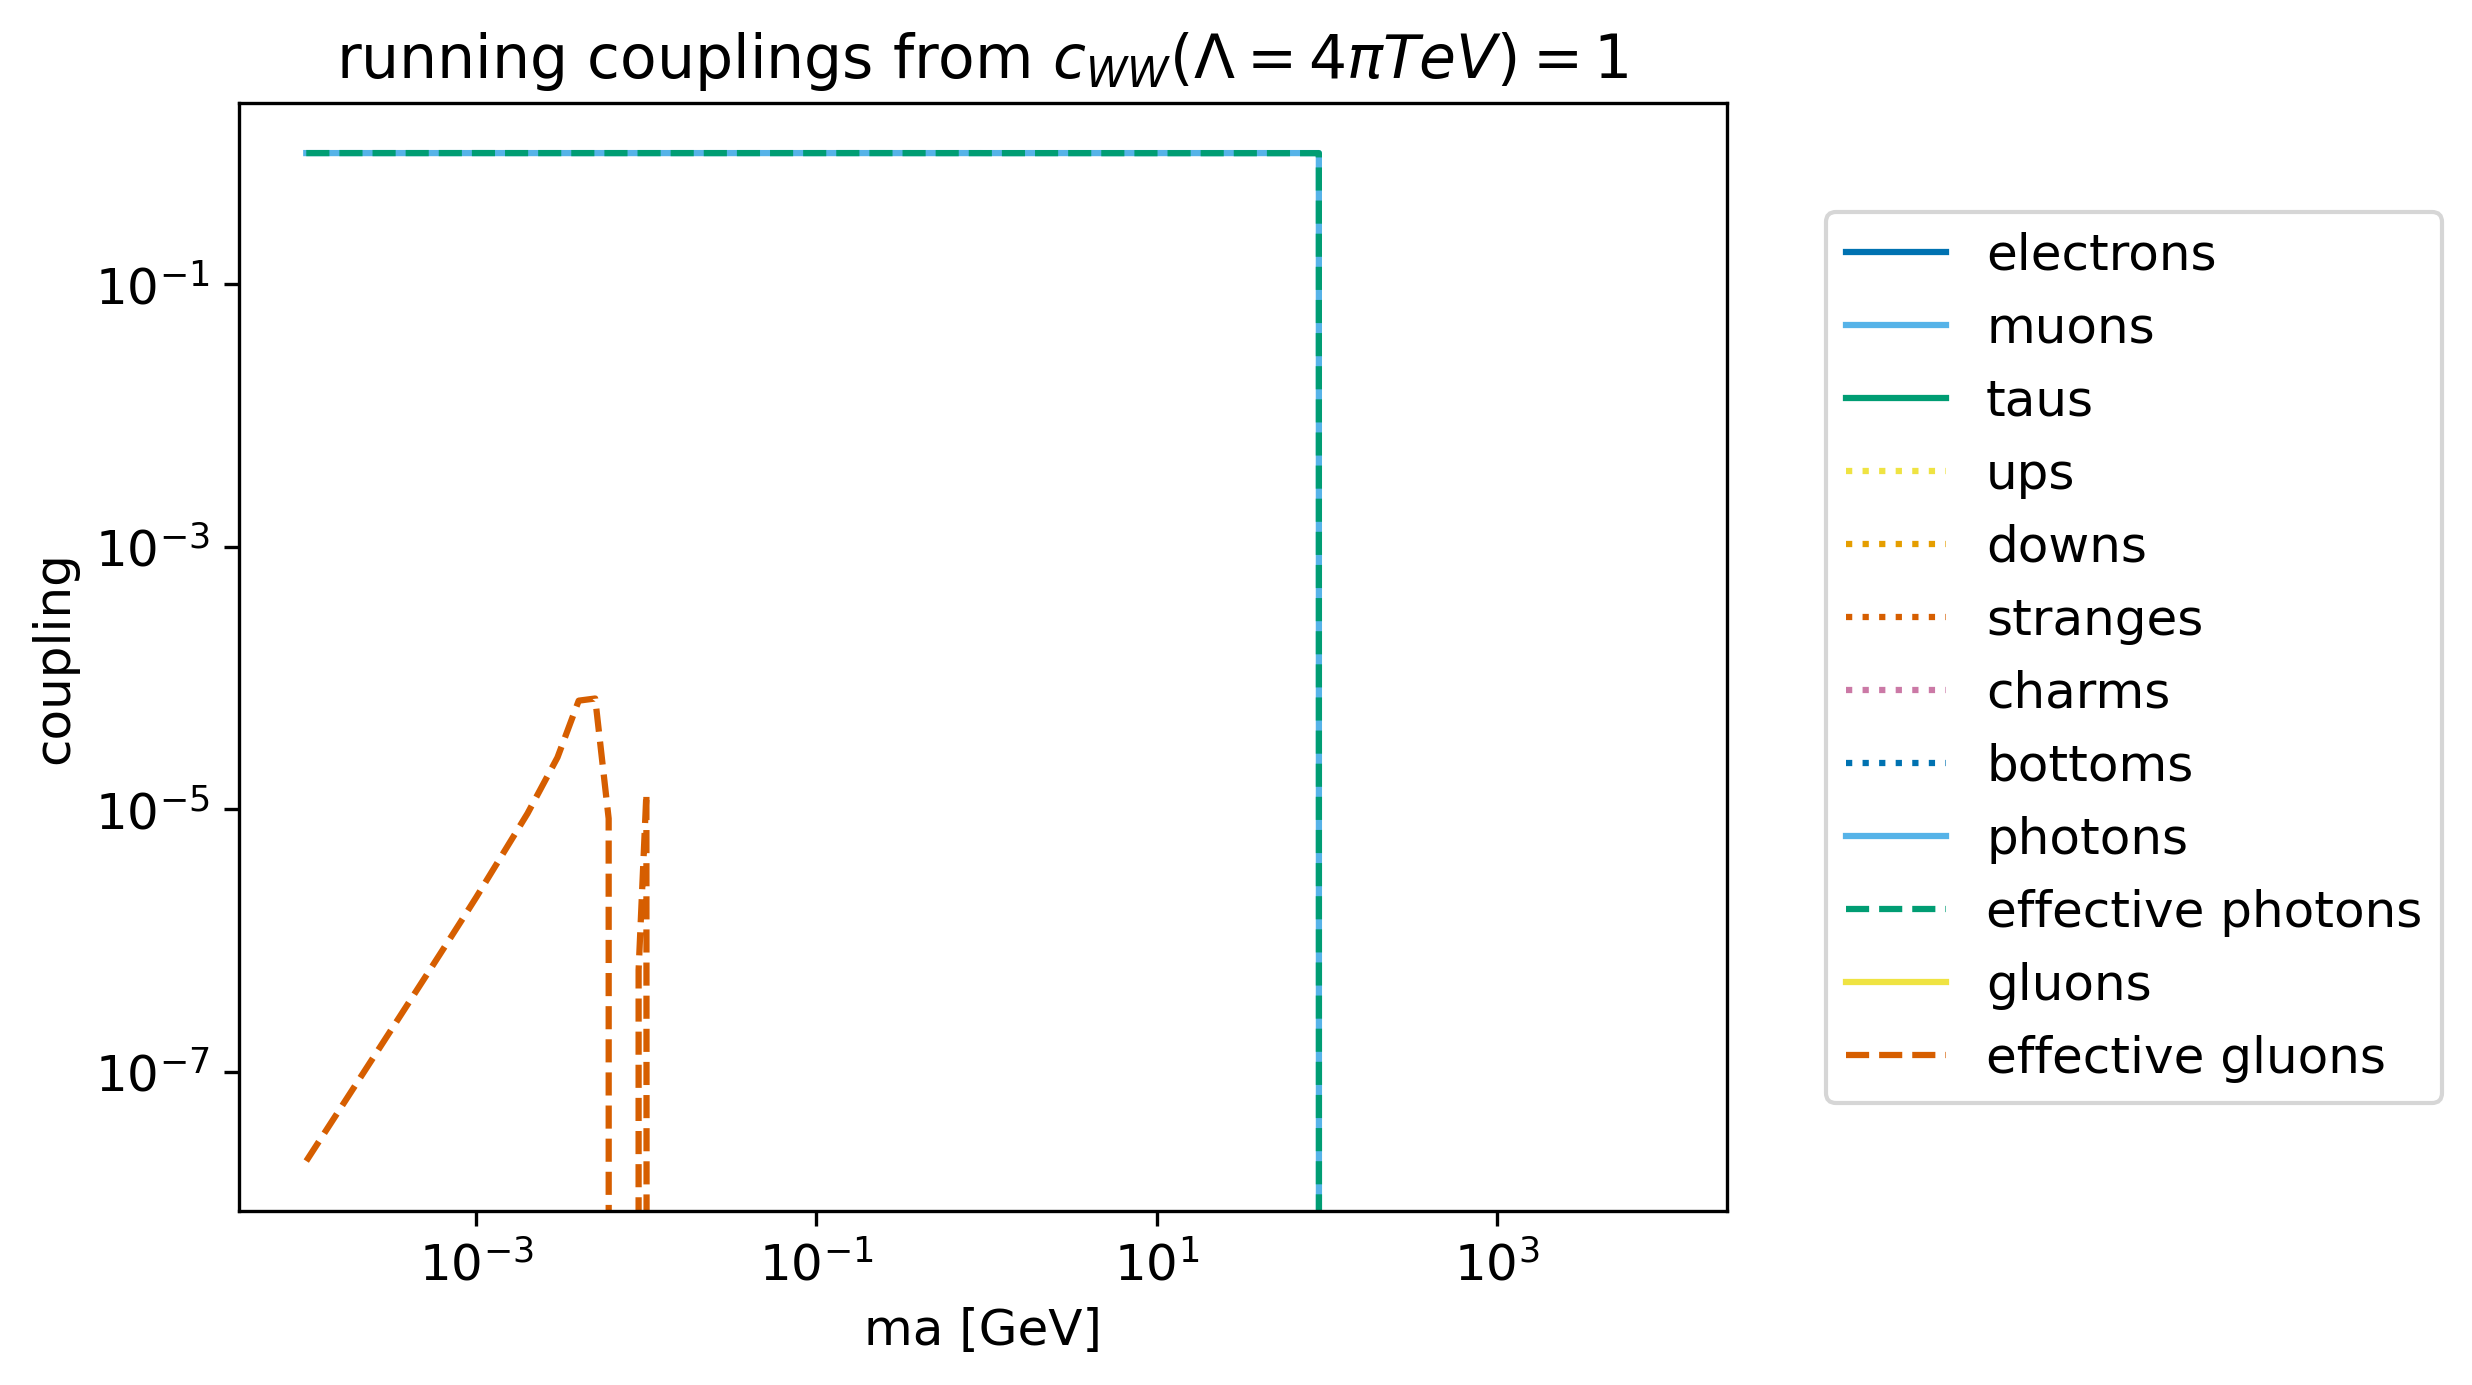

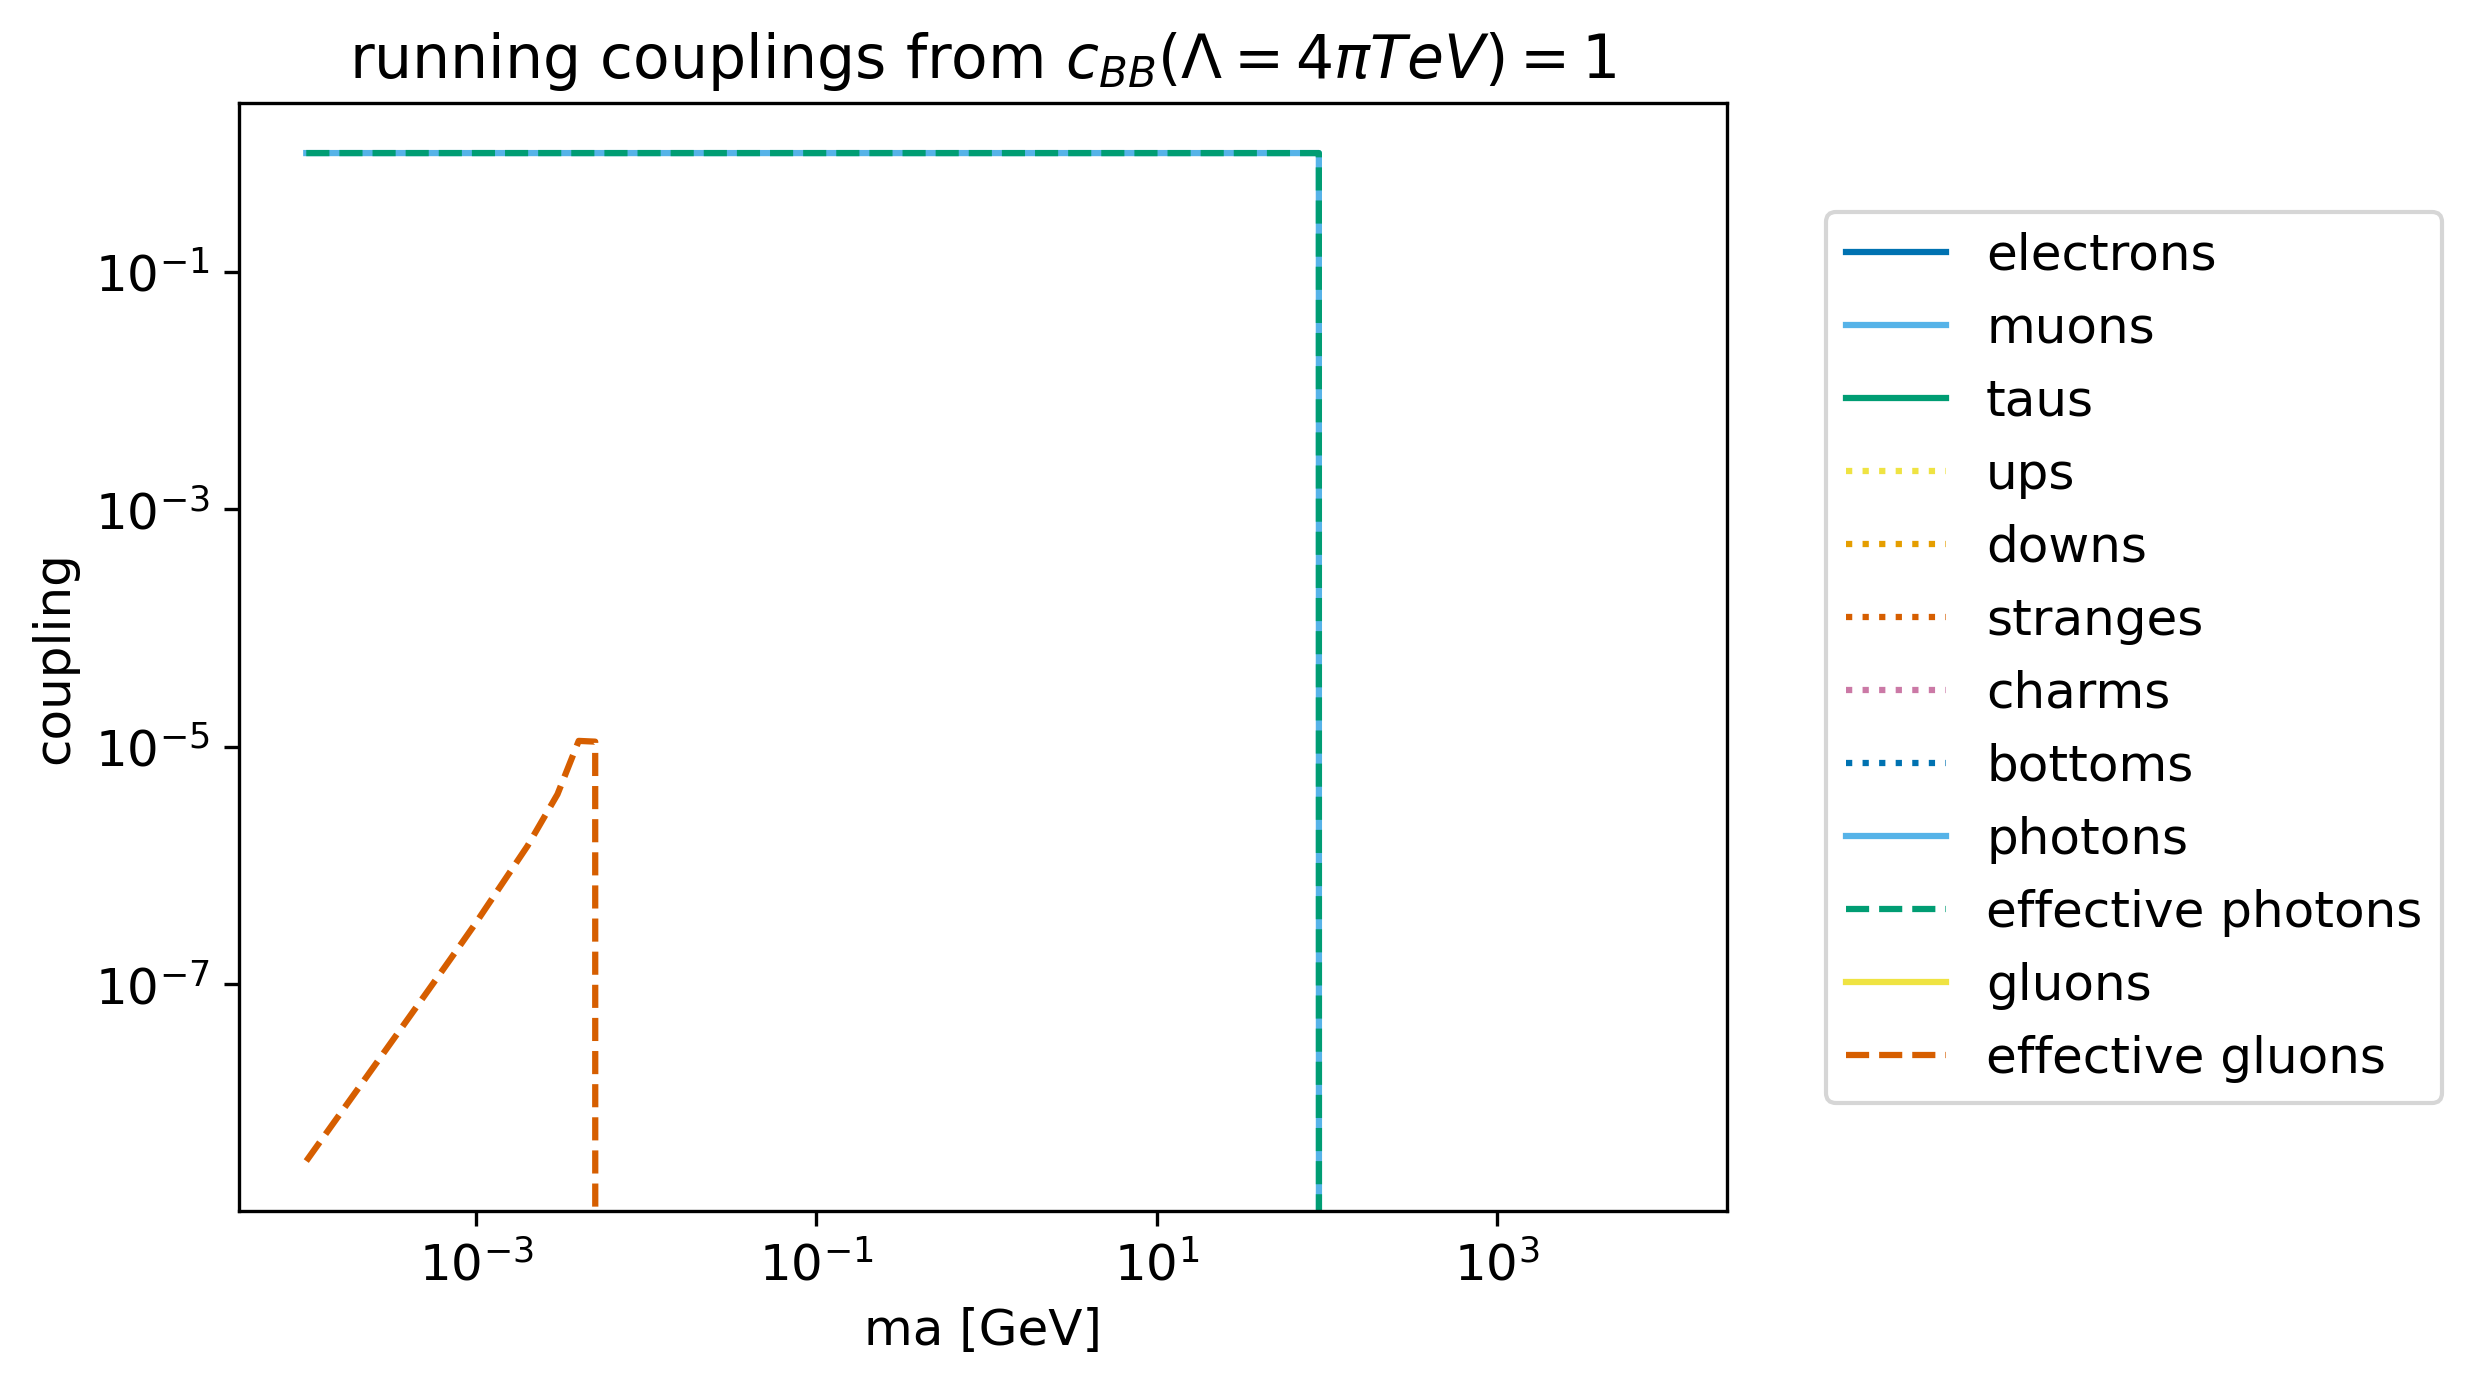

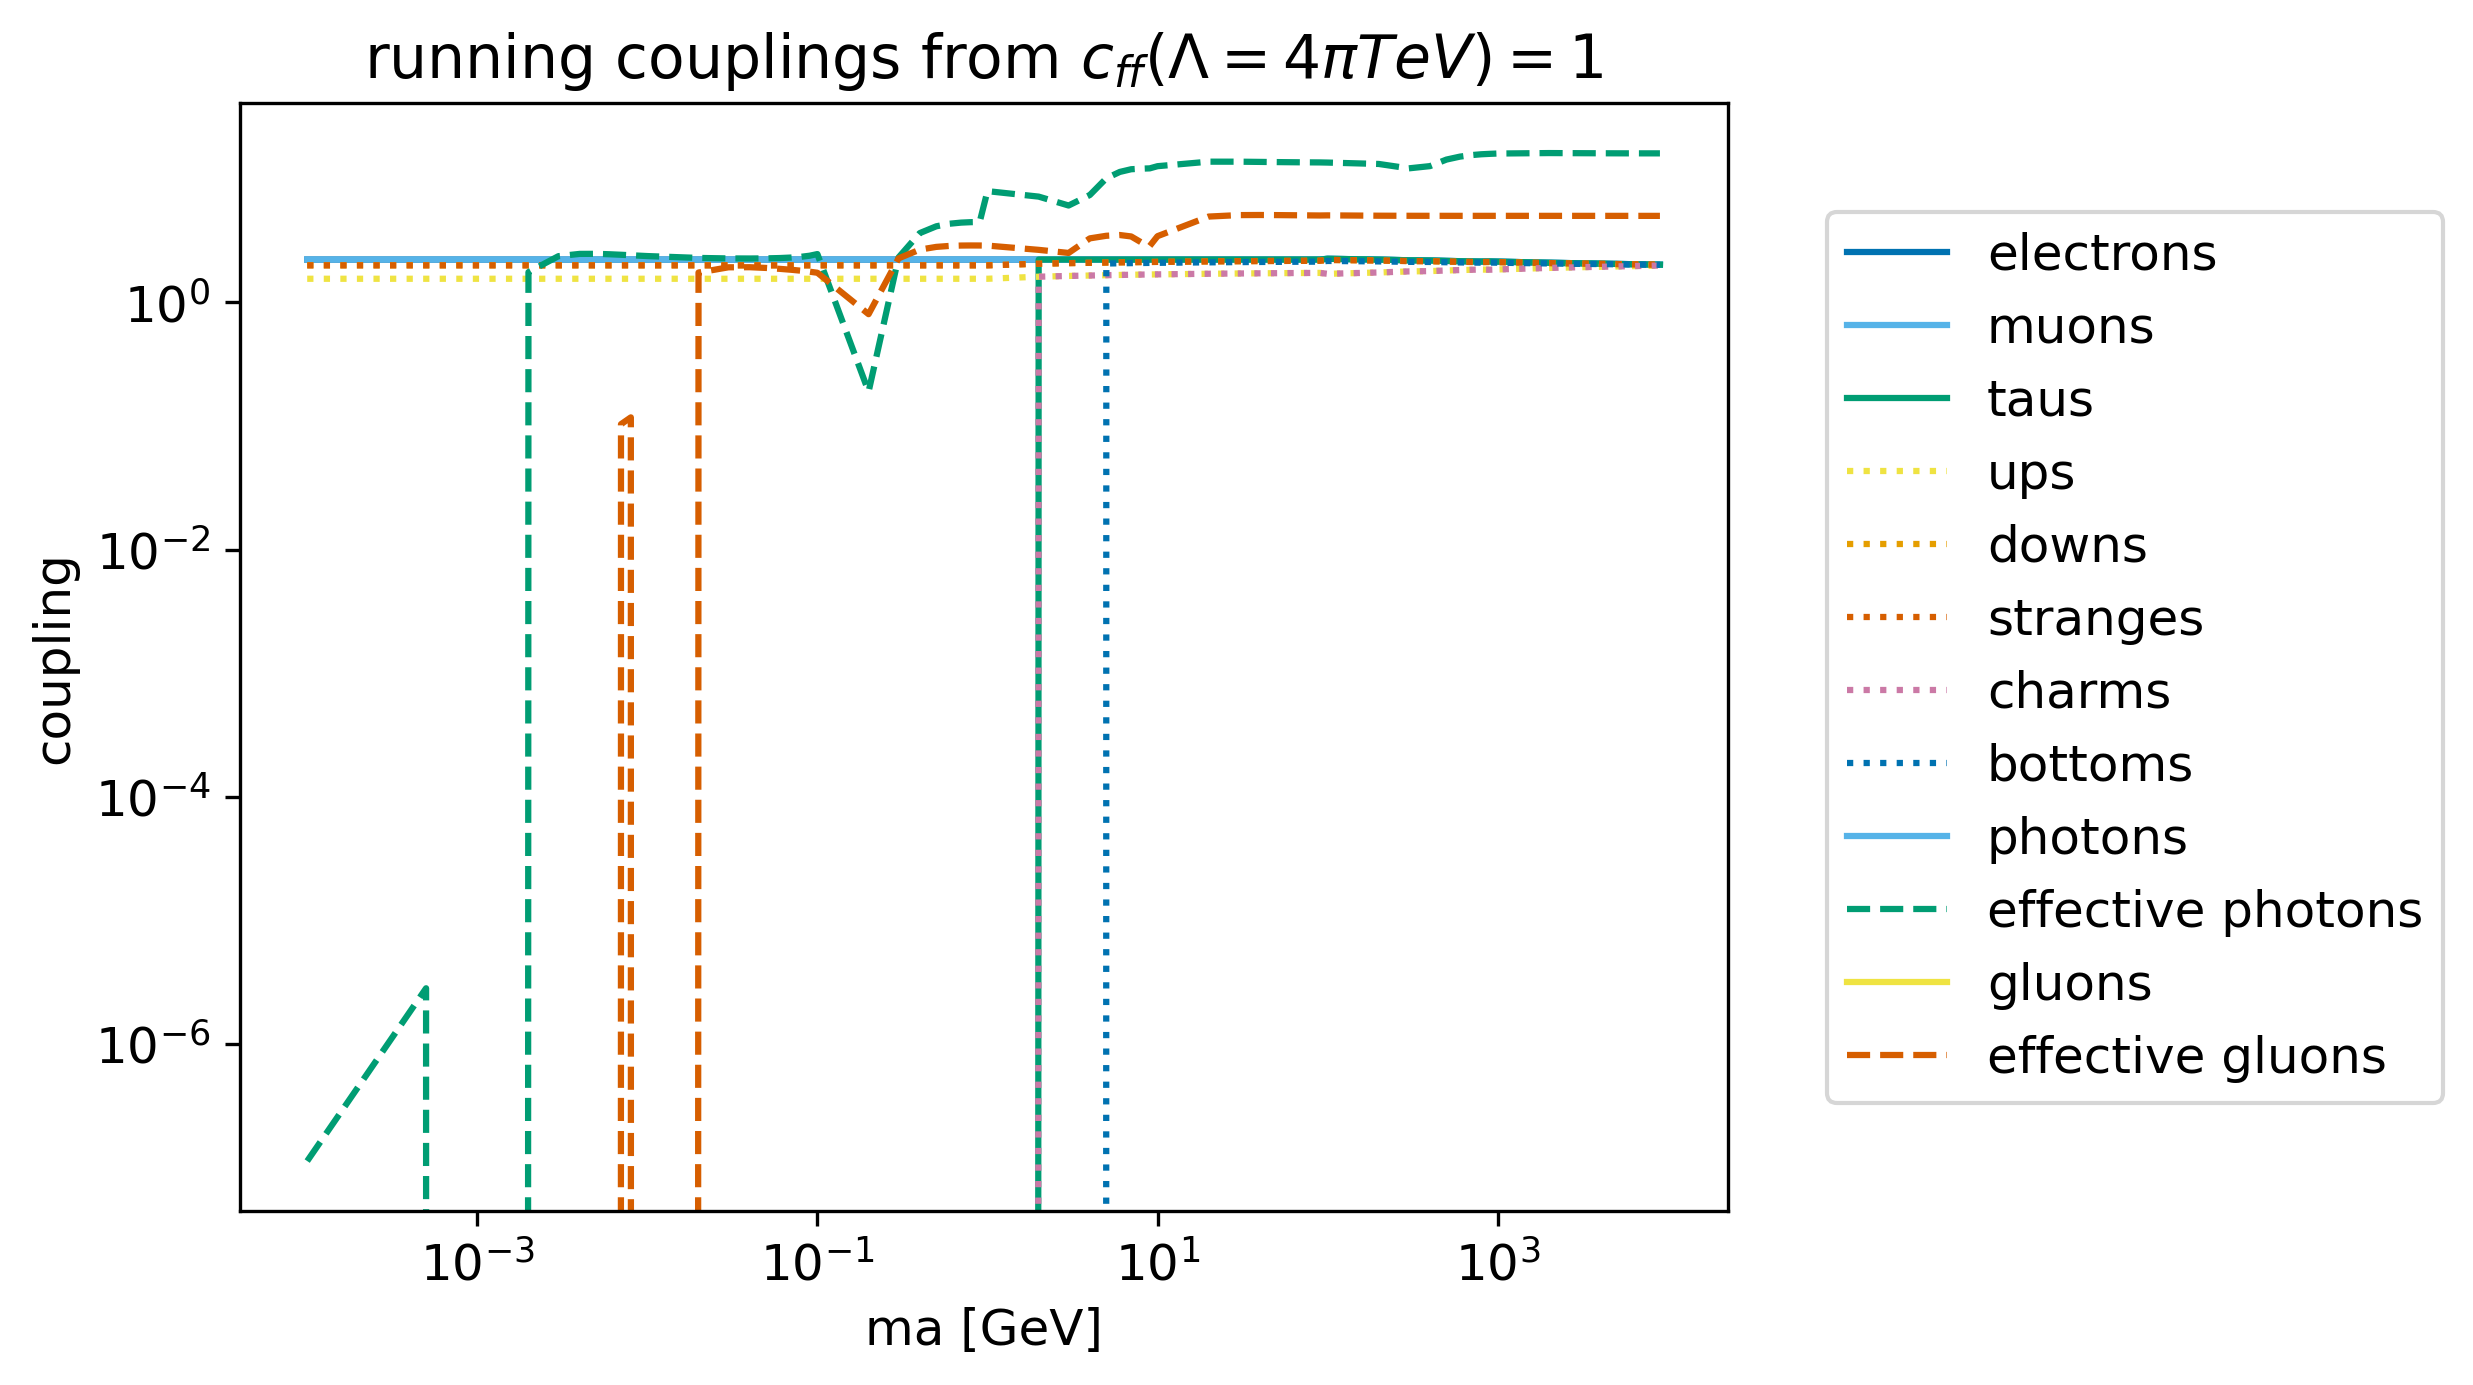

In [5]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_BRs.ipynb")

### mass-coupling grid

In [6]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.09, 0.101, 0.43, 0.47,0.55,\
                                                   0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4,\
                                                   0.0935, 0.095, 0.63, 0.65]))
masslistShort=np.logspace(-2,np.log(2.1), 40)
masslistcWWcheck= np.linspace(0.3,0.4,1)
particleCodes=[*range(0,7,1)]

masslistCheck=np.logspace(-2,np.log10(2.1), 3)

masslistPrompt=np.logspace(np.log10(0.2),np.log10(5))

In [7]:
couplingList=np.sort(np.append(np.logspace(-6, 4, 20),np.logspace(-1, 2, 20)))

couplingListcWW=np.logspace(-1, 2, 20)
couplingListcff=np.logspace(np.log(0.02), np.log(0.5), 20)

couplingListShort=np.logspace(np.log(8*10**-4), np.log(1.7), 25)
couplingListcWWcheck=np.arange(0,190)*0.5+0.5
couplingListcWWcheckShort=np.array([0.5,1,1.5,2,2,5.3,50,80,85,90,95])

couplingListcWWprompt=np.logspace(0,2, 40)
couplingListcffprompt=np.logspace(-4, 0, 40)

In [8]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [9]:
sm['tauB+'] = 1.638*10**(-12)
sm['ctauB+']= 3 * 10**10 * 1.638*10**(-12)

sm['mB0'] = 5.27965
sm['tauB0'] = 1.519*10**(-12)

sm['mK0'] = 0.89166

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

### ALP and B-> Ka decay rates

In [10]:
def fzStar(t):
    tplus = (sm['mB0']+sm['mK0'])**2
    tminus = (sm['mB0']-sm['mK0'])**2
    tzero = tplus * (1-math.sqrt(1-tminus/tplus))
    return (math.sqrt(tplus-t) - math.sqrt(tplus-tzero))/(math.sqrt(tplus-t) + math.sqrt(tplus-tzero))


def formFactorAzeroBstar(qsqr):
    tmp = 0.34339
    tmp += -1.1296 * (fzStar(qsqr) - fzStar(0))
    tmp += 2.32629 * (fzStar(qsqr) - fzStar(0))**2
    tmp = tmp/(1-qsqr/5.27**2)
    return tmp

In [11]:
def BrBtoKaplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma**2))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mB+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))\
            /sm['hbar']*sm['tauB+']

In [12]:
abs(formFactorFzeroBplus(0))

0.329

In [12]:
def BrB0toK0aplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorAzeroBstar(ma**2))**2 \
            * (sm['mB0']**2-sm['mK0']**2)**2/sm['mB0']**3 * np.sqrt(sm['mB0']**4+sm['mK0']**4+ma**4\
            -2*(sm['mB0']**2 * sm['mK0']**2 + sm['mK0']**2 * ma**2 + ma**2 * sm['mB0']**2))\
            /sm['hbar']*sm['tauB0']

In [13]:
def BrKtoPiaplusForPrefactor(ma, cbs, Lambda):
        return np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mK+']**2 * sm['mB+']**2 + sm['mB+']**2 * ma**2 + ma**2 * sm['mK+']**2))\
            /(sm['mB+']**2-sm['mK+']**2)

In [14]:
def BrBtoKaplusSimpl(ma, cff, cWW):
        return 0.03 * (cff + 0.0032 * cWW)**2 * np.sqrt(sm['mB+']**4\
                +sm['mK+']**4 +ma**4-2*(sm['mK+']**2 * sm['mB+']**2 + sm['mB+']**2 * ma**2 \
                                         + ma**2 * sm['mK+']**2))/(sm['mB+']**2-sm['mK+']**2)

In [15]:
def prefactorFull(ma, cbs, Lambda):
    return  (np.pi/4)* abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma**2))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3/sm['hbar']*sm['tauB+'] * (sm['mB+']**2-sm['mK+']**2)

In [16]:
def prefactorSimp(ma, cff, cWW):
    return 0.03 * (cff + 0.0032 * cWW)**2

In [17]:
def BrRest(ma):
    return np.sqrt(sm['mB+']**4\
                +sm['mK+']**4 +ma**4-2*(sm['mK+']**2 * sm['mB+']**2 + sm['mB+']**2 * ma**2 \
                                         + ma**2 * sm['mK+']**2))/(sm['mB+']**2-sm['mK+']**2)

In [18]:
def Z(ma, cbs, Lambda):
#     return np.sqrt(BrBtoKaplus(ma, cbs, Lambda)/BrBtoKaplusForPrefactor(ma, cbs, Lambda))
    return np.sqrt(prefactorFull(ma, cbs, Lambda))

In [19]:
ma=1
cbs=2
Lambda=4*np.pi*1000

print(prefactorFull(ma, cbs, Lambda)*BrRest(ma))
print(Z(ma, cbs, Lambda)**2*BrRest(ma))
print(BrBtoKaplus(ma, cbs, Lambda))

783267.5583450677
783267.5583450677
783267.5583450677


In [20]:
Lambda=4*np.pi*1000
cff=1
cBB=0
cWW=0
ma=10

print(prefactorSimp(ma, cff, cWW))

0.03


### ALP branching ratios

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [21]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    print("Lambda=",Lambda)
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            if ma<1:
                mu = 1
            else:
                mu=ma
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)
        
#         print("mu= ",mu)
#         print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
#         print([ma,readCee(lscs),sm['me'],Lambda])
#         print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])
            

#         print("br[0][-1]= ",brs[0][-1])
        
        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]
#         return [brs[finalStateCode][-1],ctauAlp]

### Cross-checks for Alp decays

In [25]:
print("BR(a->e e)= ",brALPtoOneFinalState(0.3,0,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a->mu mu)= ",brALPtoOneFinalState(0.3,1,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a->tau tau)= ",brALPtoOneFinalState(0.3,2,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a->c c)= ",brALPtoOneFinalState(0.3,3,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a->b b)= ",brALPtoOneFinalState(0.3,4,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a->gamma gamma)= ",brALPtoOneFinalState(0.3,5,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a->hadrons)= ",brALPtoOneFinalState(0.3,6,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("BR(a-> 3 pions)= ",brALPtoOneFinalState(0.3,7,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])

Lambda= 12566.370614359172
BR(a->e e)=  3.023535553558155e-07
Lambda= 12566.370614359172
BR(a->mu mu)=  0.009175505470266354
Lambda= 12566.370614359172
BR(a->tau tau)=  0.0
Lambda= 12566.370614359172
BR(a->c c)=  0.0
Lambda= 12566.370614359172
BR(a->b b)=  0.0
Lambda= 12566.370614359172
BR(a->gamma gamma)=  0.9908241921761783
Lambda= 12566.370614359172
BR(a->hadrons)=  0.0
Lambda= 12566.370614359172
BR(a-> 3 pions)=  0.0


In [26]:
print("W(a->e e)= ",brALPtoOneFinalState(0.3,0,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a->mu mu)= ",brALPtoOneFinalState(0.3,1,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a->tau tau)= ",brALPtoOneFinalState(0.3,2,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a->c c)= ",brALPtoOneFinalState(0.3,3,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a->b b)= ",brALPtoOneFinalState(0.3,4,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a->gamma gamma)= ",brALPtoOneFinalState(0.3,5,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a->hadrons)= ",brALPtoOneFinalState(0.3,6,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])
print("W(a-> 3 pions)= ",brALPtoOneFinalState(0.3,7,0,0,0,0,0,0,1,0,4*np.pi*1000)[0])

Lambda= 12566.370614359172
W(a->e e)=  3.023535553558155e-07
Lambda= 12566.370614359172
W(a->mu mu)=  0.009175505470266354
Lambda= 12566.370614359172
W(a->tau tau)=  0.0
Lambda= 12566.370614359172
W(a->c c)=  0.0
Lambda= 12566.370614359172
W(a->b b)=  0.0
Lambda= 12566.370614359172
W(a->gamma gamma)=  0.9908241921761783
Lambda= 12566.370614359172
W(a->hadrons)=  0.0
Lambda= 12566.370614359172
W(a-> 3 pions)=  0.0


## Generate [ma, tau, c, BR(theory)] files

In [24]:
def generateLHCbFiles(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        lhcbList=[['# m [GeV], tau [ps], c, BR_theo(B->K mu mu)\n']]
#         print("start")

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

                coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
                cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])
#                 print("ma= ",ma,", cff= ",cff,", cWW= ",cWW,", cBB= ",cBB,", cbs= ",cbs)

                BR= BrBtoKaplus(ma, cbs, Lambda) \
                *brALPtoOneFinalState(ma,1,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                lhcbList.append([ma,tau,c,BR])
        return lhcbList

In [25]:
def generateLHCbPromptFiles(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        lhcbList=[['# m [GeV], tau [ps], c, BR_theo(B0->K0 mu mu)\n']]
#         print("start")

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

                coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
                cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])
#                 print("ma= ",ma,", cff= ",cff,", cWW= ",cWW,", cBB= ",cBB,", cbs= ",cbs)

                BR= BrB0toK0aplus(ma, cbs, Lambda) \
                *brALPtoOneFinalState(ma,1,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                lhcbList.append([ma,tau,c,BR])
        return lhcbList

In [22]:
def cbsFromFundamentalCouplings(cff,cWW,Lambda,ma):
    
    coefs=getLScoefficients(cff, cWW, 0, Lambda, ma)
    cbs=getCbs(cff, cWW, 0, Lambda, sm['mB+'])
    
    return cbs

In [28]:
print(cbsFromFundamentalCouplings(1,0,4*np.pi*1000,1))
print(cbsFromFundamentalCouplings(0,1,4*np.pi*1000,1))

(-0.0007549922846009775-1.4138588757593833e-05j)
(-1.1934623386190806e-06-2.2349729325154e-08j)


In [23]:
couplingstest=[10**-3,10**-2,10**-1,1,10**1,10**2]

print("couplings=",couplingstest,"\n")

ZZ=[]
for c in couplingstest:
    ZZ.append(Z(0.1,(cbsFromFundamentalCouplings(c/2,0,4*np.pi*1000,0.1)),4*np.pi*1000))
print("ma=0.1, Z (cff)=",ZZ,"\n")

ZZ=[]
for c in couplingstest:
    ZZ.append(Z(0.1,(cbsFromFundamentalCouplings(0,c,4*np.pi*1000,0.1)),4*np.pi*1000))
print("ma=0.1, Z (cWW)=",ZZ,"\n")

couplings= [0.001, 0.01, 0.1, 1, 10, 100] 

ma=0.1, Z (cff)= [0.00016493418569920505, 0.0016516939184713436, 0.016543986373574456, 0.16548452949848616, 1.6548926251859832, 16.54897386171099] 

ma=0.1, Z (cWW)= [5.222286802147952e-07, 5.222286738670267e-06, 5.222285806968282e-05, 0.0005231912651072082, 0.005226151478824267, 0.05217988235688306] 



In [31]:
couplingstest=[10**-3,10**-2,10**-1,1,10**1,10**2]

print("couplings=",couplingstest,"\n")

ZZ=[]
for c in couplingstest:
    ZZ.append(Z(1,cbsFromFundamentalCouplings(c,0,4*np.pi*1000,1),4*np.pi*1000))
print("ma=1, Z (cff)=",ZZ,"\n")

ZZ=[]
for c in couplingstest:
    ZZ.append(Z(1,cbsFromFundamentalCouplings(0,c,4*np.pi*1000,1),4*np.pi*1000))
print("ma=1, Z (cWW)=",ZZ,"\n")

ZZ=[]
for c in couplingstest:
    ZZ.append(Z(1,cbsFromFundamentalCouplings(0,c,4*np.pi*1000,1),4*np.pi*1000)/\
             Z(1,cbsFromFundamentalCouplings(c,0,4*np.pi*1000,1),4*np.pi*1000))
print("ma=1, Z (cWW)/Z (cff)=",ZZ,"\n")

couplings= [0.001, 0.01, 0.1, 1, 10, 100] 

ma=1, Z (cff)= [0.00033938775464723334, 0.0034007610878457576, 0.03404380744826882, 0.34048551676235006, 3.40490401746036, 34.049089168678066] 

ma=1, Z (cWW)= [5.372359701599415e-07, 5.372359636297571e-06, 5.372358677821258e-05, 0.0005382262168624476, 0.005376335437521657, 0.053679376071995154] 

ma=1, Z (cWW)/Z (cff)= [0.001582956258154793, 0.0015797521488640474, 0.0015780722194439654, 0.0015807609732725147, 0.001578997648671384, 0.0015765289874883081] 



In [30]:
couplingstest=[10**-3,10**-2,10**-1,1,10**1,10**2]

print("couplings=",couplingstest,"\n")

BR=[]
for c in couplingstest:
    BR.append(Z(0.1,(cbsFromFundamentalCouplings(c/2,0,4*np.pi*1000,0.1)),4*np.pi*1000))
print("ma=0.1, Z (cff)=",cbs,"\n")

BR=[]
for c in couplingstest:
    BR.append(Z(0.1,(cbsFromFundamentalCouplings(0,c,4*np.pi*1000,0.1)),4*np.pi*1000))
print("ma=0.1, Z (cWW)=",cbs,"\n")

couplings= [0.001, 0.01, 0.1, 1, 10, 100] 

ma=0.1, Z (cff)= 2 

ma=0.1, Z (cWW)= 2 



In [10]:
cbsFromFundamentalCouplings(1,0,4*np.pi*1000,4.18)

(-0.0007549922846009775-1.4138588757593833e-05j)

In [11]:
cbsFromFundamentalCouplings(0,1,4*np.pi*1000,4.18)

(-1.1934623386190806e-06-2.2349729325154e-08j)

In [30]:
cbs=[]
for c in couplingListShort:
    cbs.append(abs(cbsFromFundamentalCouplings(c/2,0,4*np.pi*1000,1))/\
               abs(cbsFromFundamentalCouplings(0,c,4*np.pi*1000,1)))
print("ma=1, cbs (cff/cWW)=",cbs,"\n")

ma=1, cbs (cff/cWW)= [315.819687135869, 315.8196871359109, 315.8196871360906, 315.81968713687843, 315.8196871402961, 315.81968715514716, 315.8196872194648, 315.8196874969898, 315.8196886883063, 315.81969380261484, 315.8197167047133, 315.81984042932964, 315.8207740688215, 315.8285227008063, 315.87397097844257, 316.01809837445523, 316.2590485281454, 316.5019993620922, 316.6773638416653, 316.7813849905857, 316.8350913233808, 316.83262758945995, 316.57106966491676, 316.63361000169823, 316.53963681918106] 



In [31]:
Lambda=4*np.pi*1000
cff=2
cBB=0
cWW=1

for ma in [50*10**(-3),120*10**(-3),230*10**(-3)]:

    cbs=cbsFromFundamentalCouplings(cff/2,cWW,Lambda,ma)

    BR= BrBtoKaplus(ma, cbs, Lambda)
    tau=ctaua(ma, cff/2, cWW, cBB, Lambda)/sm['c']*10**12
    
    print("prefactors=",prefactorFull(ma, cbs, Lambda)," , ", prefactorSimp(ma, cff, cWW)," , ",\
          Z(ma, cbs, Lambda)**2)
    print("ma=",ma,"; Kaon form factor f=", formFactorFzeroBplus(ma**2))
    print("BRSimp(B+ -> K+ a)=",BrBtoKaplusSimpl(ma, cff, cWW))
    print("cff=",cff,"cWW=",cWW, "; ma=",ma, "; cbs=",cbs,\
          ";\n BR(B+ -> K+ a)=",BR,"; tau(a)=",tau, "[ps]\n")

prefactors= 0.10984127865087212  ,  0.1203843072  ,  0.1098412786508721
ma= 0.05 ; Kaon form factor f= 0.3290232196956104
BRSimp(B+ -> K+ a)= 0.12037322155297016
cff= 2 cWW= 1 ; ma= 0.05 ; cbs= (-0.0007561761686495232-1.4160759116206098e-05j) ;
 BR(B+ -> K+ a)= 0.10983116386371461 ; tau(a)= 1030.7342802934315 [ps]

prefactors= 0.10991511624745383  ,  0.1203843072  ,  0.10991511624745381
ma= 0.12 ; Kaon form factor f= 0.32913378924947473
BRSimp(B+ -> K+ a)= 0.12032045339177583
cff= 2 cWW= 1 ; ma= 0.12 ; cbs= (-0.0007561761686495232-1.4160759116206098e-05j) ;
 BR(B+ -> K+ a)= 0.109856815469578 ; tau(a)= 428.3988903556473 [ps]

prefactors= 0.1101545046935545  ,  0.1203843072  ,  0.11015450469355452
ma= 0.23 ; Kaon form factor f= 0.3294920110086901
BRSimp(B+ -> K+ a)= 0.12014972740924328
cff= 2 cWW= 1 ; ma= 0.23 ; cbs= (-0.0007561761686495232-1.4160759116206098e-05j) ;
 BR(B+ -> K+ a)= 0.10993985860501578 ; tau(a)= 0.013272888079232003 [ps]



In [41]:
meshcWWcheck=generateLHCbFiles(masslistcWWcheck,couplingListcWWcheck,'cWW',4*np.pi*10**3)

In [42]:
with open("output/m-tau-c-BRBtoKmumu-cWWcheck.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWcheck)

In [47]:
os.getcwd()

'/home/stasya/prj/alps-BelleII/python'

In [48]:
os.chdir("/home/stasya/prj/alps-BelleII/python/")

In [14]:
meshcWW=generateLHCbFiles(masslist,couplingListcWW,'cWW',4*np.pi*10**3)
meshcff=generateLHCbFiles(masslist,couplingListcff,'cff',4*np.pi*10**3)

In [15]:
        
with open("output/m-tau-c-BRBtoKmumu-cWW_fine.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWW)
    
with open("output/m-tau-c-BRBtoKmumu-cff_fine.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcff)

# prompt search files generator

In [56]:
meshcWWprompt=generateLHCbPromptFiles(masslistPrompt,couplingListcWWprompt,'cWW',4*np.pi*10**3)
meshcffprompt=generateLHCbPromptFiles(masslistPrompt,couplingListcff,'cff',4*np.pi*10**3)

/tmp/ipykernel_24590/2779438533.py:3: RuntimeWarning: invalid value encountered in sqrt
  * (sm['mB0']**2-sm['mK0']**2)**2/sm['mB0']**3 * np.sqrt(sm['mB0']**4+sm['mK0']**4+ma**4\


In [57]:
with open("output/m-tau-c-BRBtoKmumu-cWW-prompt.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWprompt)
    
with open("output/m-tau-c-BRBtoKmumu-cff-prompt.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcffprompt)